In [1]:
!pip install python-docx


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.0/253.0 kB 2.9 MB/s eta 0:00:00


CRYPTOCURRENCY EVENT STUDY - TRUMP ADMINISTRATION POLICY INTERVENTIONS

Step 1: Loading data and calculating log returns...
✓ Data loaded: 964 observations
✓ Cryptocurrencies: 15
✓ Date range: 2023-03-02 to 2025-10-20

Step 2: Defining 3 events...

Event Dates:
  Atkins_Nomination: 2024-12-04
  Executive_Order: 2025-01-23
  Reserve_Announcement: 2025-03-02

Step 4: Setting up 365-day estimation window (crypto calendar - 7 days/week)...
ESTIMATION PERIOD (365 DAYS - CRYPTO CALENDAR)
Start: 2023-12-03 | End: 2024-12-02 | Observations: 366

TABLE 1: MARKET MODEL PARAMETERS (365-Day Estimation)
Cryptocurrency                 Alpha            Beta              R²            Std Error
----------------------------------------------------------------------------------------------------------------------------------------------------------------
BTC-USD                     0.000363          0.8571          0.8177             0.011869
ETH-USD                    -0.000969          0.9945         

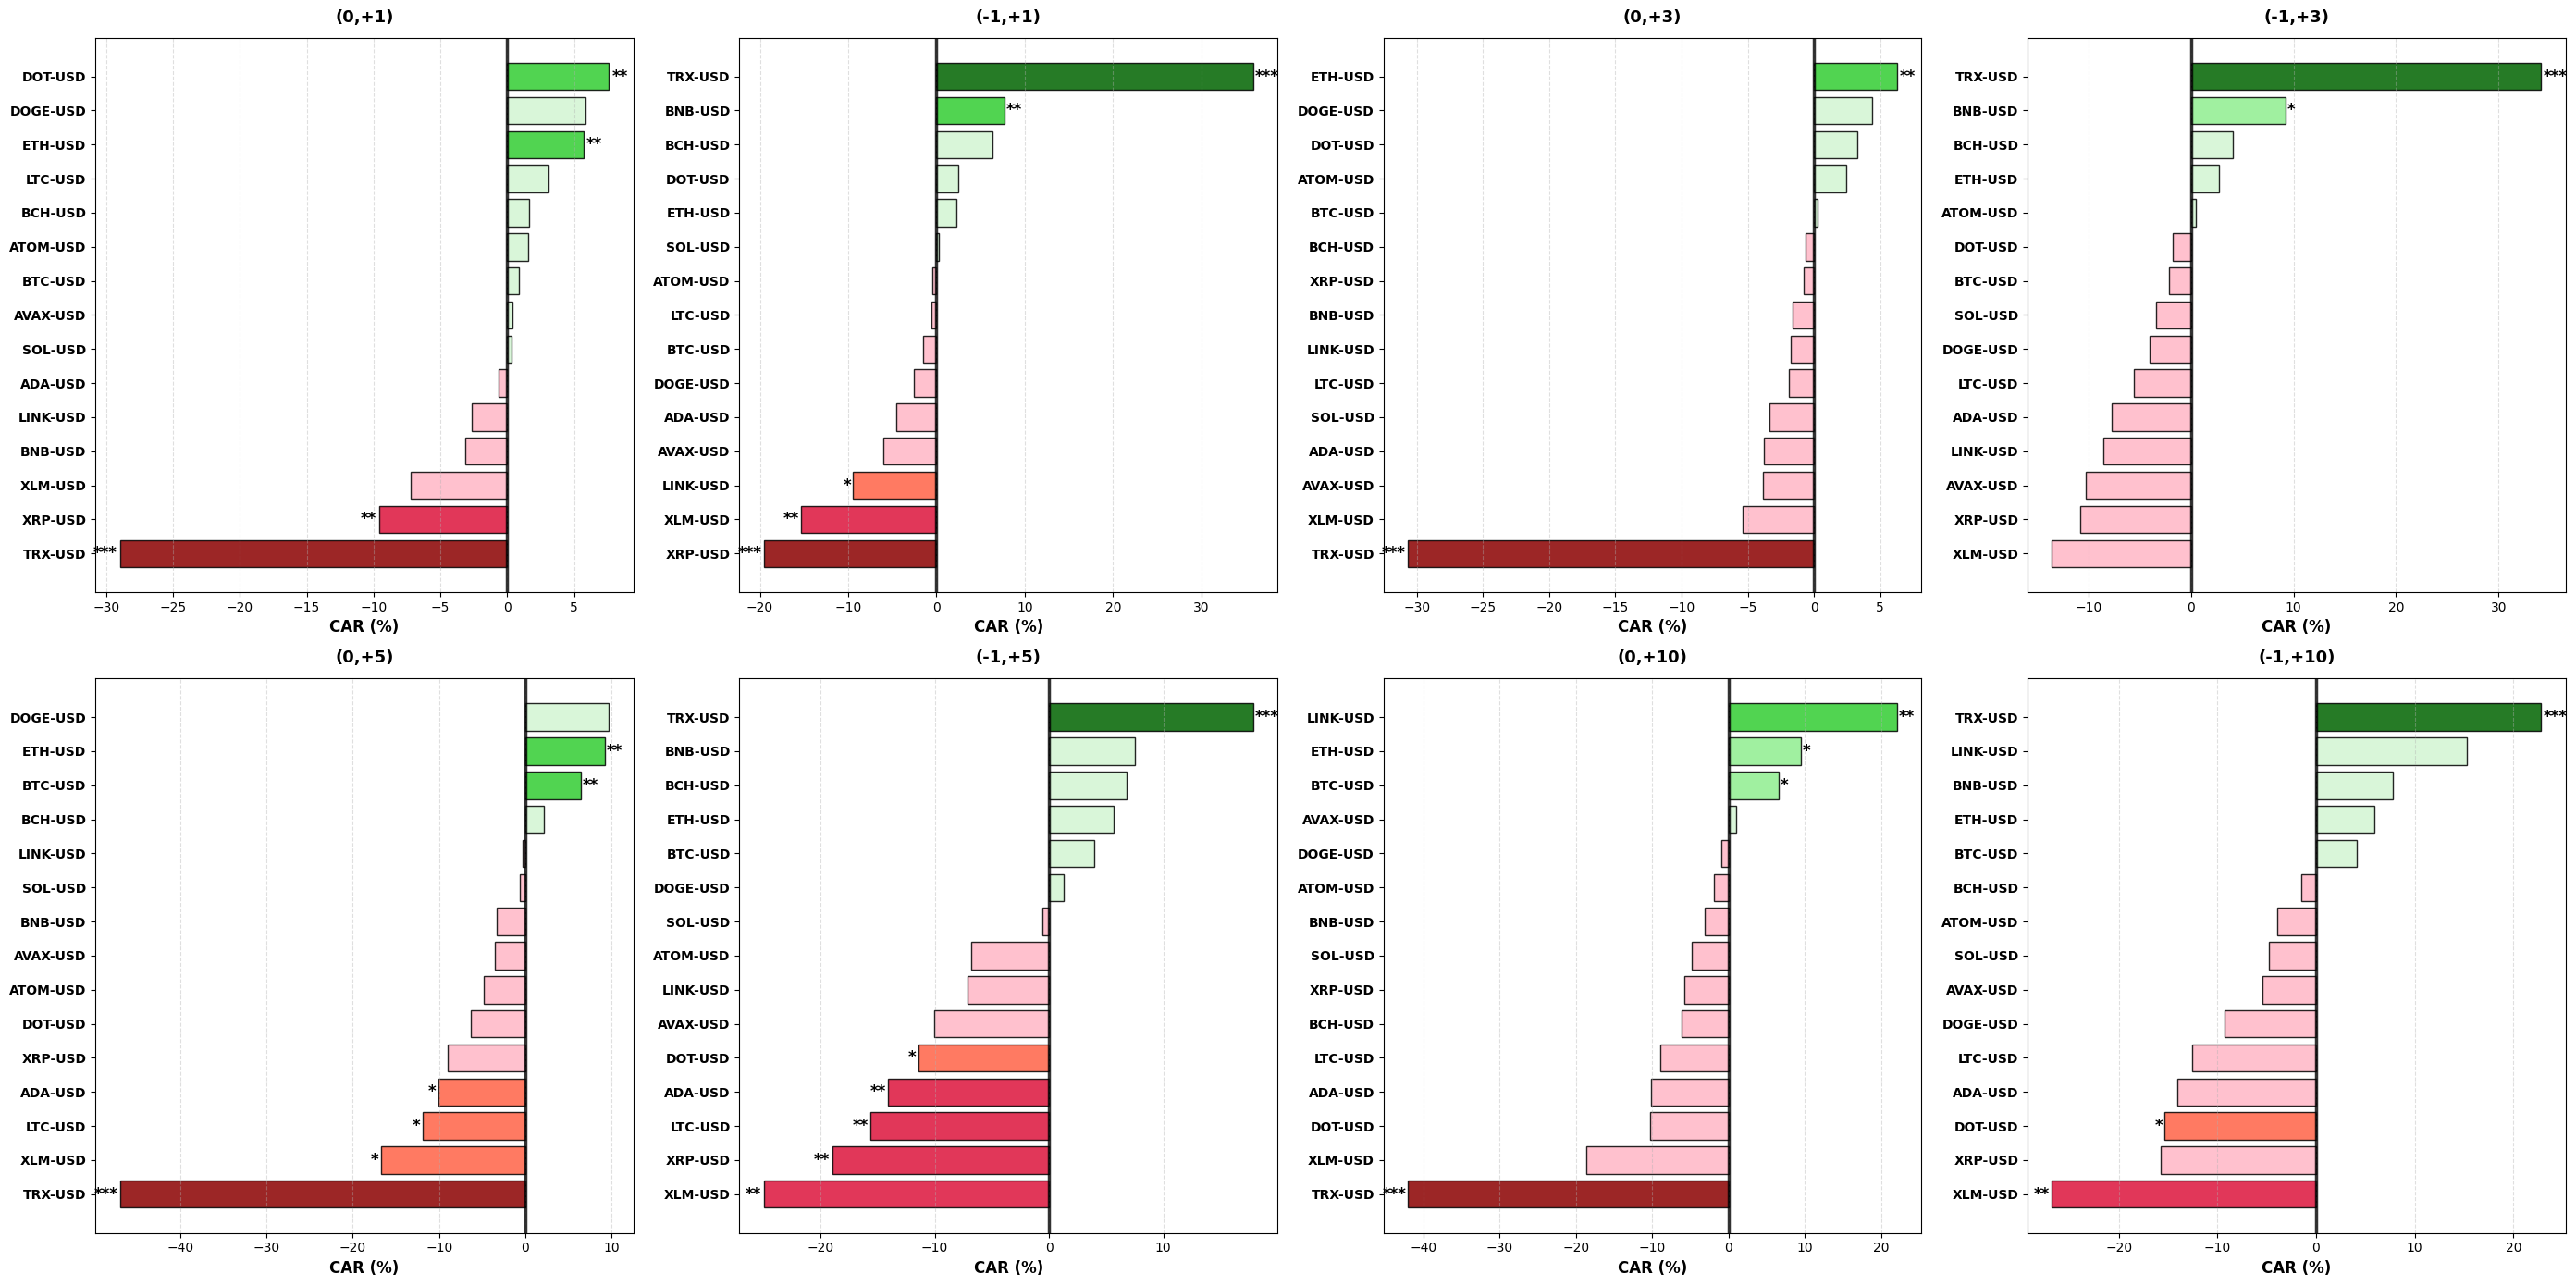

  Figure: Executive Order - Winners/Losers


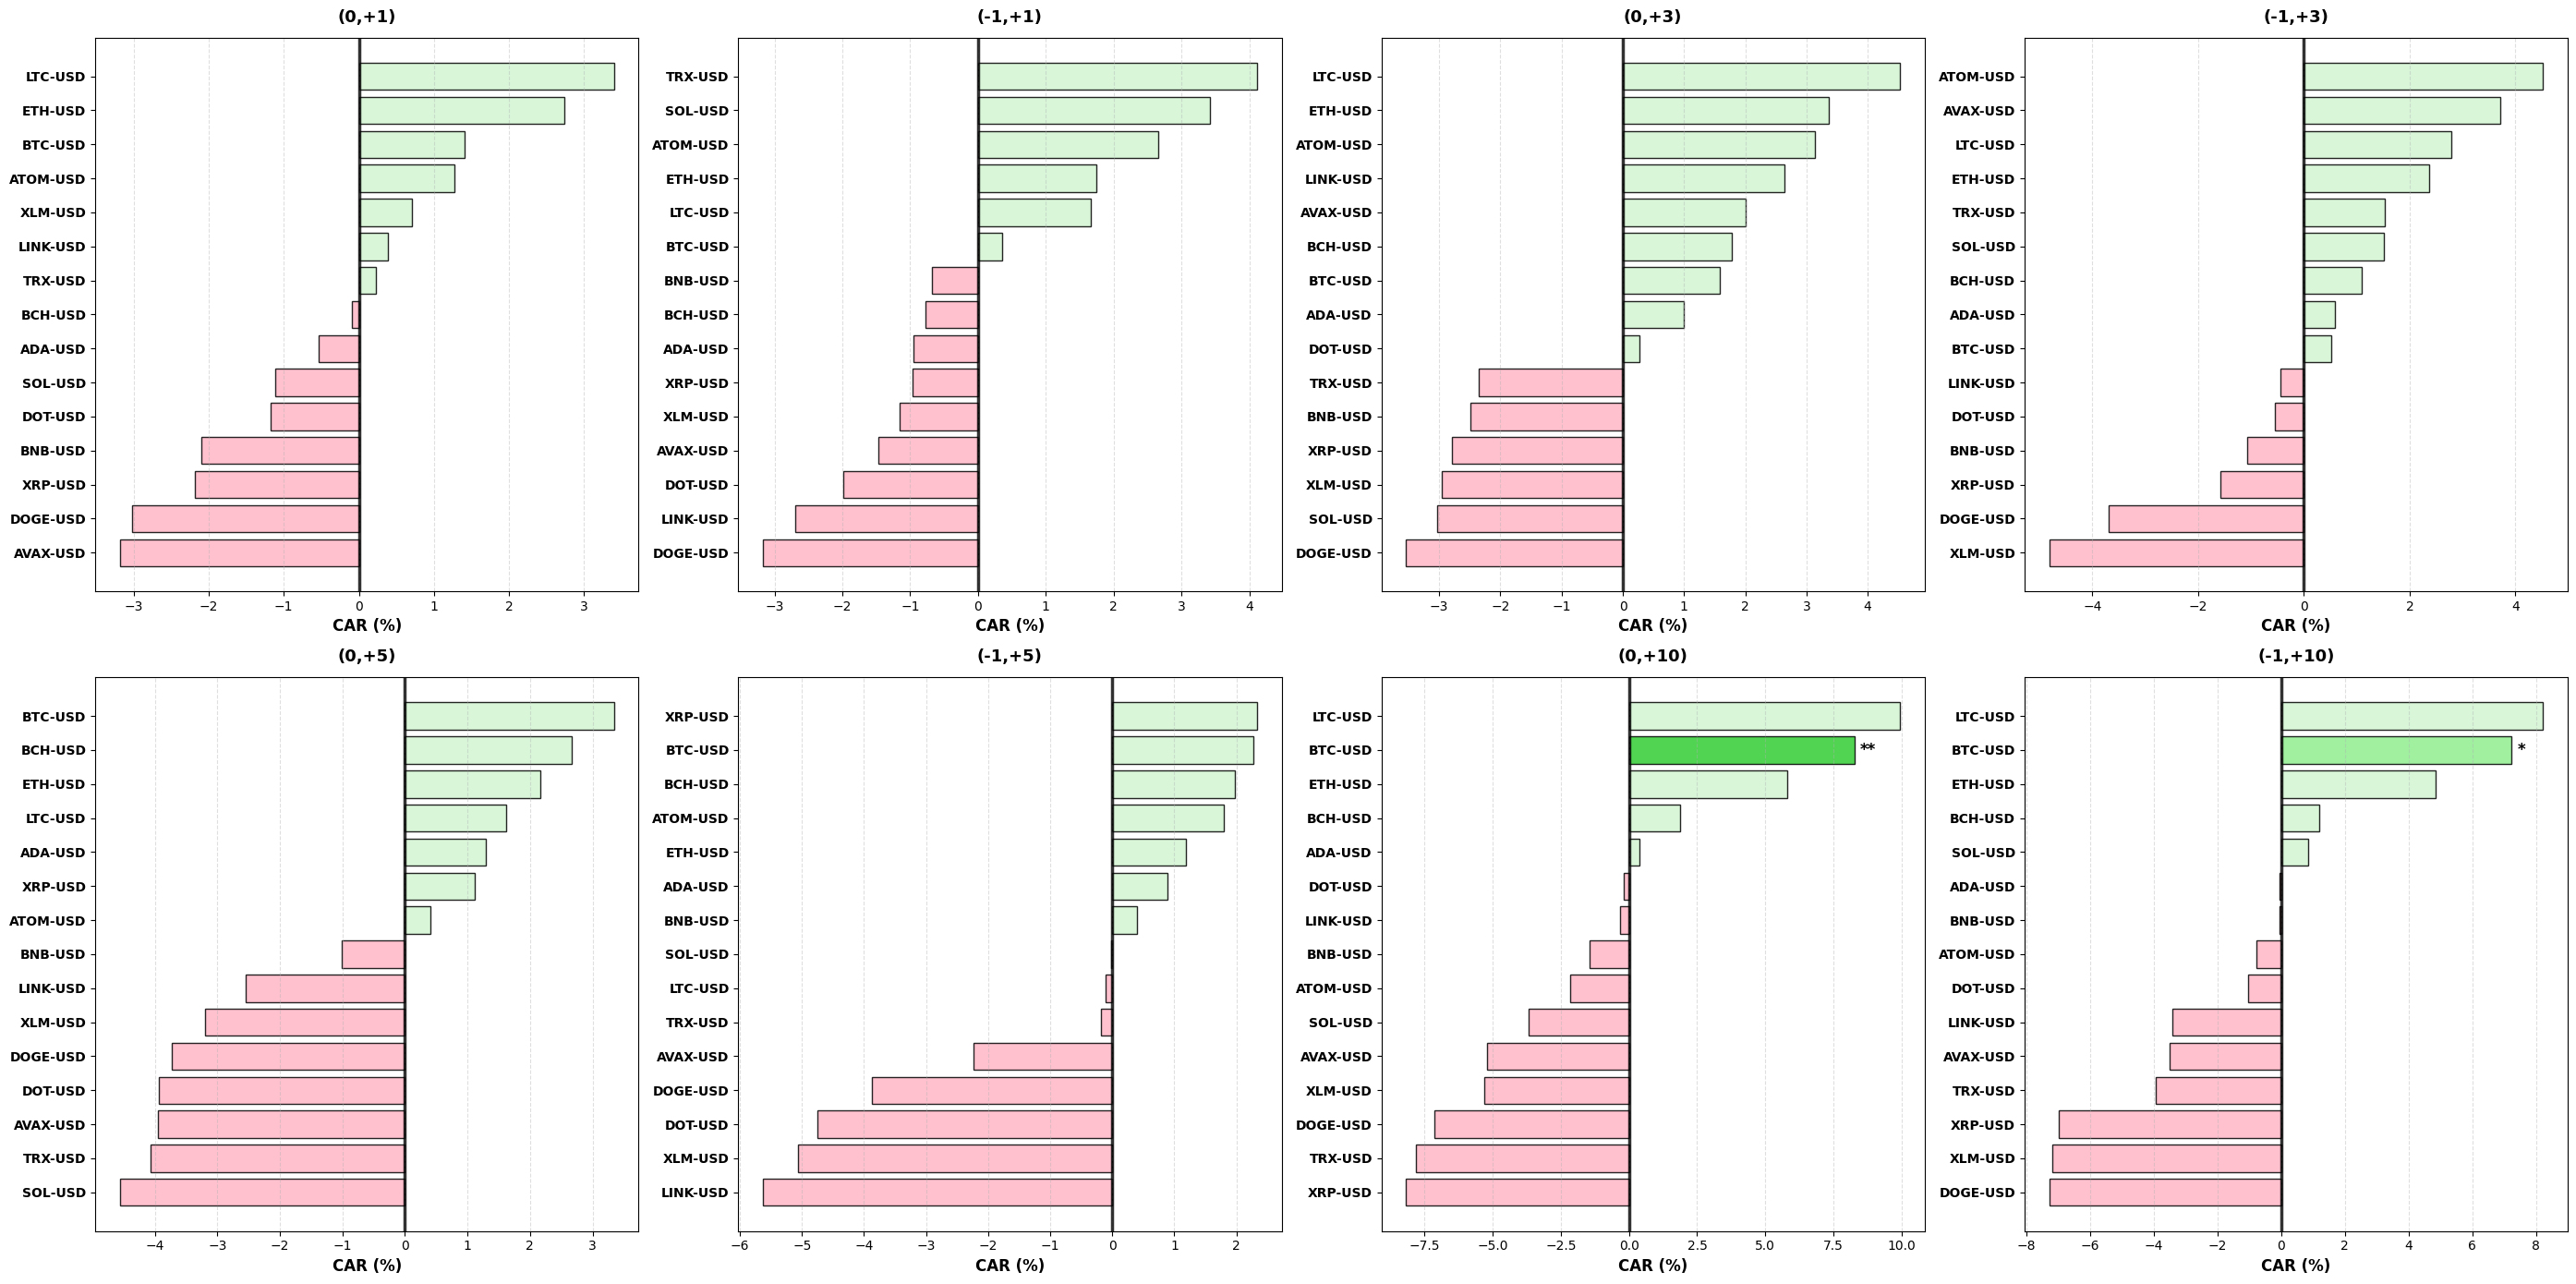

  Figure: Reserve Announcement - Winners/Losers


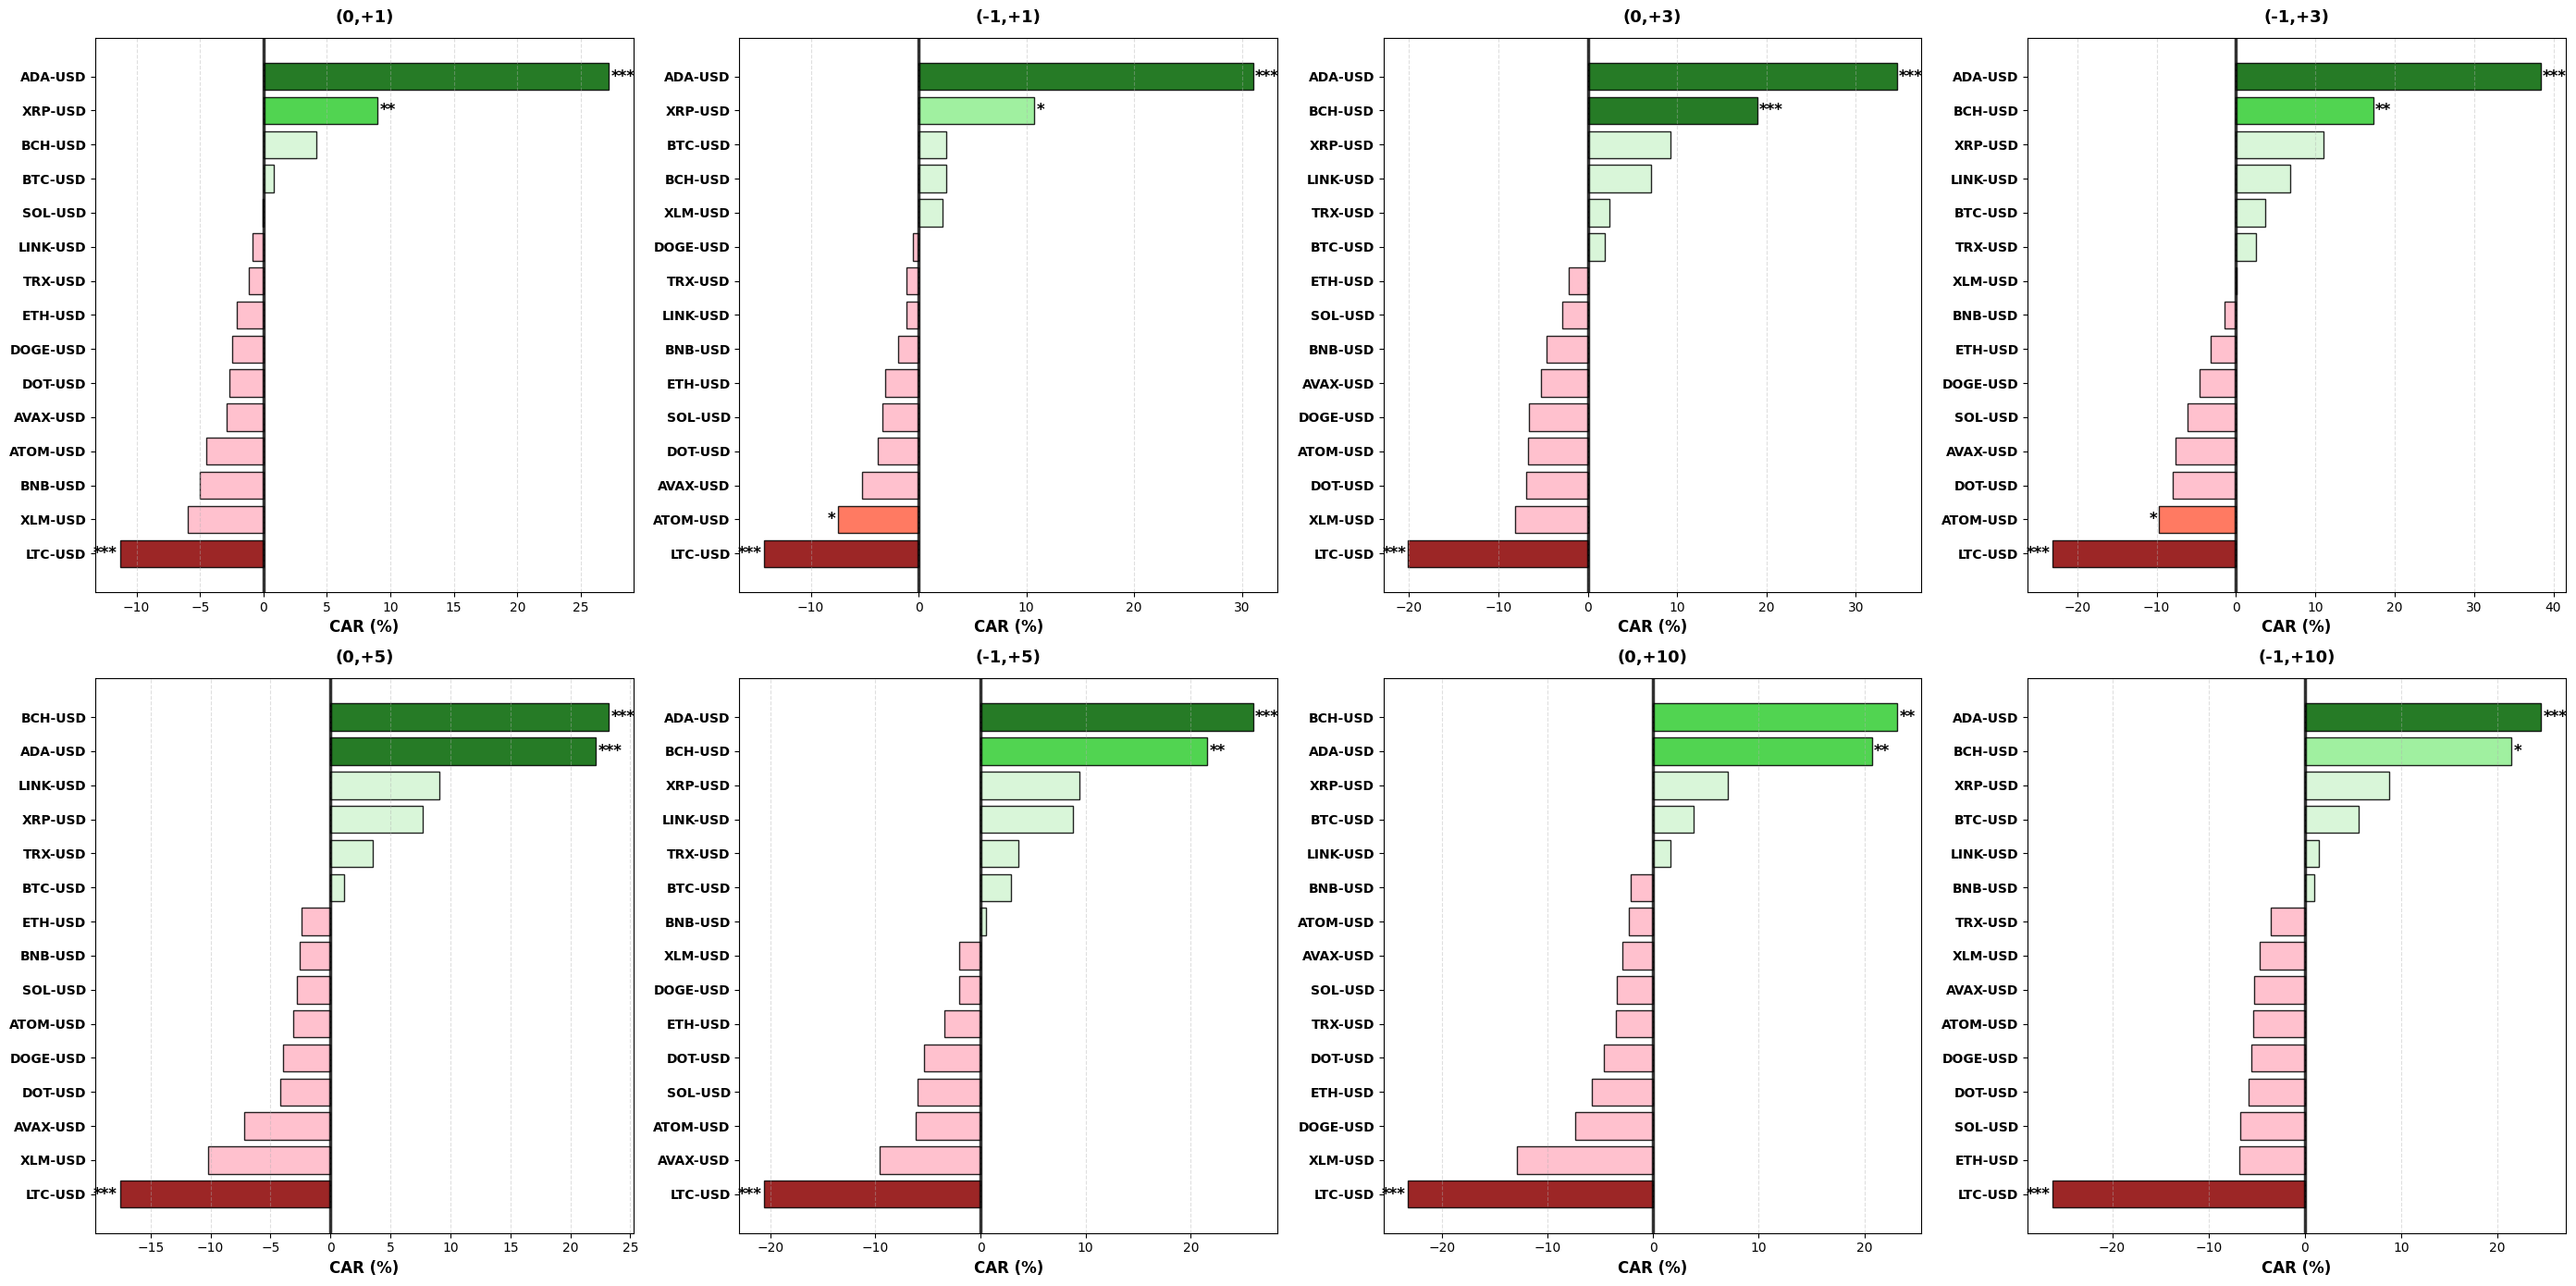


Plot 2: Learning Curve (CAR Timeline)...
  Figure: Learning Curve - Individual Cryptocurrency Colors


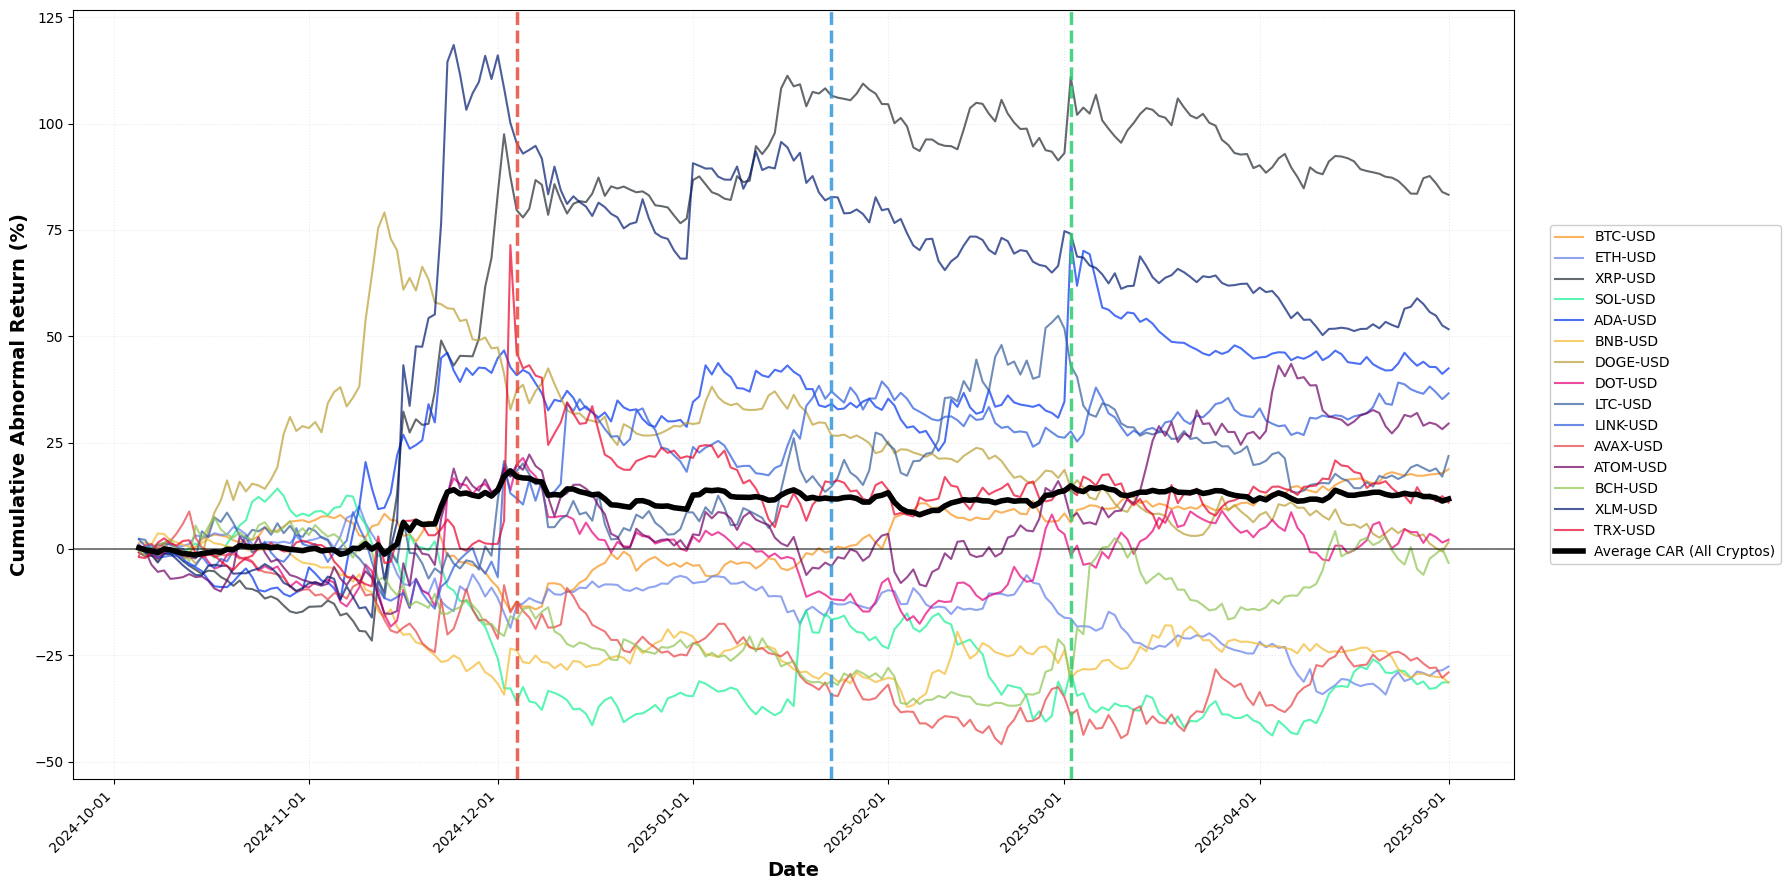


Plot 3: Violin Plots (Distribution Analysis)...
  Figure: Violin Plots


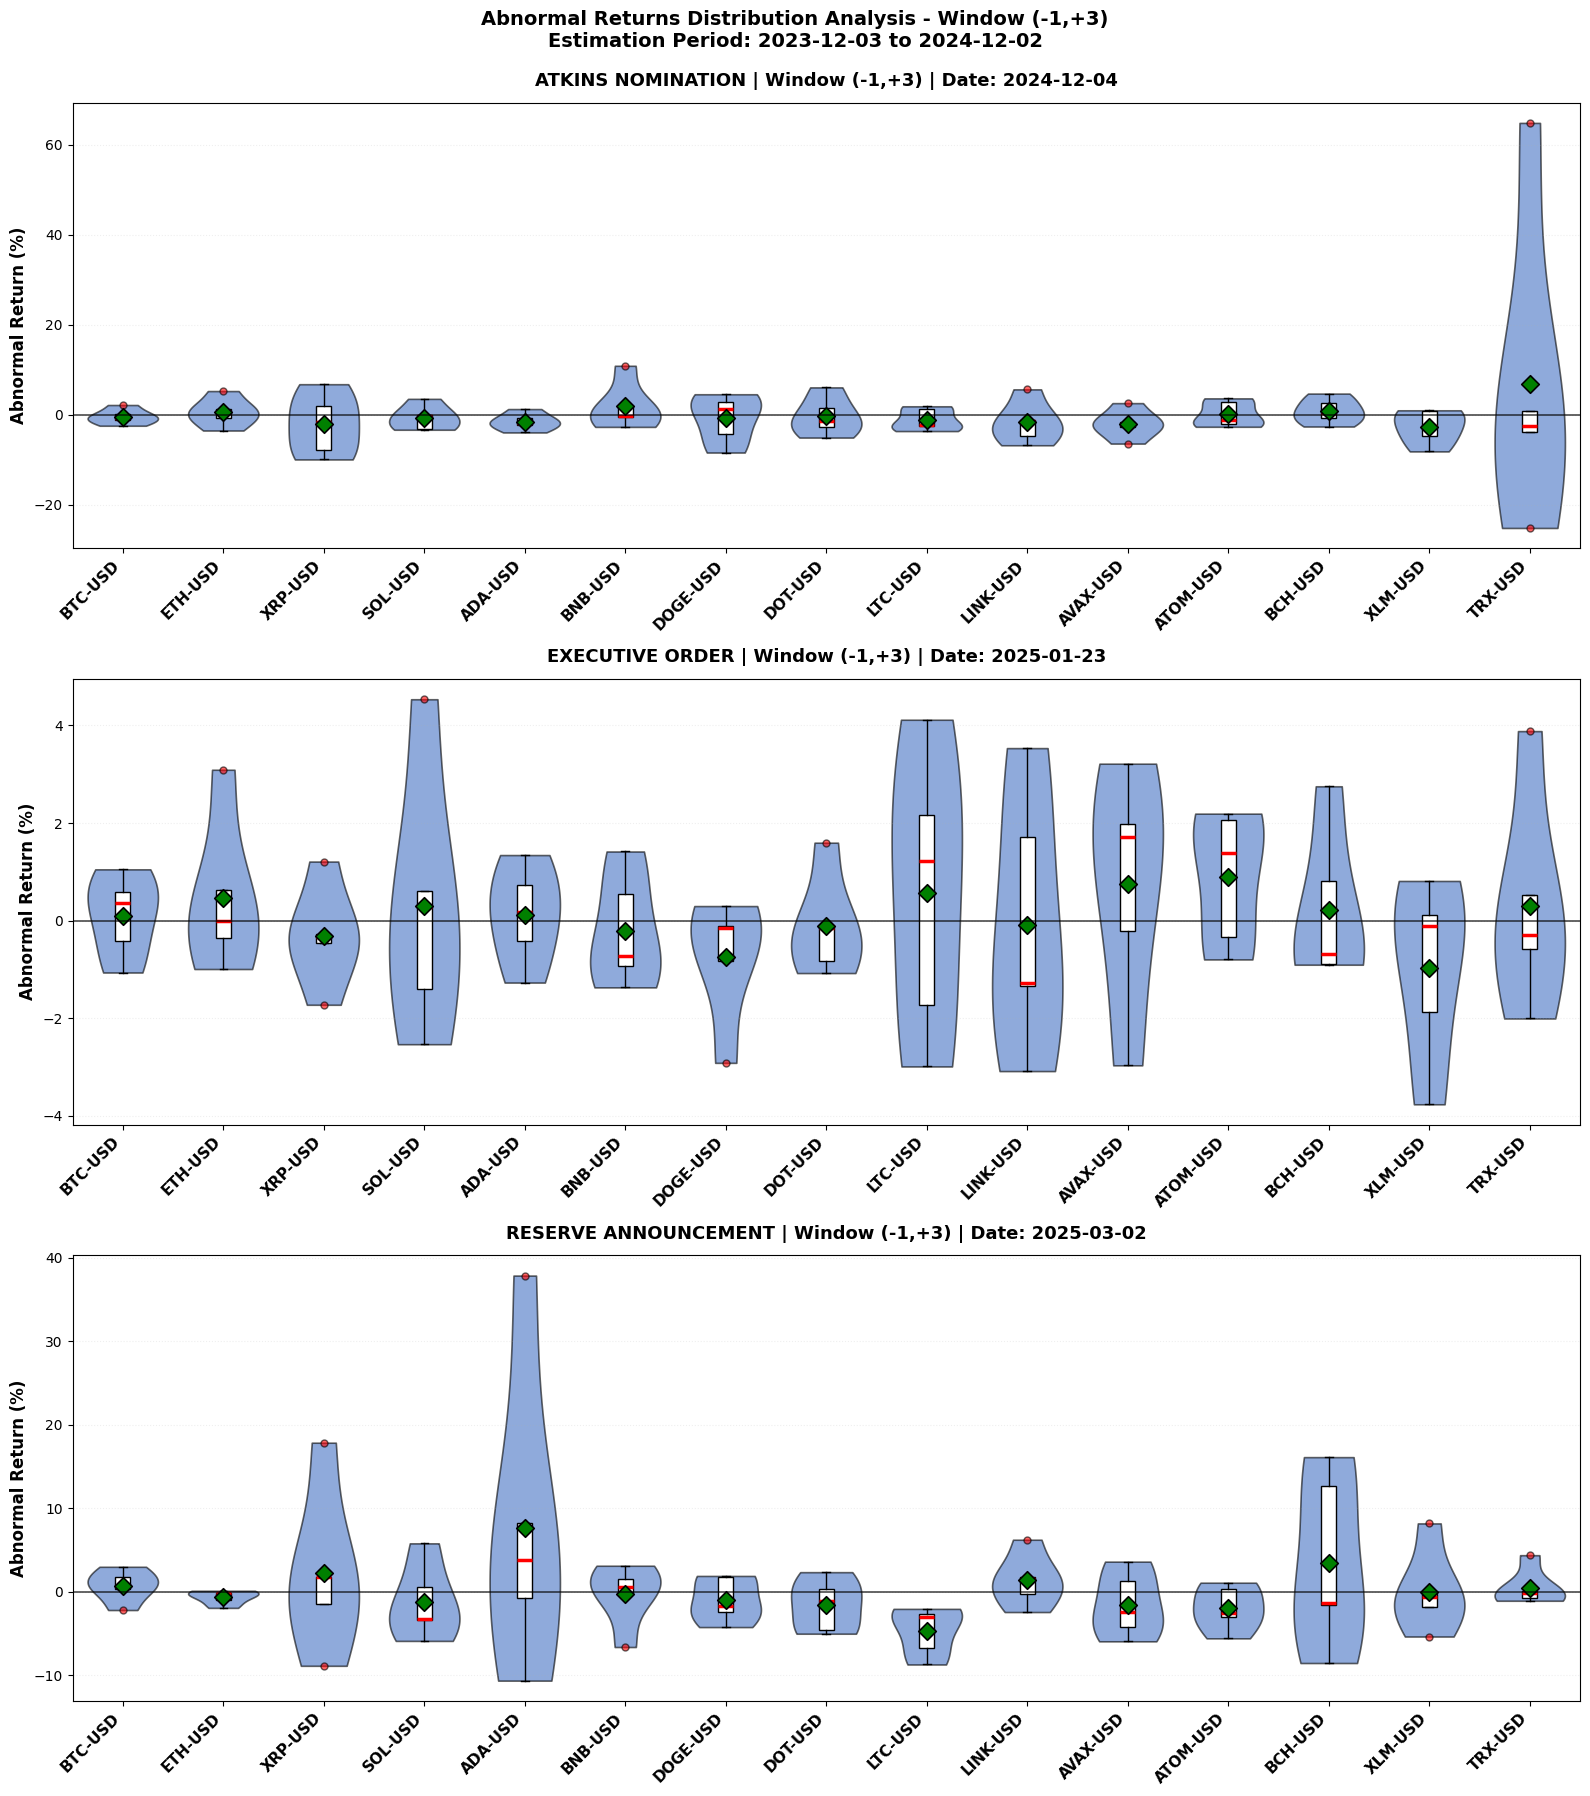


Plot 4: CAAR Comparison Across Events...
  Figure: CAAR Comparison


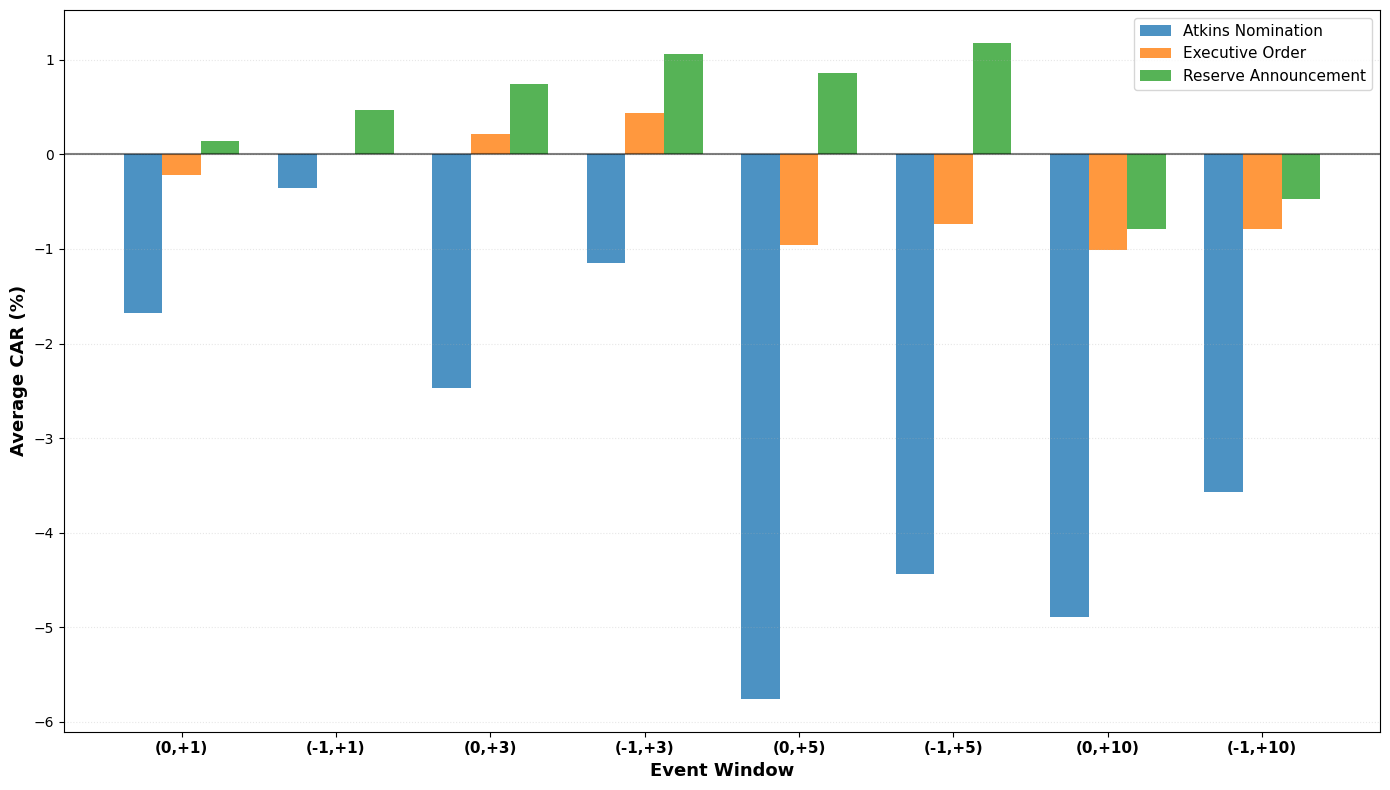


Plot 5: Risk-Return Analysis (Beta vs CAR)...
  Figure: Atkins Nomination - Risk-Return


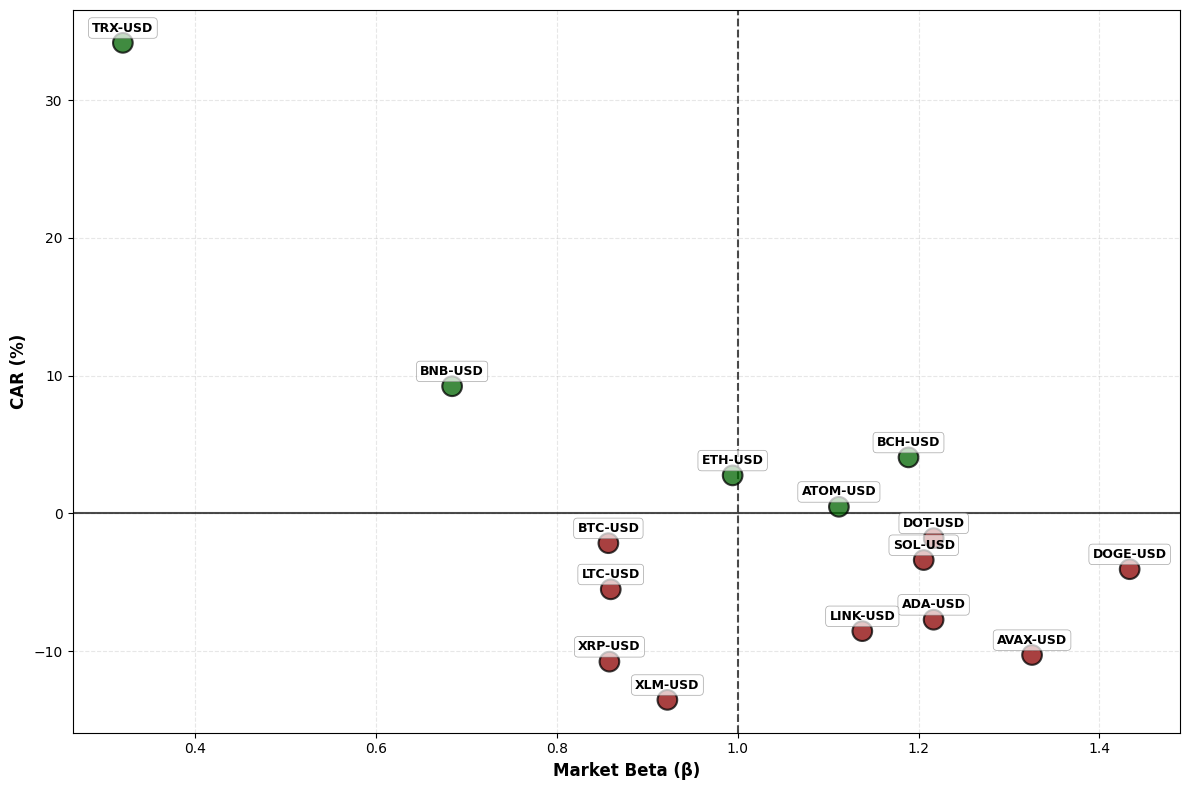

  Figure: Executive Order - Risk-Return


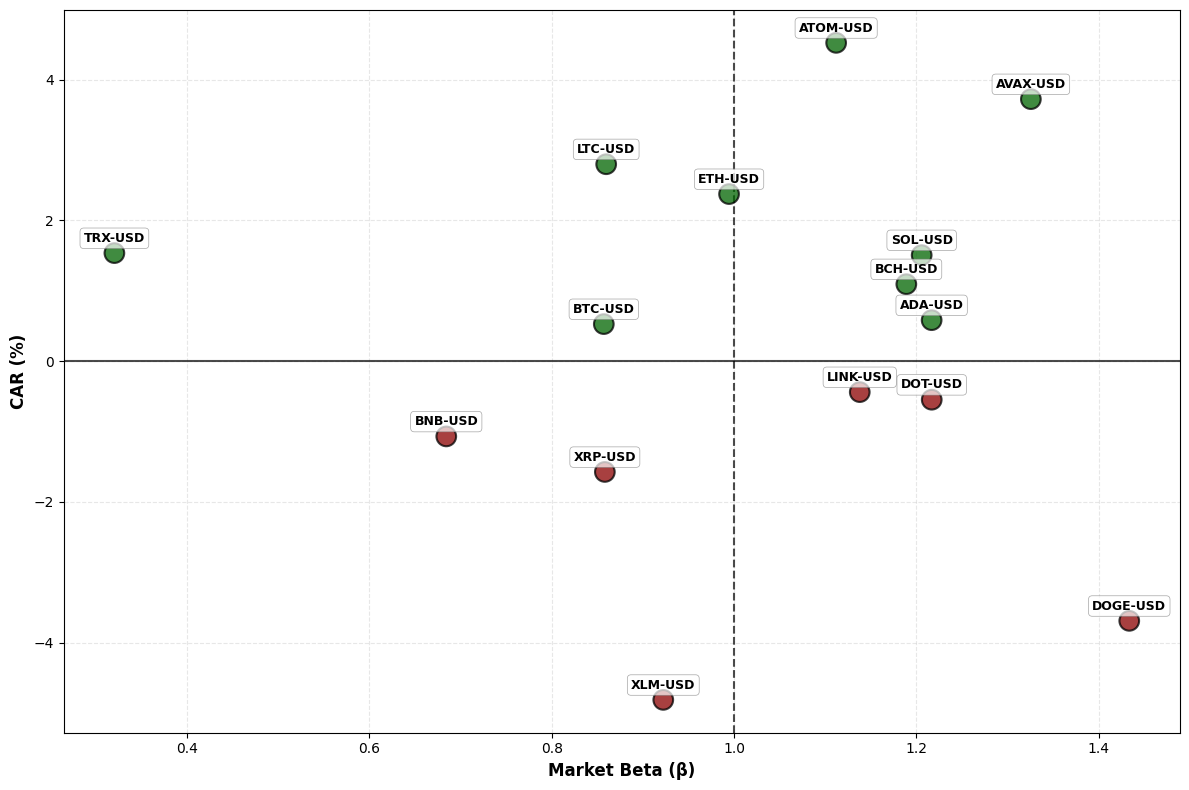

  Figure: Reserve Announcement - Risk-Return


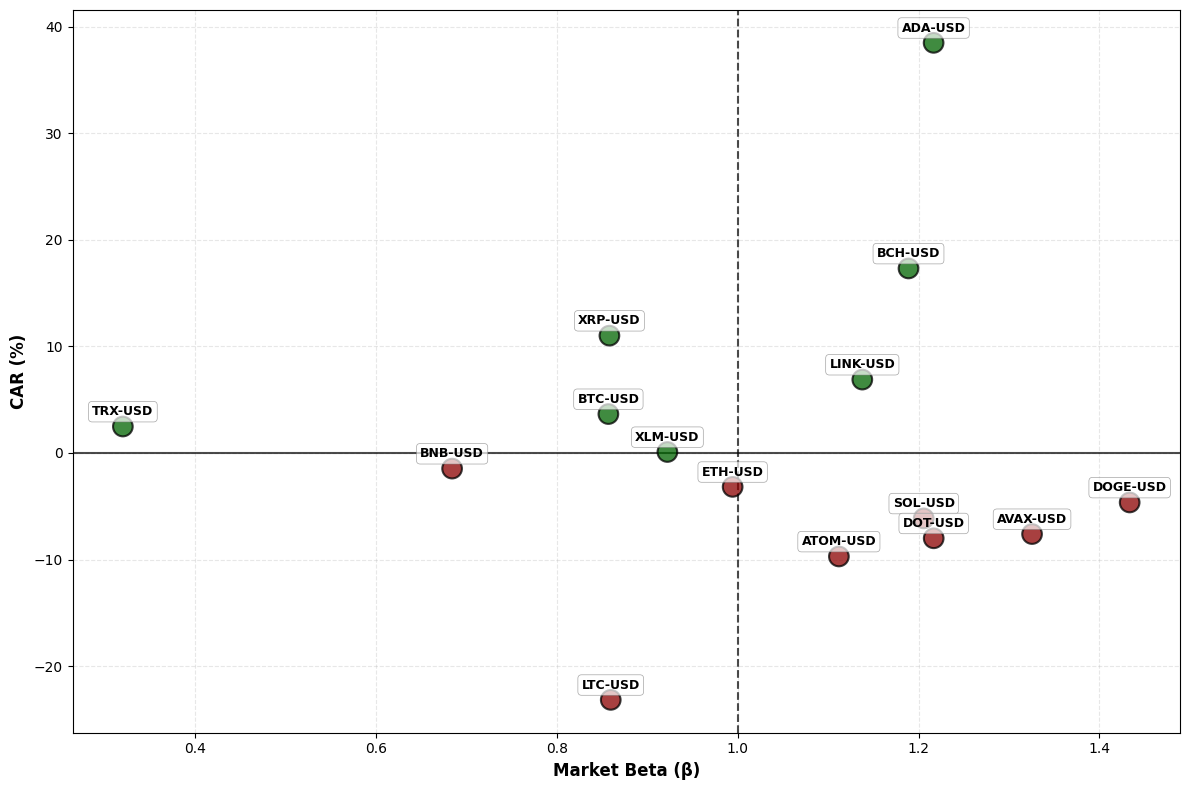


Plot 6: CAR Heatmap...
  Figure: CAR Heatmap


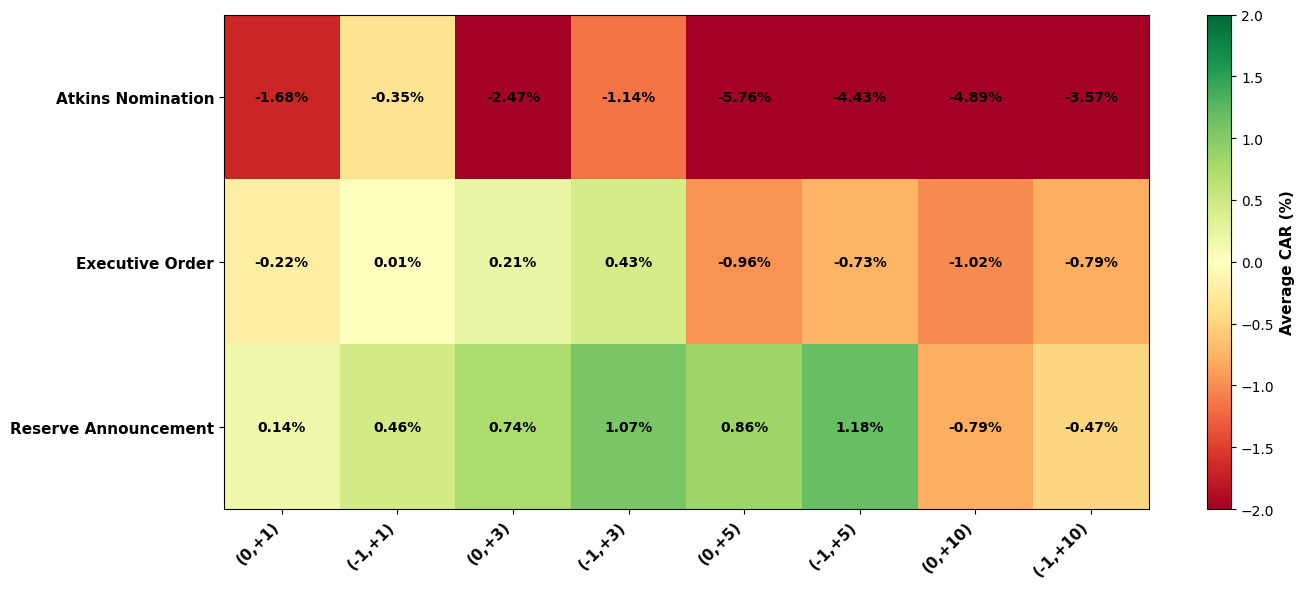


GENERATING WORD DOCUMENT WITH APPENDIX TABLES
✓ Word document saved: Cryptocurrency_Event_Study_Complete.docx

EVENT STUDY COMPLETE

Estimation Period (CORRECTED): 2023-12-03 to 2024-12-02
Event 1: Atkins Nomination - 2024-12-04
Event 2: Executive Order - 2025-01-23
Event 3: Reserve Announcement - 2025-03-02

Cryptourrencies analyzed: 15
Event windows: 8

Visualizations: 6 (Winners/Losers, Learning Curve, Violin Plots, CAAR Comparison, Risk-Return, Heatmap)
Word document: Cryptocurrency_Event_Study_Complete.docx


In [ ]:
# ================================================================================
# CRYPTOCURRENCY EVENT STUDY - TRUMP ADMINISTRATION POLICY INTERVENTIONS
# ================================================================================
# Complete Analysis | Corrected Dates: Dec 3, 2023 - Dec 2, 2024 (365 days)
# All plots displayed | Console output | Word document with tables
# ================================================================================

import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from docx import Document
from docx.shared import Inches, Pt
from docx.enum.text import WD_ALIGN_PARAGRAPH
from docx.oxml.ns import qn
from docx.oxml import OxmlElement
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100

# ================================================================================
# STEP 1: LOAD DATA AND CALCULATE LOG RETURNS
# ================================================================================
print("="*160)
print("CRYPTOCURRENCY EVENT STUDY - TRUMP ADMINISTRATION POLICY INTERVENTIONS")
print("="*160)
print("\nStep 1: Loading data and calculating log returns...")

file_path = "crypto event data .xlsx"
data = pd.read_excel(file_path)

date_col = None
for col_name in data.columns:
    if 'date' in col_name.lower() or 'time' in col_name.lower():
        date_col = col_name
        break
if date_col is None:
    date_col = data.columns[0]

data = data.rename(columns={date_col: 'Date'})
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values('Date').reset_index(drop=True)

cryptos = ['BTC-USD', 'ETH-USD', 'XRP-USD', 'SOL-USD', 'ADA-USD', 'BNB-USD',
           'DOGE-USD', 'DOT-USD', 'LTC-USD', 'LINK-USD', 'AVAX-USD', 'ATOM-USD',
           'BCH-USD', 'XLM-USD', 'TRX-USD']
market_index = 'CCi30 Index'

# Calculate log returns
returns = data[['Date']].copy()
for col in cryptos + [market_index]:
    returns[col] = np.log(data[col] / data[col].shift(1))
returns = returns.dropna().reset_index(drop=True)

for col in cryptos + [market_index]:
    returns[col] = pd.to_numeric(returns[col], errors='coerce')

print(f"✓ Data loaded: {len(returns)} observations")
print(f"✓ Cryptocurrencies: {len(cryptos)}")
print(f"✓ Date range: {returns['Date'].min().date()} to {returns['Date'].max().date()}")

# ================================================================================
# STEP 2: DEFINE 3 EVENTS
# ================================================================================
print("\nStep 2: Defining 3 events...")

event_dates = {
    "Atkins_Nomination": pd.to_datetime("2024-12-04"),
    "Executive_Order": pd.to_datetime("2025-01-23"),
    "Reserve_Announcement": pd.to_datetime("2025-03-02")
}

for event_name in event_dates.keys():
    nearest_idx = (returns['Date'] - event_dates[event_name]).abs().idxmin()
    actual_date = returns.loc[nearest_idx, 'Date']
    if event_dates[event_name] != actual_date:
        print(f"  {event_name}: adjusted to {actual_date.date()}")
    event_dates[event_name] = actual_date

print("\nEvent Dates:")
for ev_name, ev_date in event_dates.items():
    print(f"  {ev_name}: {ev_date.date()}")

# ================================================================================
# STEP 3: DEFINE EVENT WINDOWS
# ================================================================================
windows = {
    "(0,+1)": (0, 1),
    "(-1,+1)": (-1, 1),
    "(0,+3)": (0, 3),
    "(-1,+3)": (-1, 3),
    "(0,+5)": (0, 5),
    "(-1,+5)": (-1, 5),
    "(0,+10)": (0, 10),
    "(-1,+10)": (-1, 10)
}

display_windows = list(windows.keys())

# ================================================================================
# STEP 4: ESTIMATION PERIOD (CORRECTED: DEC 3, 2023 - DEC 2, 2024)
# ================================================================================
print("\nStep 4: Setting up 365-day estimation window (crypto calendar - 7 days/week)...")

# Fixed dates: Dec 3, 2023 - Dec 2, 2024 (365 days for crypto data)
estimation_start = pd.to_datetime("2023-12-03")
estimation_end = pd.to_datetime("2024-12-02")

# Find nearest available trading dates
est_start_idx = (returns['Date'] - estimation_start).abs().idxmin()
est_end_idx = (returns['Date'] - estimation_end).abs().idxmin()

estimation_start = returns.loc[est_start_idx, 'Date']
estimation_end = returns.loc[est_end_idx, 'Date']

estimation_data = returns.iloc[est_start_idx:est_end_idx + 1].copy()

for col in cryptos + [market_index]:
    estimation_data[col] = pd.to_numeric(estimation_data[col], errors='coerce')

print("="*160)
print("ESTIMATION PERIOD (365 DAYS - CRYPTO CALENDAR)")
print("="*160)
print(f"Start: {estimation_data['Date'].min().date()} | End: {estimation_data['Date'].max().date()} | Observations: {len(estimation_data)}")

# ================================================================================
# STEP 5: MARKET MODEL ESTIMATION
# ================================================================================
print("\n" + "="*160)
print("TABLE 1: MARKET MODEL PARAMETERS (365-Day Estimation)")
print("="*160)
print(f"{'Cryptocurrency':<20} {'Alpha':>15} {'Beta':>15} {'R²':>15} {'Std Error':>20}")
print("-"*160)

betas = {}
residual_vars = {}
market_model_results = []

for crypto in cryptos:
    X = sm.add_constant(estimation_data[market_index].values)
    y = estimation_data[crypto].values
    model = sm.OLS(y, X).fit()

    betas[crypto] = {
        "alpha": model.params[0],
        "beta": model.params[1]
    }
    residual_vars[crypto] = np.var(model.resid, ddof=2)

    market_model_results.append({
        'Cryptocurrency': crypto,
        'Alpha': betas[crypto]['alpha'],
        'Beta': betas[crypto]['beta'],
        'R_squared': model.rsquared,
        'Std_Error': np.sqrt(residual_vars[crypto])
    })

    print(f"{crypto:<20} {betas[crypto]['alpha']:>15.6f} {betas[crypto]['beta']:>15.4f} "
          f"{model.rsquared:>15.4f} {np.sqrt(residual_vars[crypto]):>20.6f}")

print("="*160)

# ================================================================================
# STEP 6: HELPER FUNCTIONS
# ================================================================================

def add_stars(p_value):
    if p_value < 0.01:
        return "***"
    elif p_value < 0.05:
        return "**"
    elif p_value < 0.10:
        return "*"
    return ""

def nearest_event_index(target_dt):
    return (returns['Date'] - target_dt).abs().idxmin()

def calculate_car_and_test(ar_series, residual_var, window_length):
    CAR = ar_series.sum()
    SE_CAR = np.sqrt(window_length * residual_var)
    df = max(len(estimation_data) - 2, 1)

    if SE_CAR <= 0:
        return CAR, 0.0, 1.0

    t_stat = CAR / SE_CAR
    p_value = 2 * (1 - stats.t.cdf(abs(t_stat), df=df))
    return CAR, t_stat, p_value

def cross_sectional_test(car_array):
    mean_caar = np.mean(car_array)
    std_caar = np.std(car_array, ddof=1)
    n = len(car_array)

    if std_caar <= 0:
        return mean_caar, 0.0, 1.0

    t_stat = mean_caar / (std_caar / np.sqrt(n))
    p_value = 2 * (1 - stats.t.cdf(abs(t_stat), df=n-1))
    return mean_caar, t_stat, p_value

# ================================================================================
# STEP 7: CALCULATE ABNORMAL RETURNS FOR ALL EVENTS
# ================================================================================
print("\n" + "="*160)
print("CALCULATING ABNORMAL RETURNS")
print("="*160 + "\n")

all_results = []
event_tables = {}

for event_name, event_date in event_dates.items():
    print(f"Processing {event_name}...")
    event_index = nearest_event_index(event_date)
    event_results = []

    for window_name, (start_day, end_day) in windows.items():
        start_idx = event_index + start_day
        end_idx = event_index + end_day

        if start_idx < 0 or end_idx >= len(returns):
            continue

        window_data = returns.iloc[start_idx:end_idx + 1].copy()
        window_length = len(window_data)

        if window_length <= 0:
            continue

        for col in cryptos + [market_index]:
            window_data[col] = pd.to_numeric(window_data[col], errors='coerce')

        for crypto in cryptos:
            expected_returns = betas[crypto]['alpha'] + betas[crypto]['beta'] * window_data[market_index].values
            abnormal_returns = window_data[crypto].values - expected_returns

            CAR, t_stat, p_value = calculate_car_and_test(
                abnormal_returns, residual_vars[crypto], window_length
            )

            event_results.append({
                'Event': event_name,
                'Window': window_name,
                'Cryptocurrency': crypto,
                'CAR': CAR,
                'CAR_pct': CAR * 100,
                't_stat': t_stat,
                'p_value': p_value,
                'significance': add_stars(p_value),
                'AR_array': abnormal_returns
            })

            all_results.append({
                'Event': event_name,
                'Window': window_name,
                'Cryptocurrency': crypto,
                'CAR': CAR,
                'CAR_pct': CAR * 100,
                't_stat': t_stat,
                'p_value': p_value,
                'significance': add_stars(p_value)
            })

    event_tables[event_name] = pd.DataFrame(event_results)

full_results = pd.DataFrame(all_results)

# ================================================================================
# STEP 8: PRINT COMPREHENSIVE EVENT STUDY TABLES TO CONSOLE
# ================================================================================

for table_num, (event_name, event_table) in enumerate(event_tables.items(), start=2):
    print("\n" + "="*200)
    print(f"TABLE {table_num}: {event_name.upper().replace('_', ' ')}")
    print("="*200)

    header = f"{'Cryptocurrency':<20}"
    for w in display_windows:
        header += f" {w:>22}"
    print(header)
    print("-"*200)

    for crypto in cryptos:
        crypto_data = event_table[event_table['Cryptocurrency'] == crypto]
        row = f"{crypto:<20}"

        for window in display_windows:
            window_row = crypto_data[crypto_data['Window'] == window]
            if len(window_row) > 0:
                r = window_row.iloc[0]
                cell = f"{r['CAR_pct']:>6.2f}% (t={r['t_stat']:>5.2f}){r['significance']}"
                row += f" {cell:>22}"
            else:
                row += f" {'N/A':>22}"
        print(row)

    print("-"*200)
    row = f"{'CAAR':<20}"

    for window in display_windows:
        window_data = event_table[event_table['Window'] == window]
        if len(window_data) > 0:
            car_array = window_data['CAR'].values
            mean_caar, cs_t, cs_p = cross_sectional_test(car_array)
            cell = f"{mean_caar*100:>6.2f}% (t={cs_t:>5.2f}){add_stars(cs_p)}"
            row += f" {cell:>22}"
        else:
            row += f" {'N/A':>22}"
    print(row)
    print("="*200)

# ================================================================================
# STEP 9: CROSS-EVENT SUMMARY
# ================================================================================

print("\n" + "="*160)
print("CROSS-EVENT SUMMARY")
print("="*160)
print(f"{'Window':<15} {'Atkins':>35} {'Executive Order':>35} {'Reserve Announcement':>35}")
print("-"*160)

summary_for_word = []
for window in display_windows:
    row_text = f"{window:<15}"
    row_data = {'Window': window}

    for event_name in event_dates.keys():
        event_window = full_results[(full_results['Event'] == event_name) & (full_results['Window'] == window)]

        if len(event_window) > 0:
            car_array = event_window['CAR'].values
            mean_caar, cs_t, cs_p = cross_sectional_test(car_array)
            cell = f"{mean_caar*100:>6.2f}% (t={cs_t:>5.2f}){add_stars(cs_p)}"
            row_text += f" {cell:>35}"
            row_data[event_name] = {'CAAR': mean_caar*100, 't_stat': cs_t, 'p_val': cs_p}
        else:
            row_text += f" {'N/A':>35}"

    print(row_text)
    summary_for_word.append(row_data)

print("="*160)

# ================================================================================
# STEP 10: SECTOR CHARACTERISTICS TABLE
# ================================================================================

print("\n" + "="*160)
print("TABLE 6: CRYPTOCURRENCY CHARACTERISTICS")
print("="*160)
print(f"{'Cryptocurrency':<20} {'Beta':>12} {'Event1_CAR':>15} {'Event2_CAR':>15} {'Event3_CAR':>15}")
print("-"*160)

sector_sensitivity = []
for crypto in cryptos:
    beta_val = betas[crypto]['beta']
    row_text = f"{crypto:<20} {beta_val:>12.4f}"
    row_data = {'Cryptocurrency': crypto, 'Beta': beta_val}

    for event_name in event_dates.keys():
        event_data = full_results[
            (full_results['Event'] == event_name) &
            (full_results['Window'] == '(-1,+3)') &
            (full_results['Cryptocurrency'] == crypto)
        ]

        if len(event_data) > 0:
            r = event_data.iloc[0]
            cell = f"{r['CAR']*100:>6.2f}%{r['significance']}"
            row_text += f" {cell:>15}"
            row_data[f'{event_name}_CAR'] = r['CAR'] * 100

    print(row_text)
    sector_sensitivity.append(row_data)

print("-"*160)

# ================================================================================
# VISUALIZATIONS START
# ================================================================================

print("\n" + "="*160)
print("GENERATING VISUALIZATIONS")
print("="*160)

event_colors = {
    "Atkins_Nomination": "#e74c3c",
    "Executive_Order": "#3498db",
    "Reserve_Announcement": "#2ecc71"
}

# ================================================================================
# PLOT 1: WINNERS/LOSERS - ALL EVENTS (3x3 GRID, 8 WINDOWS EACH)
# ================================================================================

print("\nPlot 1: Event Study Results (Winners/Losers)...")

for event_num, (event_name, event_table) in enumerate(event_tables.items(), start=1):
    fig, axes = plt.subplots(2, 4, figsize=(28, 14), dpi=100)
    axes = axes.flatten()

    for window_idx, window in enumerate(display_windows):
        ax = axes[window_idx]

        window_data = event_table[event_table['Window'] == window].sort_values('CAR_pct')

        if len(window_data) == 0:
            ax.text(0.5, 0.5, f'No data', ha='center', va='center', fontsize=12, transform=ax.transAxes)
            continue

        colors = []
        for idx, row in window_data.iterrows():
            if row['p_value'] < 0.01:
                colors.append('#8B0000' if row['CAR_pct'] < 0 else '#006400')
            elif row['p_value'] < 0.05:
                colors.append('#DC143C' if row['CAR_pct'] < 0 else '#32CD32')
            elif row['p_value'] < 0.10:
                colors.append('#FF6347' if row['CAR_pct'] < 0 else '#90EE90')
            else:
                colors.append('#FFB6C6' if row['CAR_pct'] < 0 else '#D3F5D3')

        y_pos = np.arange(len(window_data))
        bars = ax.barh(y_pos, window_data['CAR_pct'].values, color=colors, alpha=0.85, edgecolor='black', linewidth=1)

        for i, (idx, row) in enumerate(window_data.iterrows()):
            label_x = row['CAR_pct'] + (0.2 if row['CAR_pct'] > 0 else -0.2)
            ax.text(label_x, i, row['significance'], ha='left' if row['CAR_pct'] > 0 else 'right',
                   va='center', fontweight='bold', fontsize=12)

        ax.set_yticks(y_pos)
        ax.set_yticklabels(window_data['Cryptocurrency'].values, fontsize=10, fontweight='bold')
        ax.axvline(0, color='black', linewidth=2.5, alpha=0.8)
        ax.set_xlabel('CAR (%)', fontweight='bold', fontsize=12)
        ax.set_title(f'{window}', fontsize=13, fontweight='bold', pad=12)
        ax.grid(True, alpha=0.4, axis='x', linestyle='--', linewidth=0.8)

    plt.tight_layout()
    print(f"  Figure: {event_name.replace('_', ' ')} - Winners/Losers")
    plt.show()

# ================================================================================
# PLOT 2: LEARNING CURVE - CUMULATIVE ABNORMAL RETURNS OVER TIME
# ================================================================================

print("\nPlot 2: Learning Curve (CAR Timeline)...")

first_event = list(event_dates.values())[0]
last_event = list(event_dates.values())[-1]
plot_start = first_event - pd.tseries.offsets.Day(60)
plot_end = last_event + pd.tseries.offsets.Day(60)

plot_data = returns[(returns['Date'] >= plot_start) & (returns['Date'] <= plot_end)].copy()

crypto_colors = {
    'BTC-USD': '#F7931A', 'ETH-USD': '#627EEA', 'XRP-USD': '#23292F', 'SOL-USD': '#14F195',
    'ADA-USD': '#0033F0', 'BNB-USD': '#F3BA2F', 'DOGE-USD': '#BA9F33', 'DOT-USD': '#E6007A',
    'LTC-USD': '#345D9D', 'LINK-USD': '#2A5ADA', 'AVAX-USD': '#E84142', 'ATOM-USD': '#6F0066',
    'BCH-USD': '#8DC451', 'XLM-USD': '#001A70', 'TRX-USD': '#EB0029'
}

car_data = {}

for crypto in cryptos:
    ar_list = []

    for idx in range(len(plot_data)):
        date_val = plot_data.iloc[idx]['Date']
        abs_idx = (returns['Date'] - date_val).abs().idxmin()

        if abs_idx >= 0 and abs_idx < len(returns):
            expected_return = betas[crypto]['alpha'] + betas[crypto]['beta'] * returns.loc[abs_idx, market_index]
            actual_return = returns.loc[abs_idx, crypto]
            ar = actual_return - expected_return
            ar_list.append(ar)
        else:
            ar_list.append(np.nan)

    ar_array = np.array(ar_list)
    car_data[crypto] = np.cumsum(ar_array) * 100

avg_car = np.mean([car_data[c] for c in cryptos], axis=0)

fig, ax = plt.subplots(figsize=(18, 9), dpi=100)

for crypto in cryptos:
    color = crypto_colors.get(crypto, '#808080')
    ax.plot(plot_data['Date'], car_data[crypto], alpha=0.7, linewidth=1.5, label=crypto, color=color)

ax.plot(plot_data['Date'], avg_car, color='black', linewidth=4, label='Average CAR (All Cryptos)', zorder=100)

y_limits = ax.get_ylim()
y_position = y_limits[1] * 0.90

for event_name, event_date in event_dates.items():
    color = event_colors[event_name]
    ax.axvline(event_date, color=color, linestyle='--', linewidth=2.5, alpha=0.85, zorder=50)

ax.axhline(0, color='black', linestyle='-', linewidth=1.2, alpha=0.6, zorder=10)
ax.set_xlabel('Date', fontsize=14, fontweight='bold')
ax.set_ylabel('Cumulative Abnormal Return (%)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.25, linestyle=':', linewidth=0.8)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right', fontsize=10)
ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=10, framealpha=0.95)

plt.tight_layout()
print("  Figure: Learning Curve - Individual Cryptocurrency Colors")
plt.show()

# ================================================================================
# PLOT 3: VIOLIN PLOTS - DISTRIBUTION OF ABNORMAL RETURNS
# ================================================================================

print("\nPlot 3: Violin Plots (Distribution Analysis)...")

fig, axes = plt.subplots(3, 1, figsize=(16, 18), dpi=100)

for event_idx, (event_name, event_date) in enumerate(event_dates.items()):
    ax = axes[event_idx]

    event_index = nearest_event_index(event_date)
    start_day, end_day = windows['(-1,+3)']
    start_idx = event_index + start_day
    end_idx = event_index + end_day

    if start_idx < 0 or end_idx >= len(returns):
        continue

    window_data = returns.iloc[start_idx:end_idx + 1].copy()

    ar_by_crypto = []
    crypto_labels = []

    for crypto in cryptos:
        expected_returns = betas[crypto]['alpha'] + betas[crypto]['beta'] * window_data[market_index].values
        abnormal_returns = window_data[crypto].values - expected_returns
        ar_values = abnormal_returns * 100

        ar_by_crypto.append(ar_values)
        crypto_labels.append(crypto)

    if len(ar_by_crypto) > 0:
        positions = np.arange(len(ar_by_crypto))

        parts = ax.violinplot(ar_by_crypto, positions=positions, widths=0.7,
                              showmeans=False, showmedians=False, showextrema=False)

        for pc in parts['bodies']:
            pc.set_facecolor('#4472C4')
            pc.set_alpha(0.6)
            pc.set_edgecolor('black')
            pc.set_linewidth(1.2)

        bp = ax.boxplot(ar_by_crypto, positions=positions, widths=0.15,
                        patch_artist=True, showfliers=True,
                        boxprops=dict(facecolor='white', edgecolor='black', linewidth=1),
                        whiskerprops=dict(color='black', linewidth=1),
                        capprops=dict(color='black', linewidth=1),
                        medianprops=dict(color='red', linewidth=2.5),
                        flierprops=dict(marker='o', markerfacecolor='red', markersize=5, alpha=0.6))

        means = [np.mean(ar) for ar in ar_by_crypto]
        ax.scatter(positions, means, marker='D', s=80, color='green',
                  edgecolors='black', linewidth=1.2, zorder=3, label='Mean')

        ax.set_xticks(positions)
        ax.set_xticklabels(crypto_labels, fontsize=11, fontweight='bold', rotation=45, ha='right')
        ax.set_ylabel('Abnormal Return (%)', fontsize=12, fontweight='bold')
        ax.set_title(f'{event_name.replace("_", " ").upper()} | Window (-1,+3) | Date: {event_date.date()}',
                    fontsize=13, fontweight='bold', pad=12)
        ax.axhline(0, color='black', linestyle='-', linewidth=1.2, alpha=0.7, zorder=10)
        ax.grid(True, alpha=0.2, axis='y', linestyle=':', linewidth=0.8)

plt.suptitle(f'Abnormal Returns Distribution Analysis - Window (-1,+3)\nEstimation Period: {estimation_start.date()} to {estimation_end.date()}',
            fontsize=14, fontweight='bold', y=0.995)

plt.tight_layout()
print("  Figure: Violin Plots")
plt.show()

# ================================================================================
# PLOT 4: CAAR COMPARISON - ACROSS EVENTS
# ================================================================================

print("\nPlot 4: CAAR Comparison Across Events...")

caar_data = []
for window in display_windows:
    for event_name in event_dates.keys():
        event_window = full_results[(full_results['Event'] == event_name) & (full_results['Window'] == window)]

        if len(event_window) > 0:
            car_array = event_window['CAR'].values
            mean_caar, cs_t, cs_p = cross_sectional_test(car_array)
            caar_data.append({
                'Window': window,
                'Event': event_name.replace('_', ' '),
                'CAAR': mean_caar * 100
            })

caar_df = pd.DataFrame(caar_data)

fig, ax = plt.subplots(figsize=(14, 8), dpi=100)

x = np.arange(len(display_windows))
width = 0.25

for event_idx, event_name in enumerate(event_dates.keys()):
    event_caars = caar_df[caar_df['Event'] == event_name.replace('_', ' ')]['CAAR'].values
    ax.bar(x + event_idx * width, event_caars, width, label=event_name.replace('_', ' '), alpha=0.8)

ax.set_xlabel('Event Window', fontsize=13, fontweight='bold')
ax.set_ylabel('Average CAR (%)', fontsize=13, fontweight='bold')
ax.set_xticks(x + width)
ax.set_xticklabels(display_windows, fontsize=11, fontweight='bold')
ax.axhline(0, color='black', linewidth=1.5, linestyle='-', alpha=0.5)
ax.legend(fontsize=11, frameon=True, fancybox=True)
ax.grid(True, alpha=0.3, axis='y', linestyle=':', linewidth=0.8)

plt.tight_layout()
print("  Figure: CAAR Comparison")
plt.show()

# ================================================================================
# PLOT 5: RISK-RETURN SCATTER
# ================================================================================

print("\nPlot 5: Risk-Return Analysis (Beta vs CAR)...")

for event_name in event_dates.keys():
    fig, ax = plt.subplots(figsize=(12, 8), dpi=100)

    event_data = full_results[(full_results['Event'] == event_name) & (full_results['Window'] == '(-1,+3)')]

    beta_values = [betas[c]['beta'] for c in event_data['Cryptocurrency']]
    car_values = event_data['CAR'].values * 100

    colors = ['#006400' if c > 0 else '#8B0000' for c in car_values]

    ax.scatter(beta_values, car_values, c=colors, s=200, alpha=0.75, edgecolors='black', linewidths=1.5, zorder=3)

    for crypto, beta, car in zip(event_data['Cryptocurrency'], beta_values, car_values):
        label = crypto if len(crypto) <= 12 else crypto[:10]
        ax.annotate(label, (beta, car), fontsize=9, ha='center', va='bottom', fontweight='bold',
                   xytext=(0, 6), textcoords='offset points',
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7, edgecolor='gray', linewidth=0.5))

    ax.axhline(0, color='black', linewidth=1.5, alpha=0.7)
    ax.axvline(1, color='black', linewidth=1.5, alpha=0.7, linestyle='--')

    ax.set_xlabel('Market Beta (β)', fontweight='bold', fontsize=12)
    ax.set_ylabel('CAR (%)', fontweight='bold', fontsize=12)
    ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.8)

    plt.tight_layout()
    print(f"  Figure: {event_name.replace('_', ' ')} - Risk-Return")
    plt.show()

# ================================================================================
# PLOT 6: HEATMAP
# ================================================================================

print("\nPlot 6: CAR Heatmap...")

heatmap_data = []
for event_name in event_dates.keys():
    row = []
    for window in display_windows:
        event_window = full_results[(full_results['Event'] == event_name) & (full_results['Window'] == window)]

        if len(event_window) > 0:
            car_array = event_window['CAR'].values
            mean_caar, _, _ = cross_sectional_test(car_array)
            row.append(mean_caar * 100)
        else:
            row.append(0)
    heatmap_data.append(row)

heatmap_array = np.array(heatmap_data)

fig, ax = plt.subplots(figsize=(14, 6), dpi=100)

im = ax.imshow(heatmap_array, cmap='RdYlGn', aspect='auto', vmin=-2, vmax=2)

ax.set_xticks(np.arange(len(display_windows)))
ax.set_yticks(np.arange(len(event_dates)))
ax.set_xticklabels(display_windows, fontsize=11, fontweight='bold')
ax.set_yticklabels([e.replace('_', ' ') for e in event_dates.keys()], fontsize=11, fontweight='bold')

plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

for i in range(len(event_dates)):
    for j in range(len(display_windows)):
        text = ax.text(j, i, f'{heatmap_array[i, j]:.2f}%', ha="center", va="center", color="black", fontweight='bold', fontsize=10)

cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Average CAR (%)', fontweight='bold', fontsize=11)

plt.tight_layout()
print("  Figure: CAR Heatmap")
plt.show()

# ================================================================================
# WORD DOCUMENT GENERATION
# ================================================================================

print("\n" + "="*160)
print("GENERATING WORD DOCUMENT WITH APPENDIX TABLES")
print("="*160)

def set_table_borders(table):
    for row_idx, row in enumerate(table.rows):
        for cell in row.cells:
            tcPr = cell._element.get_or_add_tcPr()
            tcBorders = OxmlElement('w:tcBorders')

            if row_idx == 0:
                top = OxmlElement('w:top')
                top.set(qn('w:val'), 'single')
                top.set(qn('w:sz'), '24')
                top.set(qn('w:space'), '0')
                top.set(qn('w:color'), '000000')
                tcBorders.append(top)

            if row_idx == len(table.rows) - 1:
                bottom = OxmlElement('w:bottom')
                bottom.set(qn('w:val'), 'single')
                bottom.set(qn('w:sz'), '24')
                bottom.set(qn('w:space'), '0')
                bottom.set(qn('w:color'), '000000')
                tcBorders.append(bottom)

            tcPr.append(tcBorders)

doc = Document()

title = doc.add_heading('Cryptocurrency Event Study', 0)
title.alignment = WD_ALIGN_PARAGRAPH.CENTER

subtitle = doc.add_heading('Impact of U.S. Policy Interventions Under the Trump Administration on Cryptocurrency Market Performance', level=2)
subtitle.alignment = WD_ALIGN_PARAGRAPH.CENTER

doc.add_heading('Executive Summary', level=1)
summary = doc.add_paragraph()
summary.add_run('Methodology: ').bold = True
summary.add_run('Event study using market model\n')
summary.add_run('Sample: ').bold = True
summary.add_run(f'{len(cryptos)} cryptocurrencies, {len(event_dates)} policy events\n')
summary.add_run('Estimation Window: ').bold = True
summary.add_run(f'365 days ({len(estimation_data)} observations)\n')
summary.add_run('Estimation Period: ').bold = True
summary.add_run(f'{estimation_start.date()} to {estimation_end.date()}\n')
summary.add_run('Event Windows: ').bold = True
summary.add_run('8 windows from (0,+1) to (-1,+10)\n')

doc.add_heading('Event Definitions', level=1)
for ev_name, ev_date in event_dates.items():
    p = doc.add_paragraph(style='List Bullet')
    p.add_run(f'{ev_name.replace("_", " ")}: ').bold = True
    p.add_run(f'{ev_date.date()}')

doc.add_page_break()

# TABLE 1: Market Model Parameters
doc.add_heading('Appendix Table 1: Market Model Parameters (365-Day Estimation)', level=1)

table1 = doc.add_table(rows=len(cryptos) + 1, cols=5)
table1.style = 'Table Grid'

hdr = table1.rows[0].cells
headers = ['Cryptocurrency', 'Alpha', 'Beta', 'R²', 'Std Error']
for i, h in enumerate(headers):
    hdr[i].text = h
    hdr[i].paragraphs[0].runs[0].font.bold = True
    hdr[i].paragraphs[0].alignment = WD_ALIGN_PARAGRAPH.CENTER

for row_idx, result in enumerate(market_model_results, start=1):
    row = table1.rows[row_idx].cells
    row[0].text = result['Cryptocurrency']
    row[1].text = f"{result['Alpha']:.6f}"
    row[2].text = f"{result['Beta']:.4f}"
    row[3].text = f"{result['R_squared']:.4f}"
    row[4].text = f"{result['Std_Error']:.6f}"

    for cell in row:
        cell.paragraphs[0].alignment = WD_ALIGN_PARAGRAPH.CENTER

set_table_borders(table1)

note1 = doc.add_paragraph()
note1.add_run('Note: ').bold = True
note1.add_run('Market model: R_i = α + β*R_market + ε. Estimated over 365-day estimation period (Dec 3, 2023 - Dec 2, 2024).')

doc.add_page_break()

# TABLES 2-4: Event Results
for table_num, (event_name, event_table) in enumerate(event_tables.items(), start=2):
    doc.add_heading(f'Appendix Table {table_num}: {event_name.replace("_", " ")}', level=1)

    n_cols = len(display_windows) + 1
    table = doc.add_table(rows=len(cryptos) + 2, cols=n_cols)
    table.style = 'Table Grid'

    hdr = table.rows[0].cells
    hdr[0].text = 'Cryptocurrency'
    hdr[0].paragraphs[0].runs[0].font.bold = True
    for i, w in enumerate(display_windows, start=1):
        hdr[i].text = w
        hdr[i].paragraphs[0].runs[0].font.bold = True
        hdr[i].paragraphs[0].alignment = WD_ALIGN_PARAGRAPH.CENTER

    for row_idx, crypto in enumerate(cryptos, start=1):
        crypto_data = event_table[event_table['Cryptocurrency'] == crypto]
        row = table.rows[row_idx].cells
        row[0].text = crypto

        for col_idx, window in enumerate(display_windows, start=1):
            window_row = crypto_data[crypto_data['Window'] == window]
            if len(window_row) > 0:
                r = window_row.iloc[0]
                row[col_idx].text = f"{r['CAR_pct']:.2f}% (t={r['t_stat']:.2f}){r['significance']}"
            else:
                row[col_idx].text = 'N/A'
            row[col_idx].paragraphs[0].alignment = WD_ALIGN_PARAGRAPH.CENTER

    caar_row = table.rows[len(cryptos) + 1].cells
    caar_row[0].text = 'CAAR'
    caar_row[0].paragraphs[0].runs[0].font.bold = True

    for col_idx, window in enumerate(display_windows, start=1):
        window_data = event_table[event_table['Window'] == window]
        if len(window_data) > 0:
            car_array = window_data['CAR'].values
            mean_caar, cs_t, cs_p = cross_sectional_test(car_array)
            caar_row[col_idx].text = f"{mean_caar*100:.2f}% (t={cs_t:.2f}){add_stars(cs_p)}"
        else:
            caar_row[col_idx].text = 'N/A'
        caar_row[col_idx].paragraphs[0].runs[0].font.bold = True
        caar_row[col_idx].paragraphs[0].alignment = WD_ALIGN_PARAGRAPH.CENTER

    set_table_borders(table)

    note = doc.add_paragraph()
    note.add_run('Note: ').bold = True
    note.add_run(f'CAR = Cumulative Abnormal Return. CAAR = Cross-sectional Average CAR. Significance: *** p<0.01, ** p<0.05, * p<0.10')

    doc.add_page_break()

# TABLE 5: Cross-Event Summary
doc.add_heading('Appendix Table 5: Cross-Event Summary', level=1)

summary_table = doc.add_table(rows=len(display_windows) + 1, cols=4)
summary_table.style = 'Table Grid'

hdr = summary_table.rows[0].cells
hdr[0].text = 'Window'
hdr[0].paragraphs[0].runs[0].font.bold = True
for i, ev in enumerate(['Atkins', 'Executive Order', 'Reserve'], start=1):
    hdr[i].text = ev
    hdr[i].paragraphs[0].runs[0].font.bold = True
    hdr[i].paragraphs[0].alignment = WD_ALIGN_PARAGRAPH.CENTER

for row_idx, stat in enumerate(summary_for_word, start=1):
    row = summary_table.rows[row_idx].cells
    row[0].text = stat['Window']

    for col_idx, event_name in enumerate(event_dates.keys(), start=1):
        if event_name in stat and stat[event_name]:
            caar = stat[event_name]['CAAR']
            t_val = stat[event_name]['t_stat']
            p_val = stat[event_name]['p_val']
            row[col_idx].text = f"{caar:.2f}% ({t_val:.2f}){add_stars(p_val)}"
        else:
            row[col_idx].text = 'N/A'
        row[col_idx].paragraphs[0].alignment = WD_ALIGN_PARAGRAPH.CENTER

set_table_borders(summary_table)

doc.add_page_break()

# TABLE 6: Cryptocurrency Characteristics
doc.add_heading('Appendix Table 6: Cryptocurrency Characteristics (Beta and Window (-1,+3) CAR)', level=1)

char_table = doc.add_table(rows=len(cryptos) + 1, cols=5)
char_table.style = 'Table Grid'

hdr = char_table.rows[0].cells
hdr[0].text = 'Cryptocurrency'
hdr[0].paragraphs[0].runs[0].font.bold = True
hdr[1].text = 'Beta'
hdr[1].paragraphs[0].runs[0].font.bold = True
for i, ev in enumerate(['Atkins', 'Executive Order', 'Reserve'], start=2):
    hdr[i].text = ev
    hdr[i].paragraphs[0].runs[0].font.bold = True
    hdr[i].paragraphs[0].alignment = WD_ALIGN_PARAGRAPH.CENTER

for row_idx, s_data in enumerate(sector_sensitivity, start=1):
    row = char_table.rows[row_idx].cells
    row[0].text = s_data['Cryptocurrency']
    row[1].text = f"{s_data['Beta']:.4f}"
    row[1].paragraphs[0].alignment = WD_ALIGN_PARAGRAPH.CENTER

    for col_idx, event_name in enumerate(event_dates.keys(), start=2):
        key = f'{event_name}_CAR'
        if key in s_data:
            row[col_idx].text = f"{s_data[key]:.2f}%"
        else:
            row[col_idx].text = 'N/A'
        row[col_idx].paragraphs[0].alignment = WD_ALIGN_PARAGRAPH.CENTER

set_table_borders(char_table)

output_file = 'Cryptocurrency_Event_Study_Complete.docx'
doc.save(output_file)

print(f"✓ Word document saved: {output_file}")

# ================================================================================
# FINAL SUMMARY
# ================================================================================

print(f"\n{'='*160}")
print("EVENT STUDY COMPLETE")
print(f"{'='*160}")
print(f"\nEstimation Period (CORRECTED): {estimation_start.date()} to {estimation_end.date()}")
print(f"Event 1: Atkins Nomination - {event_dates['Atkins_Nomination'].date()}")
print(f"Event 2: Executive Order - {event_dates['Executive_Order'].date()}")
print(f"Event 3: Reserve Announcement - {event_dates['Reserve_Announcement'].date()}")
print(f"\nCryptourrencies analyzed: {len(cryptos)}")
print(f"Event windows: {len(windows)}")
print(f"\nVisualizations: 6 (Winners/Losers, Learning Curve, Violin Plots, CAAR Comparison, Risk-Return, Heatmap)")
print(f"Word document: {output_file}")
print(f"{'='*160}")

RETURNS PLOT SPECIFICATIONS
Estimation Period: 2023-12-03 to 2024-12-02
Plot Period: 2023-12-03 to 2025-03-14
First Event: 2024-12-04
Last Event: 2025-03-02
Plot Data Points: 468


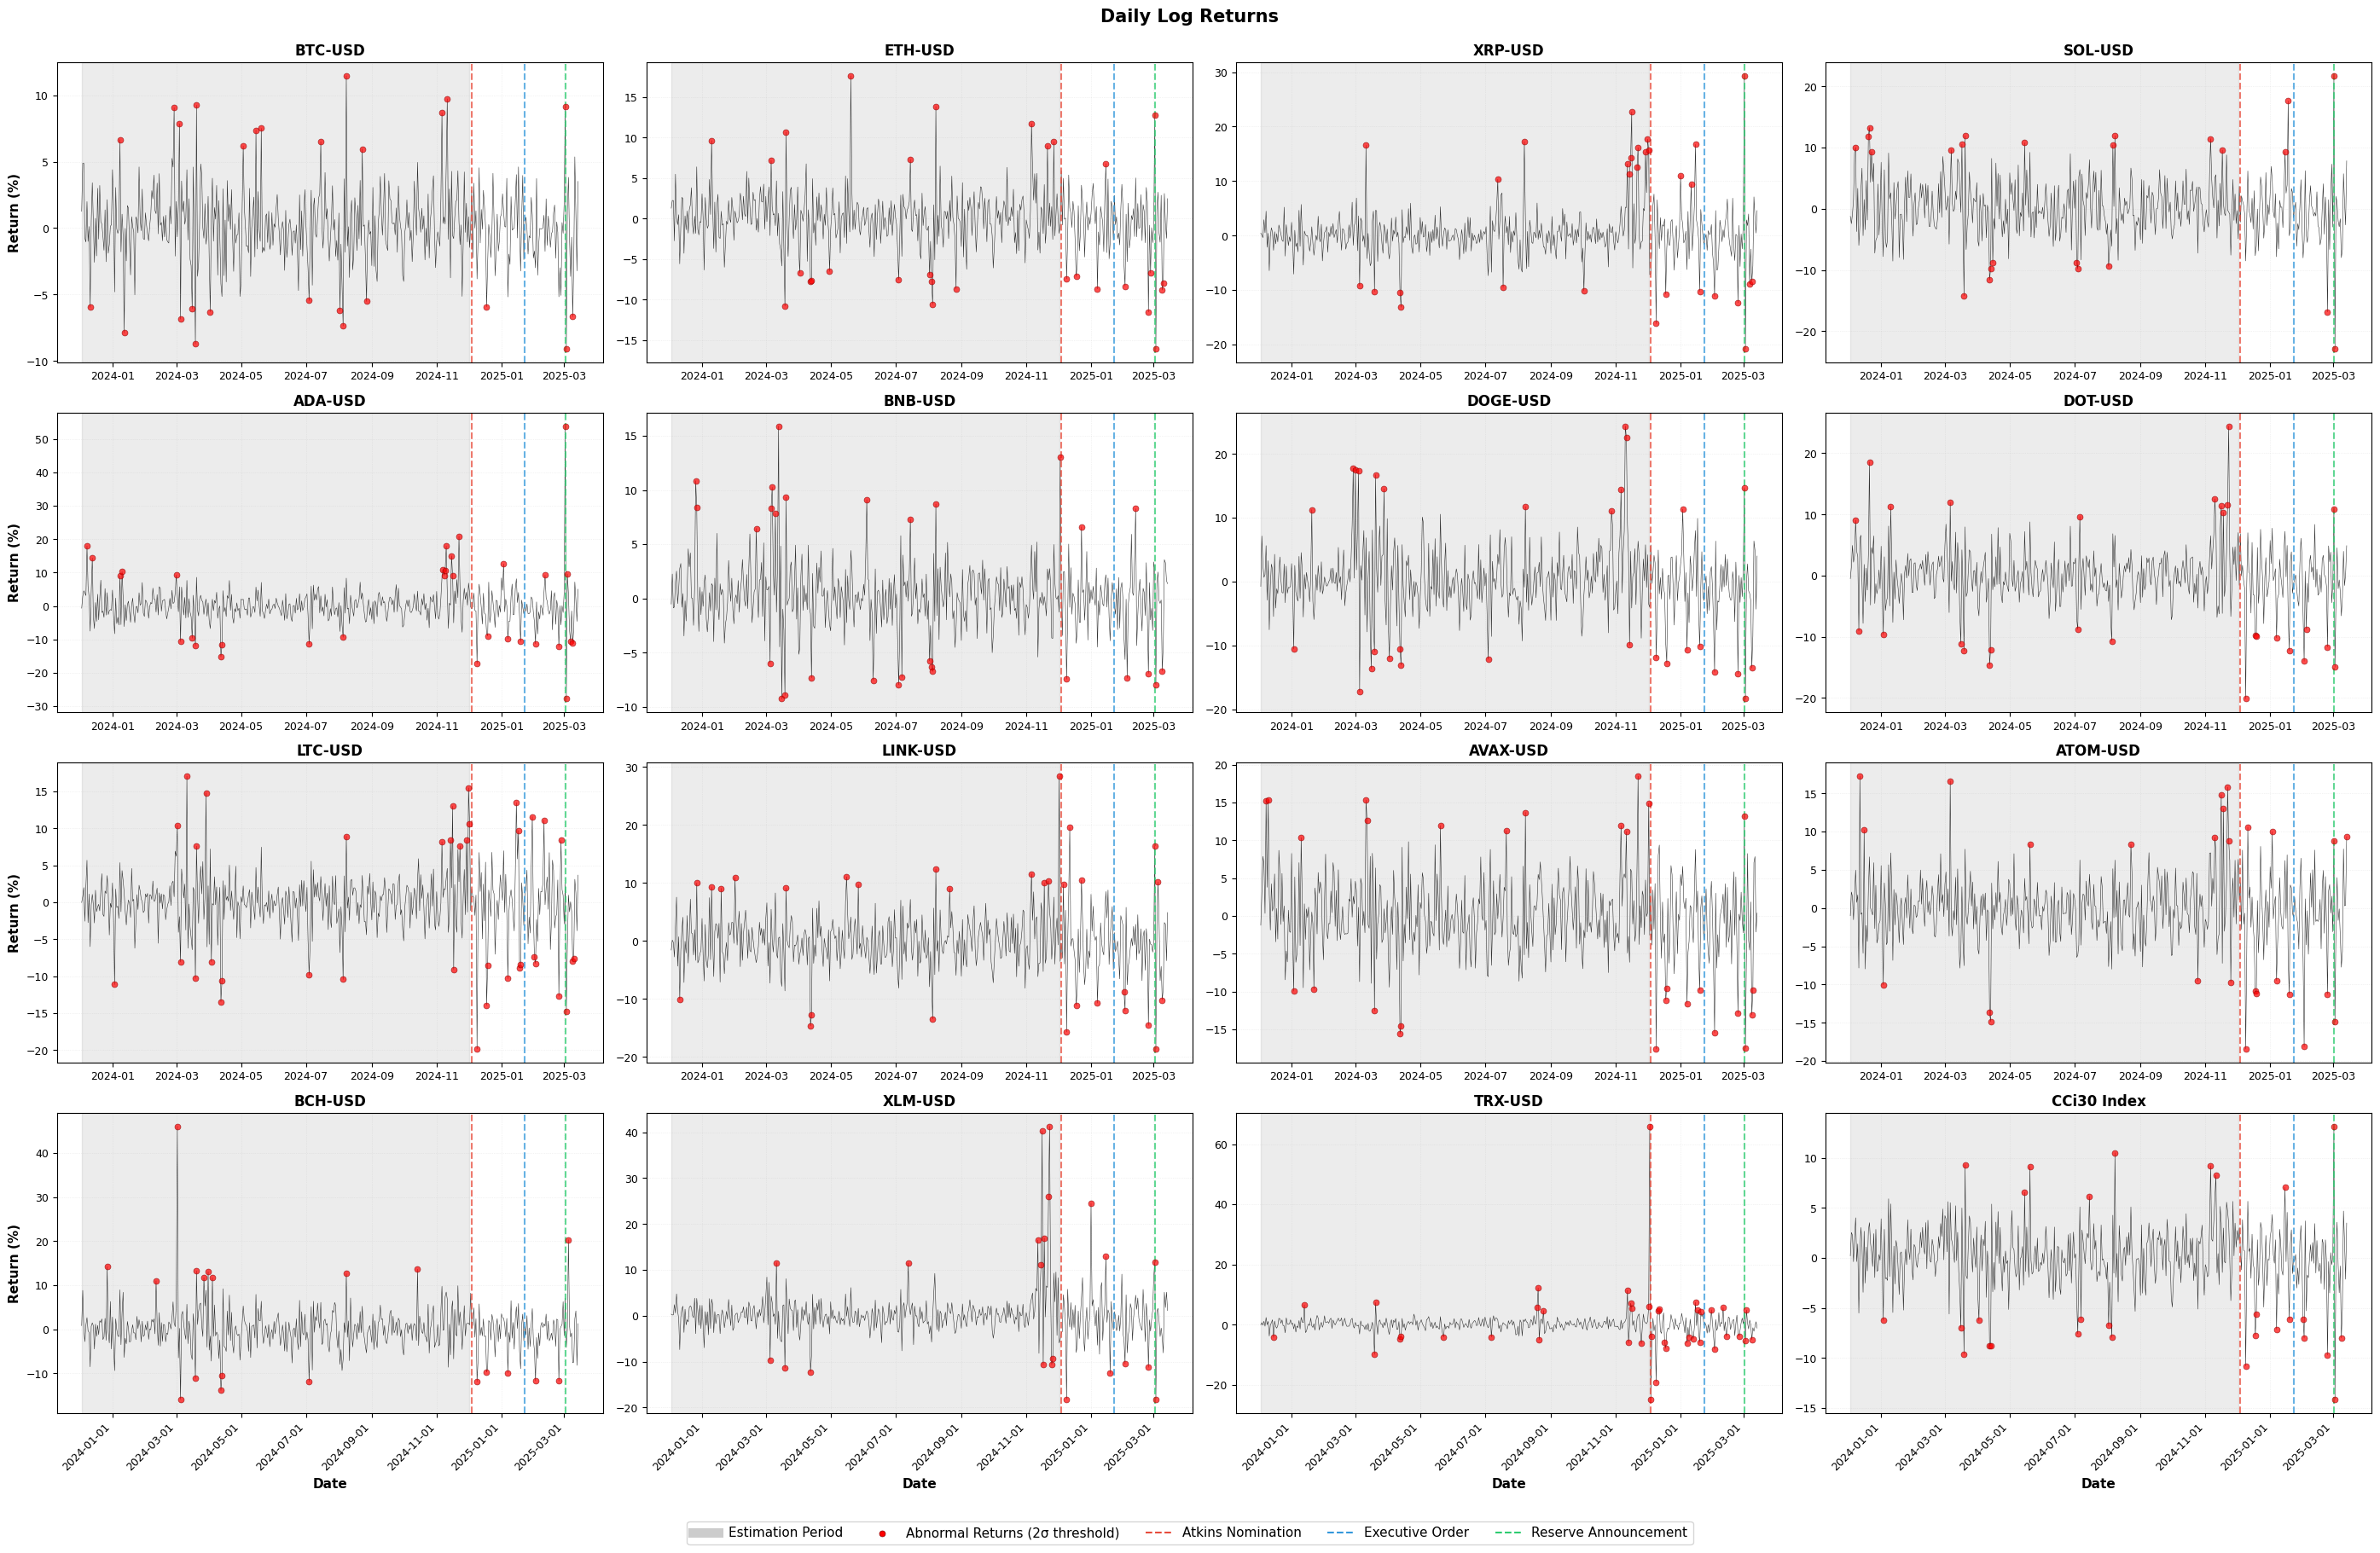


✓ Plot saved: Returns_Plot_Estimation_to_PostEvent.png


In [ ]:
# ================================================================================
# PLOT: DAILY RETURNS - ESTIMATION WINDOW (365 DAYS) + 10 DAYS AFTER LAST EVENT
# ================================================================================

import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100
plt.rcParams['lines.linewidth'] = 0.5

# ================================================================================
# LOAD DATA
# ================================================================================

file_path = "crypto event data .xlsx"
data = pd.read_excel(file_path)

# Identify date column
date_col = None
for col_name in data.columns:
    if 'date' in col_name.lower() or 'time' in col_name.lower():
        date_col = col_name
        break
if date_col is None:
    date_col = data.columns[0]

data = data.rename(columns={date_col: 'Date'})
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values('Date').reset_index(drop=True)

cryptos = ['BTC-USD', 'ETH-USD', 'XRP-USD', 'SOL-USD', 'ADA-USD', 'BNB-USD',
           'DOGE-USD', 'DOT-USD', 'LTC-USD', 'LINK-USD', 'AVAX-USD', 'ATOM-USD',
           'BCH-USD', 'XLM-USD', 'TRX-USD']
market_index = 'CCi30 Index'

# ================================================================================
# CALCULATE LOG RETURNS
# ================================================================================

returns = data[['Date']].copy()
for col in cryptos + [market_index]:
    returns[col] = np.log(data[col] / data[col].shift(1))
returns = returns.dropna().reset_index(drop=True)

for col in cryptos + [market_index]:
    returns[col] = pd.to_numeric(returns[col], errors='coerce')

# ================================================================================
# DEFINE EVENTS & ESTIMATION WINDOW
# ================================================================================

event_dates = {
    "Atkins_Nomination": pd.to_datetime("2024-12-04"),
    "Executive_Order": pd.to_datetime("2025-01-23"),
    "Reserve_Announcement": pd.to_datetime("2025-03-02")
}

# Adjust event dates to nearest available trading date
for event_name in event_dates.keys():
    nearest_idx = (returns['Date'] - event_dates[event_name]).abs().idxmin()
    event_dates[event_name] = returns.loc[nearest_idx, 'Date']

first_event = list(event_dates.values())[0]
last_event = list(event_dates.values())[-1]

# Estimation window: Fixed dates (365 days before first event)
estimation_start = pd.to_datetime("2023-12-03")
estimation_end = pd.to_datetime("2024-12-02")

# Align to actual data dates
est_start_idx = (returns['Date'] - estimation_start).abs().idxmin()
est_end_idx = (returns['Date'] - estimation_end).abs().idxmin()

estimation_start = returns.loc[est_start_idx, 'Date']
estimation_end = returns.loc[est_end_idx, 'Date']

# Get estimation period data for abnormality calculation
estimation_data = returns.iloc[est_start_idx:est_end_idx + 1].copy()

# Plot window: from estimation start to 10 days after last event
plot_end = last_event + pd.tseries.offsets.BDay(10)
plot_end_idx = (returns['Date'] - plot_end).abs().idxmin()
plot_end = returns.loc[plot_end_idx, 'Date']

plot_data = returns[(returns['Date'] >= estimation_start) & (returns['Date'] <= plot_end)].copy()

print("="*100)
print("RETURNS PLOT SPECIFICATIONS")
print("="*100)
print(f"Estimation Period: {estimation_start.date()} to {estimation_end.date()}")
print(f"Plot Period: {estimation_start.date()} to {plot_end.date()}")
print(f"First Event: {first_event.date()}")
print(f"Last Event: {last_event.date()}")
print(f"Plot Data Points: {len(plot_data)}")

# ================================================================================
# CALCULATE ABNORMALITIES (from estimation period stats)
# ================================================================================

abnormality_data = {}

for crypto in cryptos + [market_index]:
    if crypto not in estimation_data.columns:
        continue

    est_returns = estimation_data[crypto].dropna()
    mean_ret = est_returns.mean()
    std_ret = est_returns.std()
    threshold = 2 * std_ret

    abnormal_mask = np.abs(plot_data[crypto].values - mean_ret) > threshold

    abnormality_data[crypto] = {
        'mean': mean_ret,
        'std': std_ret,
        'threshold': threshold,
        'abnormal_mask': abnormal_mask
    }

# ================================================================================
# CREATE 4x4 GRID PLOT
# ================================================================================

fig, axes = plt.subplots(4, 4, figsize=(28, 18), dpi=100)
axes = axes.flatten()

event_colors = {
    "Atkins_Nomination": "#e74c3c",
    "Executive_Order": "#3498db",
    "Reserve_Announcement": "#2ecc71"
}

for plot_idx, crypto in enumerate(cryptos + [market_index]):
    if plot_idx >= 16:
        break

    ax = axes[plot_idx]

    if crypto not in plot_data.columns:
        ax.axis("off")
        continue

    # Plot returns as thin black line
    ax.plot(plot_data['Date'], plot_data[crypto] * 100,
            linewidth=0.4, color='black', alpha=0.8, zorder=1)

    # Plot abnormal returns as red dots
    abnormal_mask = abnormality_data[crypto]['abnormal_mask']
    abnormal_dates = plot_data[abnormal_mask]['Date'].values
    abnormal_values = plot_data[abnormal_mask][crypto].values * 100

    ax.scatter(abnormal_dates, abnormal_values,
               color='red', s=25, alpha=0.7, zorder=3,
               edgecolors='darkred', linewidth=0.5, label='Abnormal Returns')

    # Shade estimation window
    ax.axvspan(estimation_start, estimation_end,
               alpha=0.15, color='gray', zorder=0, label='Estimation Period')

    # Mark event dates with vertical lines
    for ev_name, ev_color in event_colors.items():
        if ev_name in event_dates:
            ev_date = event_dates[ev_name]
            if ev_date <= plot_end:
                ax.axvline(ev_date, color=ev_color, linestyle='--',
                          linewidth=1.5, alpha=0.75, zorder=2)

    # Formatting
    ax.set_title(f'{crypto}', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, linestyle=':', linewidth=0.5)
    ax.tick_params(labelsize=9)

    # Y-axis label on left plots
    if plot_idx % 4 == 0:
        ax.set_ylabel('Return (%)', fontweight='bold', fontsize=11)

    # X-axis label on bottom plots
    if plot_idx >= 12:
        ax.set_xlabel('Date', fontweight='bold', fontsize=11)
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right', fontsize=9)

# Remove empty subplots
for j in range(len(cryptos) + 1, len(axes)):
    fig.delaxes(axes[j])

# Title and legend
fig.suptitle('Daily Log Returns',
            fontsize=15, fontweight='bold', y=0.995)

legend_elements = [
    plt.Line2D([0], [0], color='gray', linewidth=8, alpha=0.4,
              label='Estimation Period'),
    plt.scatter([], [], color='red', s=25, edgecolors='darkred',
               linewidth=0.5, label='Abnormal Returns (2σ threshold)')
]
for name, color in event_colors.items():
    legend_elements.append(
        plt.Line2D([0], [0], color=color, linestyle='--', linewidth=1.5,
                  label=name.replace('_', ' '))
    )

fig.legend(handles=legend_elements, loc='lower center',
          bbox_to_anchor=(0.5, -0.01), ncol=5, fontsize=11,
          frameon=True, fancybox=True)

plt.tight_layout()
plt.subplots_adjust(bottom=0.08)

filename = 'Returns_Plot_Estimation_to_PostEvent.png'
plt.savefig(filename, dpi=100, bbox_inches='tight')
plt.show()

print(f"\n✓ Plot saved: {filename}")
print("="*100)

In [5]:
# Current Date and Time (UTC - YYYY-MM-DD HH:MM:SS formatted): 2025-11-12 06:28:27
# Current User's Login: monimohanan

# ================================================================================
# DESCRIPTIVE STATISTICS WITH ADF STATIONARITY TEST
# ================================================================================
# Estimation Window + Event Windows (Complete Period)
# Mean, Std Dev, Min, Max, N Observations, ADF Statistic, ADF p-value
# ================================================================================

import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller

# ================================================================================
# LOAD DATA
# ================================================================================

file_path = "crypto event data .xlsx"
data = pd.read_excel(file_path)

date_col = None
for col_name in data.columns:
    if 'date' in col_name.lower() or 'time' in col_name.lower():
        date_col = col_name
        break
if date_col is None:
    date_col = data.columns[0]

data = data.rename(columns={date_col: 'Date'})
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values('Date').reset_index(drop=True)

cryptos = ['BTC-USD', 'ETH-USD', 'XRP-USD', 'SOL-USD', 'ADA-USD', 'BNB-USD',
           'DOGE-USD', 'DOT-USD', 'LTC-USD', 'LINK-USD', 'AVAX-USD', 'ATOM-USD',
           'BCH-USD', 'XLM-USD', 'TRX-USD']
market_index = 'CCi30 Index'

all_assets = cryptos + [market_index]

# Calculate log returns
returns = data[['Date']].copy()
for col in all_assets:
    returns[col] = np.log(data[col] / data[col].shift(1))
returns = returns.dropna().reset_index(drop=True)

# ================================================================================
# ESTIMATION START & LAST EVENT END
# ================================================================================

estimation_start = pd.to_datetime("2023-12-03")
last_event = pd.to_datetime("2025-03-02")

# Find last event in data and extend 10 days after
last_event_idx = (returns['Date'] - last_event).abs().idxmin()
plot_end_idx = min(last_event_idx + 10, len(returns) - 1)
plot_end = returns.loc[plot_end_idx, 'Date']

# Complete period data
period_start_idx = (returns['Date'] - estimation_start).abs().idxmin()
period_data = returns.iloc[period_start_idx:plot_end_idx + 1].copy()

# ================================================================================
# FUNCTION: ADF TEST WITH SIGNIFICANCE STARS
# ================================================================================

def adf_test_with_stars(series):
    """
    Perform ADF test and return statistic, p-value, and significance stars
    """
    series_clean = series.dropna()
    if len(series_clean) < 10:
        return np.nan, np.nan, ""

    try:
        result = adfuller(series_clean, autolag='AIC')
        adf_stat = result[0]
        p_value = result[1]

        # Add significance stars
        if p_value < 0.01:
            stars = "***"
        elif p_value < 0.05:
            stars = "**"
        elif p_value < 0.10:
            stars = "*"
        else:
            stars = ""

        return adf_stat, p_value, stars
    except:
        return np.nan, np.nan, ""

# ================================================================================
# CALCULATE STATISTICS FOR ENTIRE PERIOD
# ================================================================================

print("="*240)
print("DESCRIPTIVE STATISTICS WITH ADF STATIONARITY TEST - COMPLETE ANALYSIS PERIOD")
print("="*240)
print(f"Period: {period_data['Date'].min().date()} to {period_data['Date'].max().date()}")
print(f"Total Days: {len(period_data)}\n")

print(f"{'Asset':<15} {'N':>8} {'Mean':>12} {'Std Dev':>12} {'Min':>12} {'Max':>12} {'ADF Stat':>12} {'p-value':>10} {'Sig':>5}")
print("-"*240)

stats_list = []

for asset in all_assets:
    asset_data = period_data[asset].dropna()

    # Calculate ADF test
    adf_stat, adf_pval, sig_stars = adf_test_with_stars(asset_data)

    stats_dict = {
        'Asset': asset,
        'N': len(asset_data),
        'Mean': asset_data.mean(),
        'Std Dev': asset_data.std(),
        'Min': asset_data.min(),
        'Max': asset_data.max(),
        'ADF Statistic': adf_stat,
        'ADF p-value': adf_pval,
        'Significance': sig_stars
    }

    stats_list.append(stats_dict)

    print(f"{asset:<15} {stats_dict['N']:>8} {stats_dict['Mean']:>12.6f} "
          f"{stats_dict['Std Dev']:>12.6f} {stats_dict['Min']:>12.6f} {stats_dict['Max']:>12.6f} "
          f"{stats_dict['ADF Statistic']:>12.4f} {stats_dict['ADF p-value']:>10.4f} {stats_dict['Significance']:>5}")

print("-"*240)
print("\nNote: *** p<0.01, ** p<0.05, * p<0.10")
print("Null Hypothesis (ADF): Series has a unit root (non-stationary)")
print("If p-value < 0.05, reject null → Series is stationary")
print("="*240)

# ================================================================================
# EXPORT TO CSV
# ================================================================================

stats_df = pd.DataFrame(stats_list)
csv_file = 'Descriptive_Statistics_All_Assets_with_ADF.csv'
stats_df.to_csv(csv_file, index=False)

print(f"\nStatistics exported to: {csv_file}")
print("="*240)

# ================================================================================
# SUMMARY: STATIONARITY RESULTS
# ================================================================================

stationary_assets = stats_df[stats_df['ADF p-value'] < 0.05]
non_stationary_assets = stats_df[stats_df['ADF p-value'] >= 0.05]

print("\n" + "="*240)
print("STATIONARITY SUMMARY")
print("="*240)
print(f"Stationary Assets (p < 0.05): {len(stationary_assets)}/{len(stats_df)}")
if len(stationary_assets) > 0:
    print("  " + ", ".join(stationary_assets['Asset'].tolist()))

if len(non_stationary_assets) > 0:
    print(f"\nNon-Stationary Assets (p ≥ 0.05): {len(non_stationary_assets)}/{len(stats_df)}")
    print("  " + ", ".join(non_stationary_assets['Asset'].tolist()))

print("="*240)

DESCRIPTIVE STATISTICS WITH ADF STATIONARITY TEST - COMPLETE ANALYSIS PERIOD
Period: 2023-12-03 to 2025-03-12
Total Days: 466

Asset                  N         Mean      Std Dev          Min          Max     ADF Stat    p-value   Sig
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
BTC-USD              466     0.001613     0.027635    -0.090823     0.114616     -22.8563     0.0000   ***
ETH-USD              466    -0.000271     0.035051    -0.160731     0.176238     -22.7310     0.0000   ***
XRP-USD              466     0.002754     0.045826    -0.207859     0.293192      -3.7326     0.0037   ***
SOL-USD              466     0.001469     0.047161    -0.228588     0.217005     -22.4465     0.0000   ***
ADA-USD              466     0.001319     0.053421    -0.278123     0.538407      -4.4942     0.0

In [ ]:
!pip install pycwt --no-deps

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.0/755.0 kB 11.1 MB/s eta 0:00:00


CRYPTOCURRENCY WAVELET POWER SPECTRUM ANALYSIS - FINAL VERSION

Step 1: Loading cryptocurrency data...
✓ Data loaded: 964 observations
✓ Individual cryptocurrencies: 15
✓ Market index: CCi30 Index
✓ Full date range: 2023-03-02 to 2025-10-20

Step 2: Defining policy events...
  Atkins Nomination: 2024-12-04
  Executive Order: 2025-01-23
  Reserve Announcement: 2025-03-02

Step 3: Setting plotting time ranges...
✓ Estimation period: 2023-12-03 to 2024-12-02
✓ Plot range (Panels A,B,C): 2023-12-02 to 2025-03-17
✓ Plot range (Panel D): 2024-09-04 to 2025-03-17
✓ Last event: 2025-03-02

Step 4: Setting wavelet parameters...
✓ Wavelet: Morlet(6)
✓ Scales: 84 scales from 2 to 128 days
✓ Colormap: hot (black→red→yellow→white)

Step 5: Performing wavelet analysis...
  Analyzing: CCi30 Index...
    ✓ Sensitivity: 1.89x
  Analyzing: BTC-USD...
    ✓ Sensitivity: 1.28x
  Analyzing: ETH-USD...
    ✓ Sensitivity: 1.55x
  Analyzing: XRP-USD...
    ✓ Sensitivity: 2.98x
  Analyzing: SOL-USD...
    ✓ Se

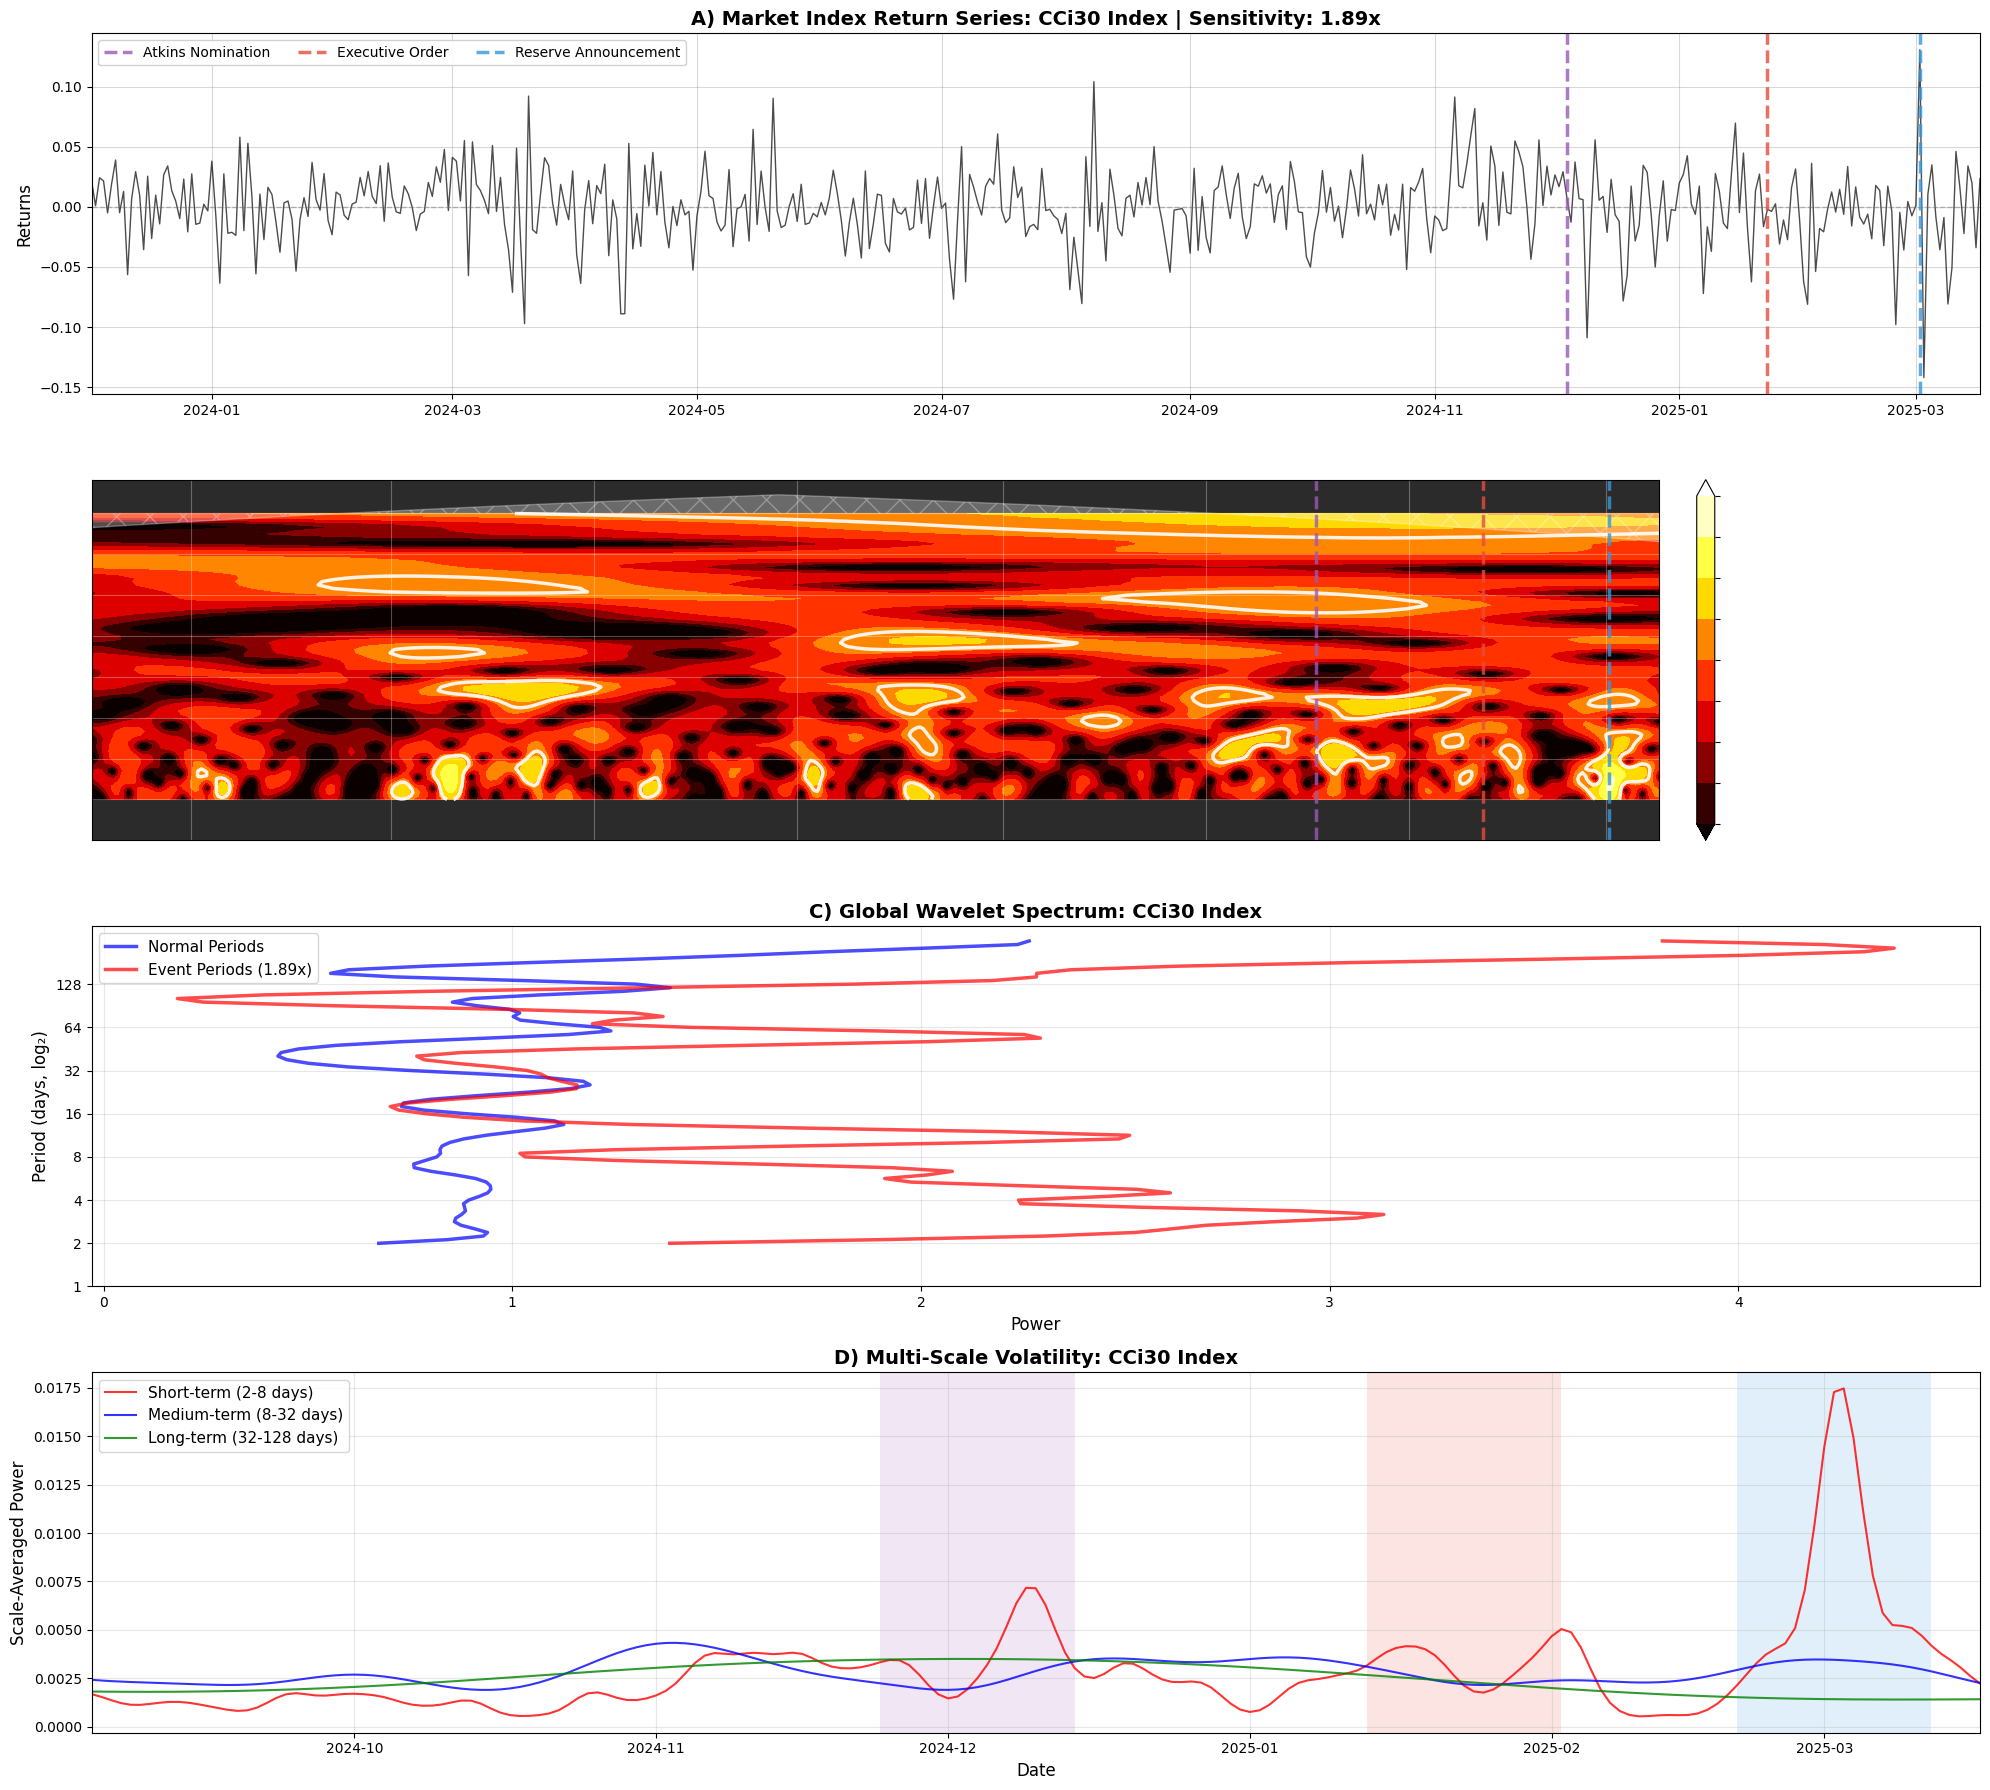

  ✓ Plot 1 displayed

Plot 2: Wavelet Power Spectrum - 15 Cryptocurrencies...


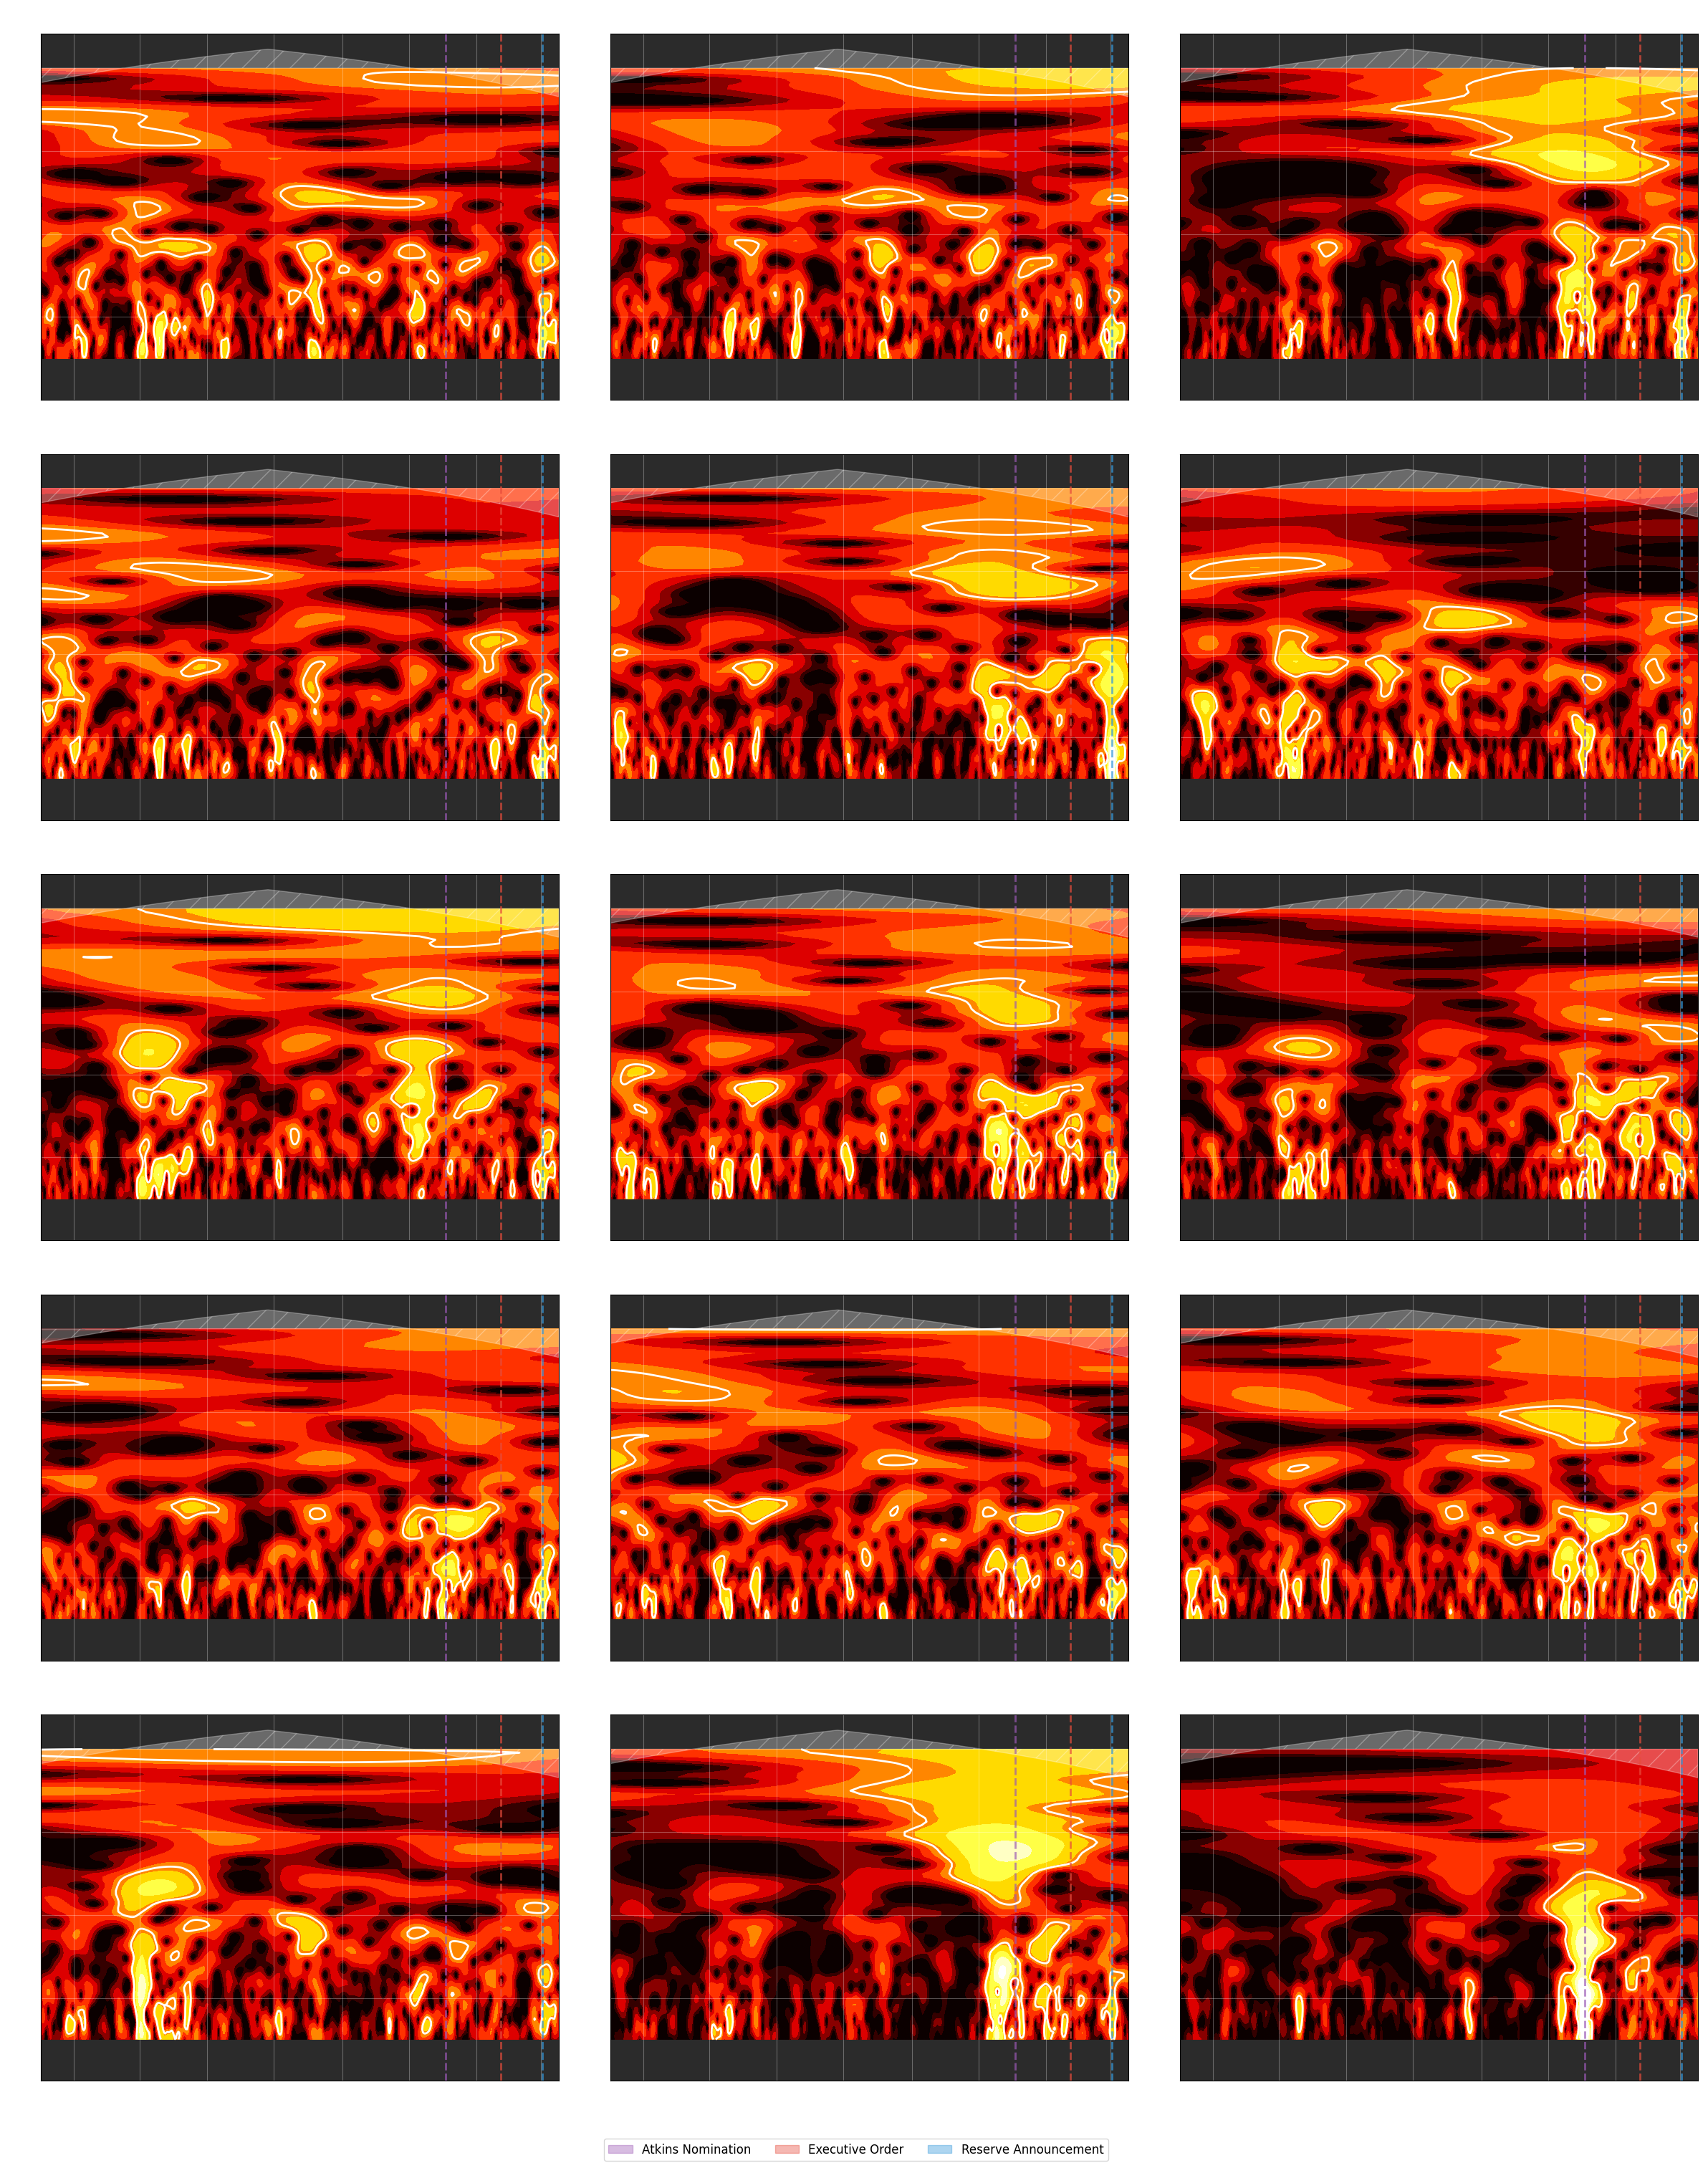

  ✓ Plot 2 displayed

Plot 3: Global Wavelet Spectrum - 15 Cryptocurrencies...


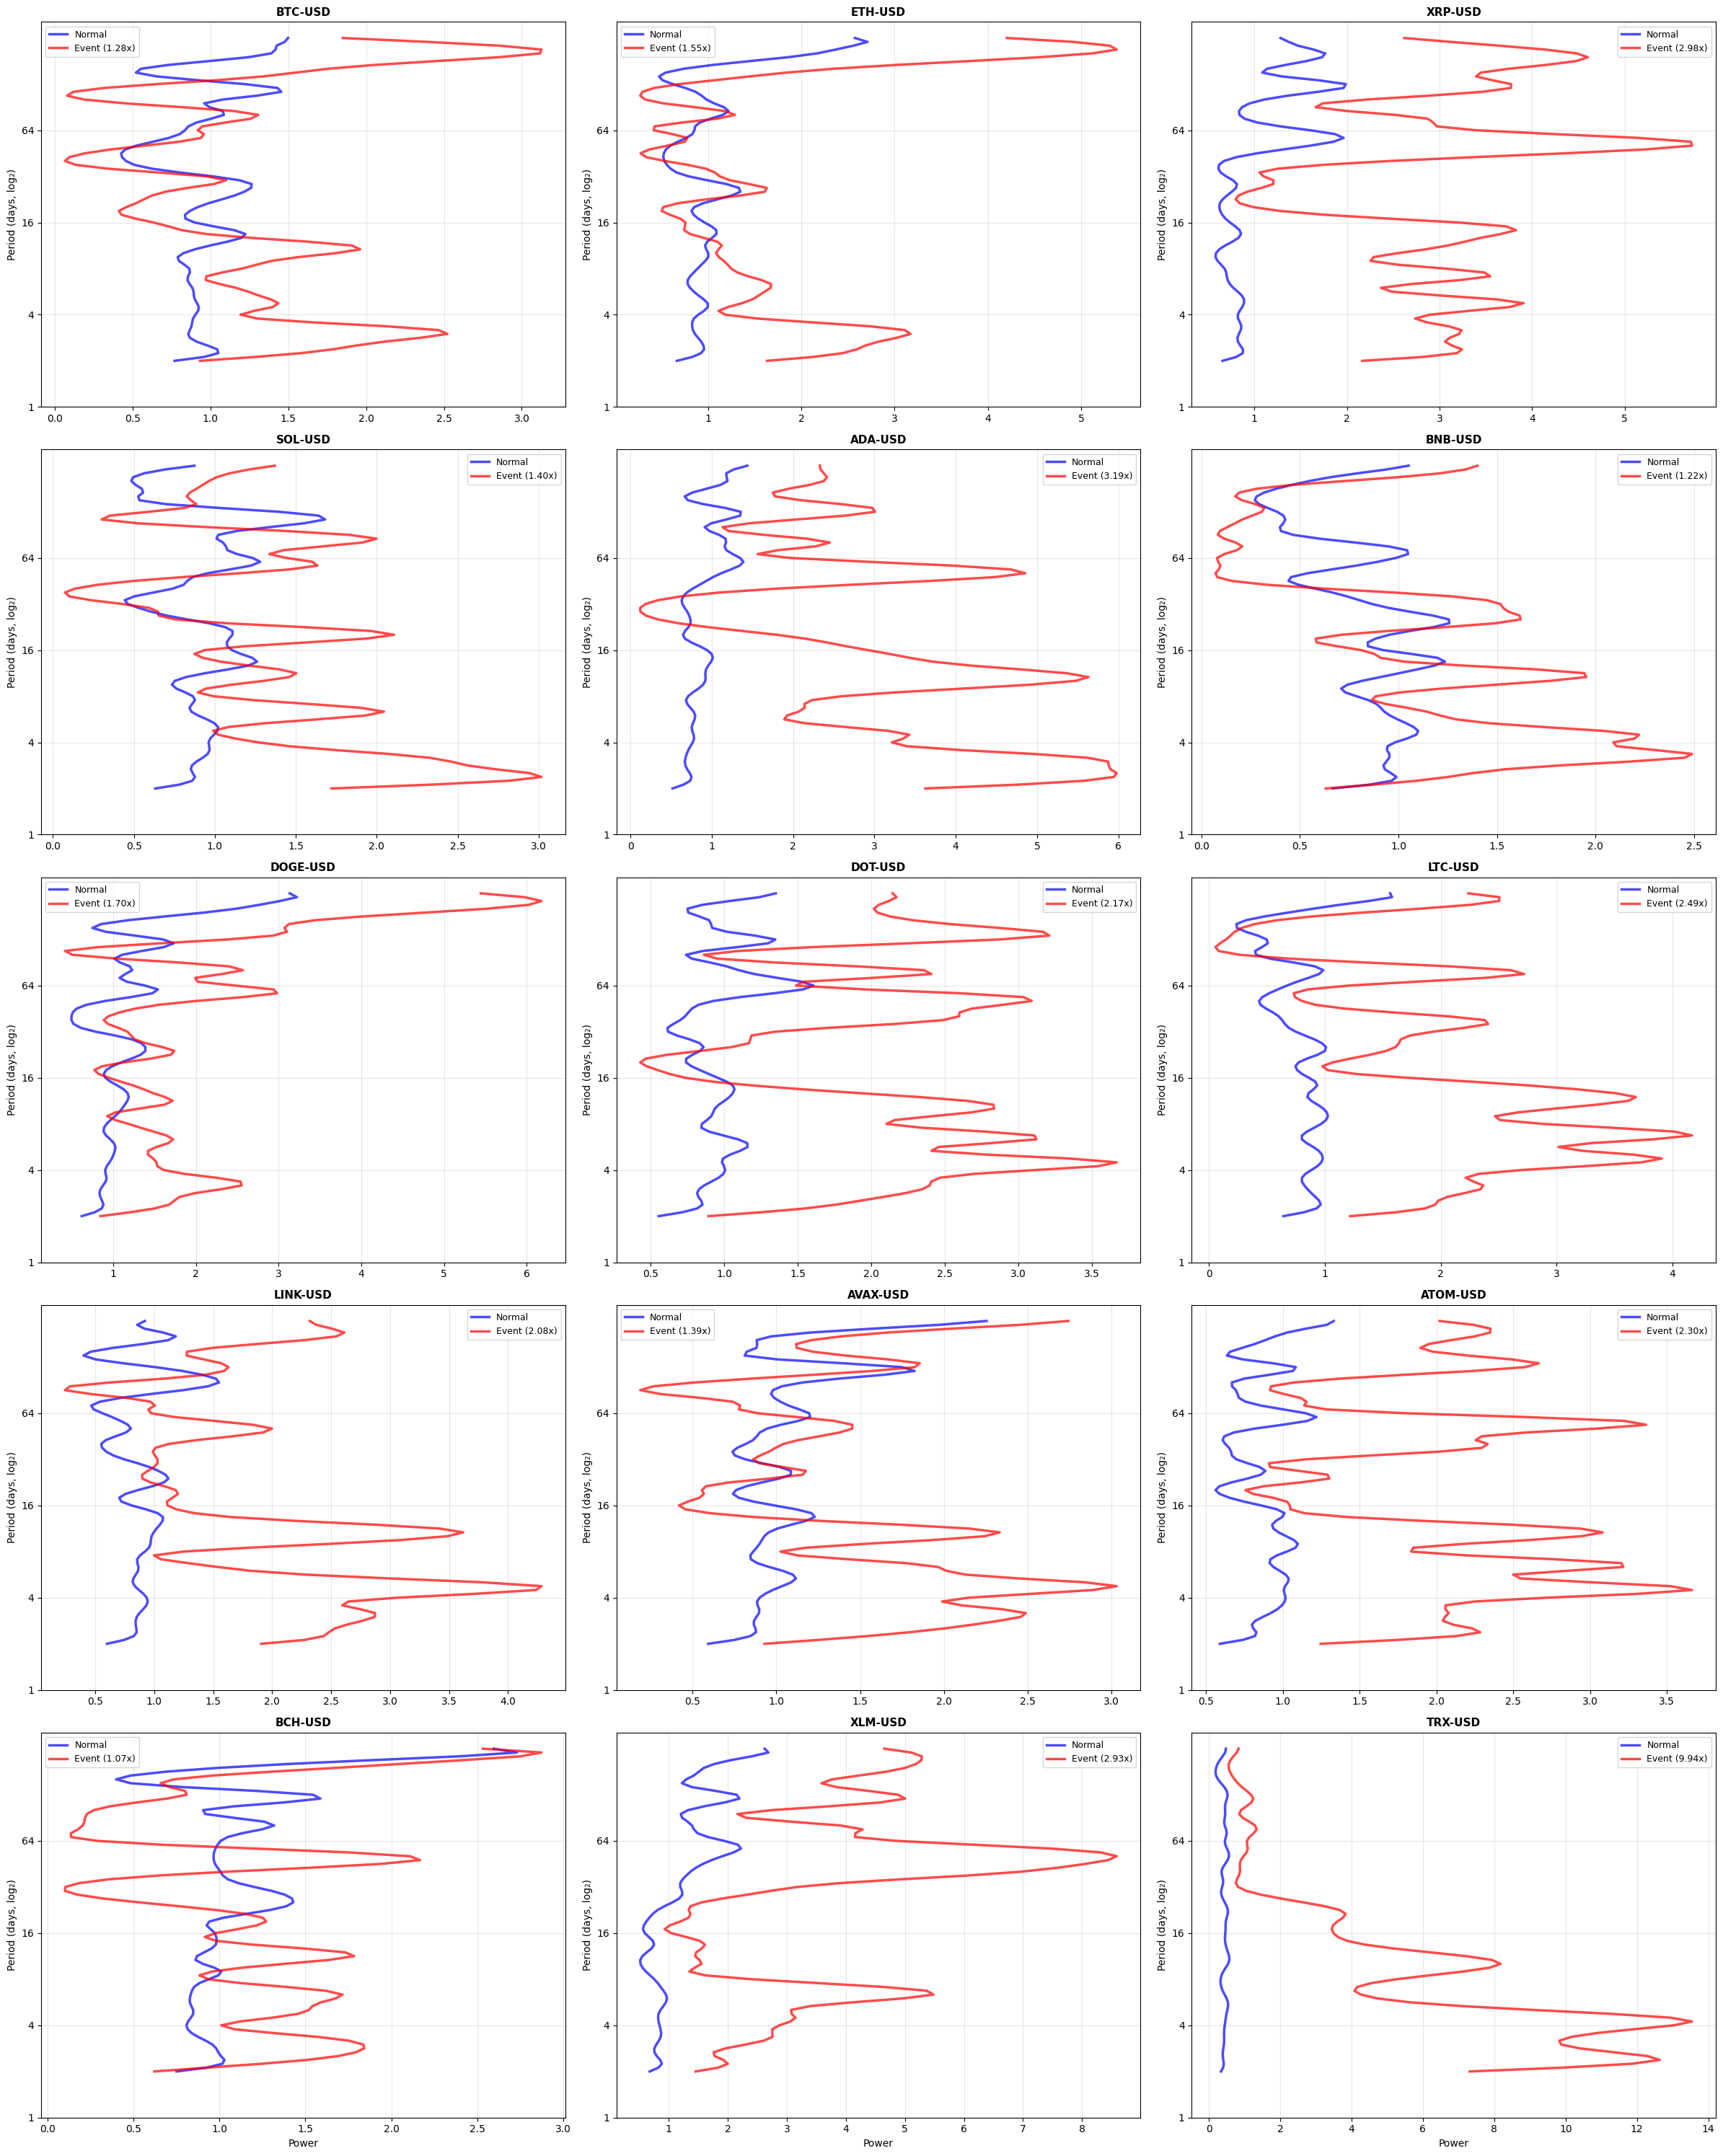

  ✓ Plot 3 displayed

Plot 4: Multi-Scale Volatility - 15 Cryptocurrencies...


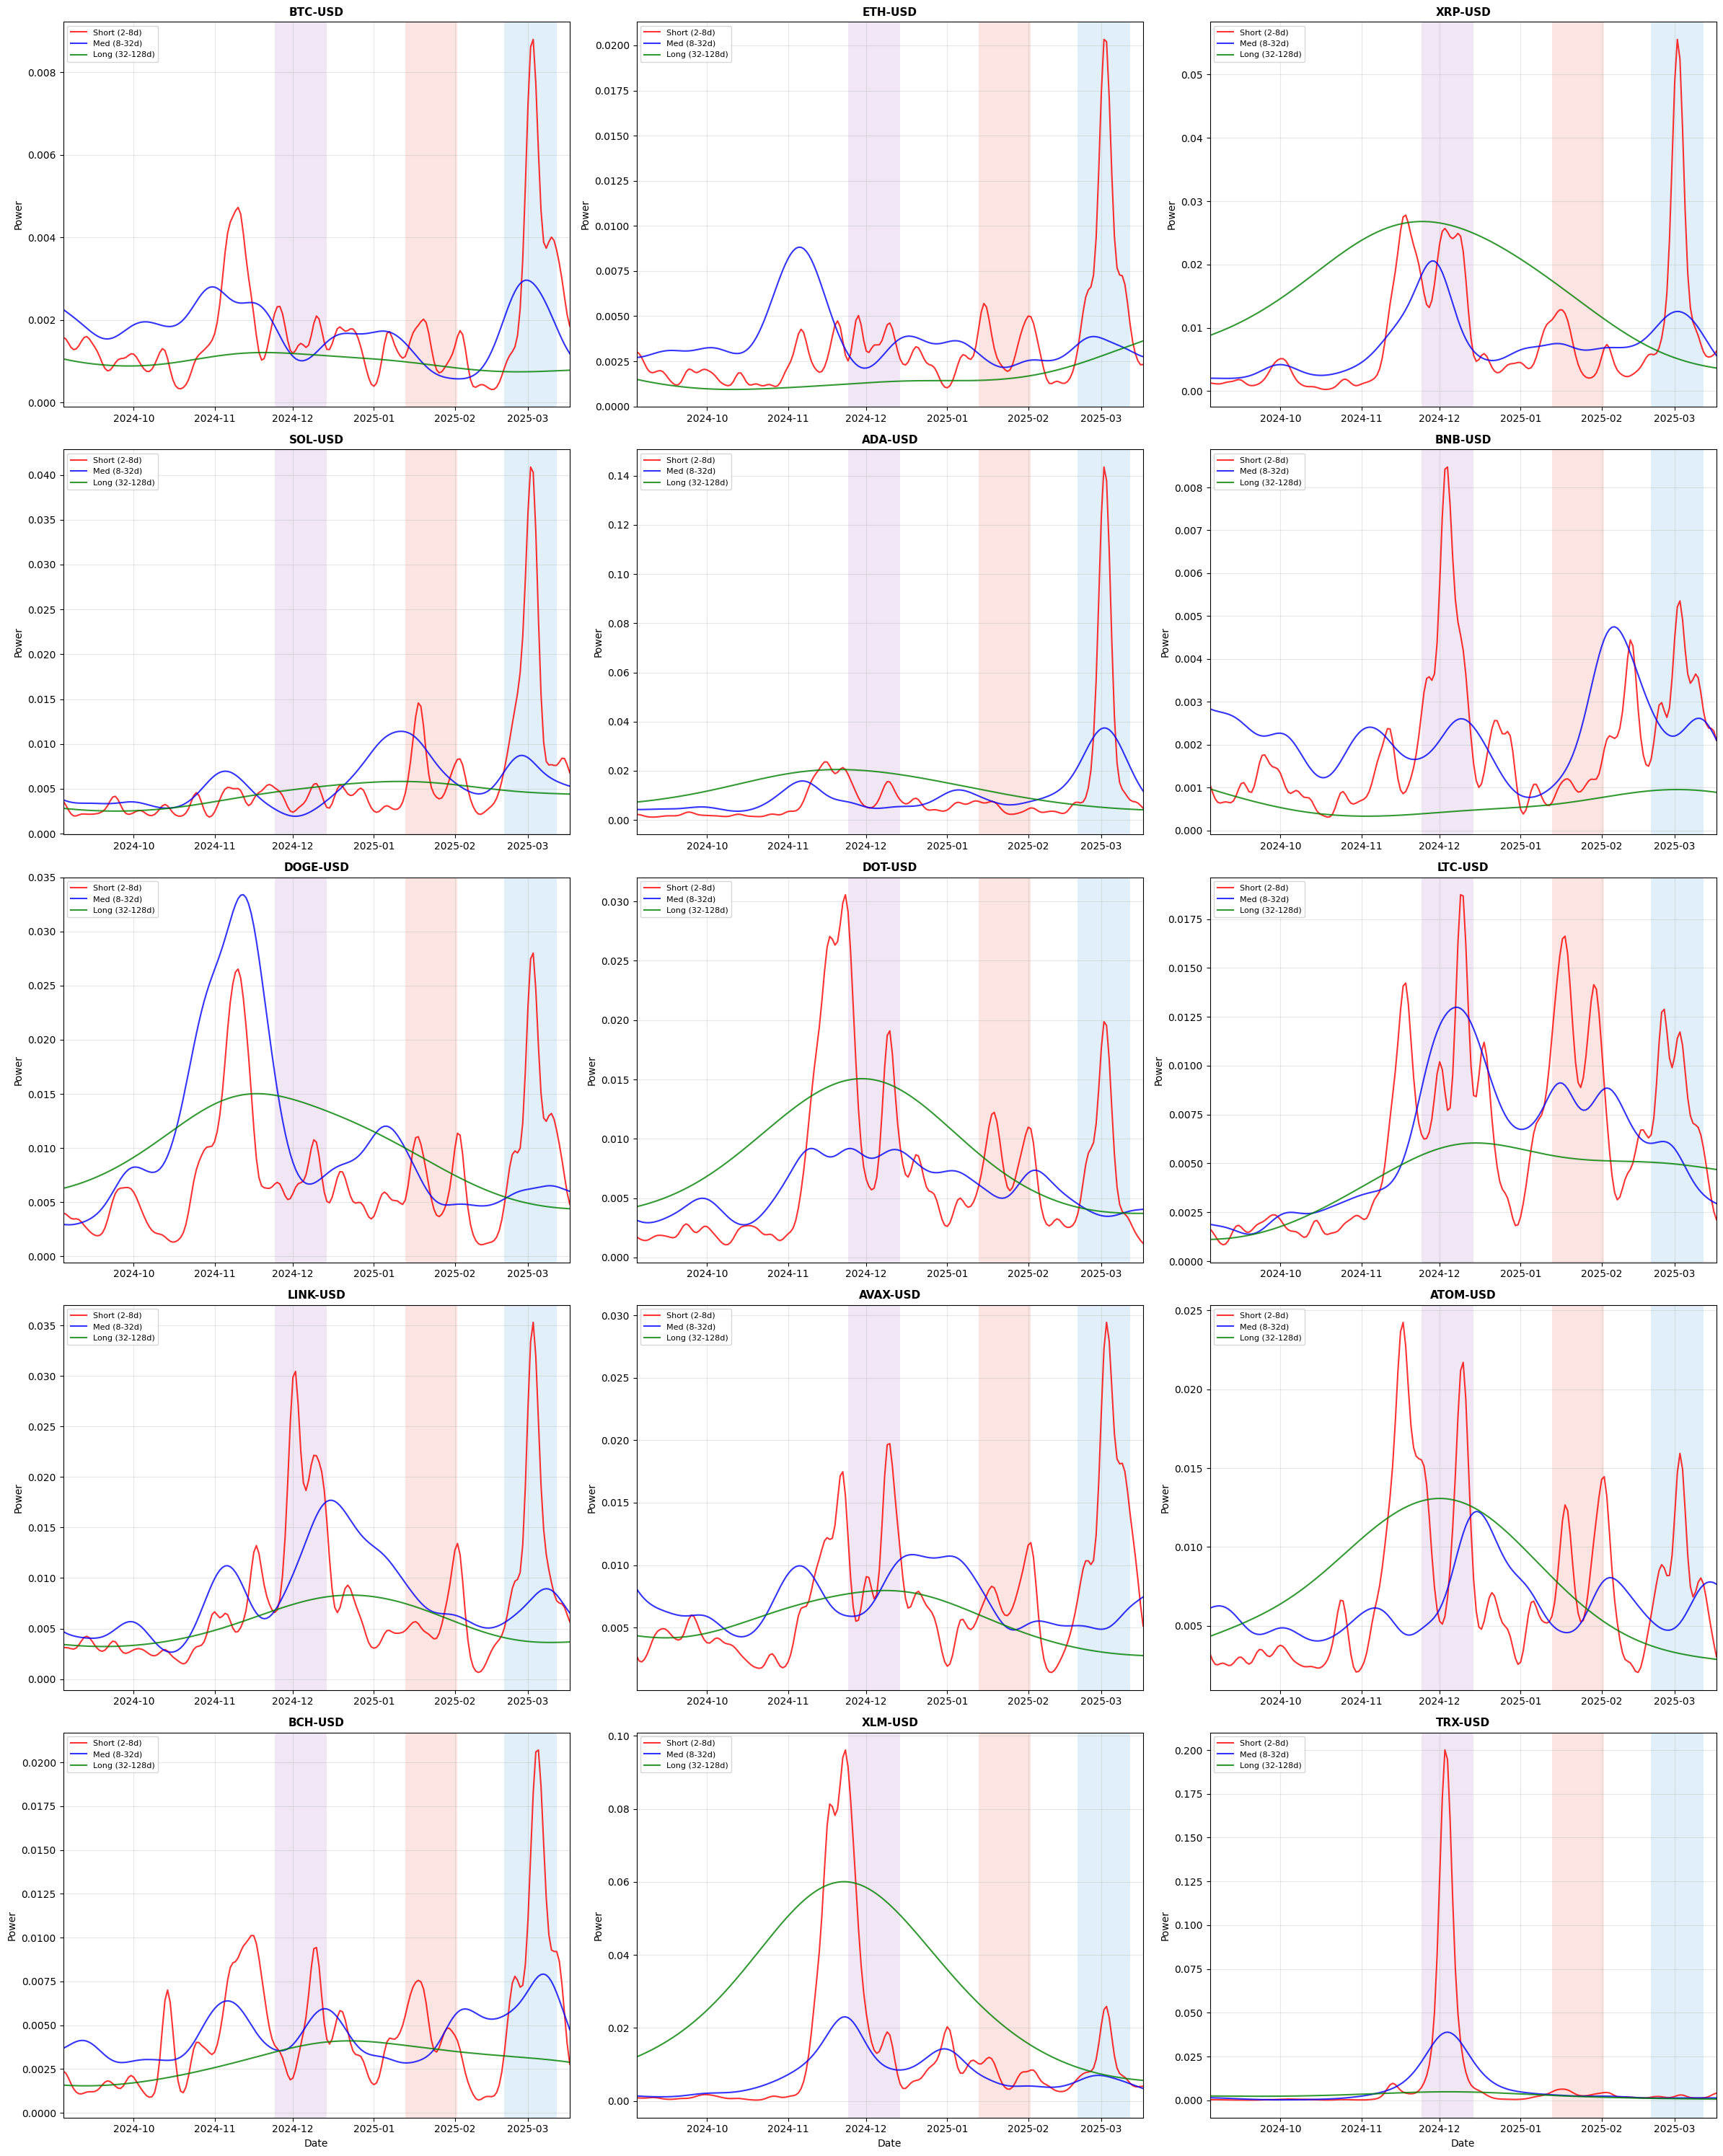

  ✓ Plot 4 displayed

ANALYSIS COMPLETE

Assets analyzed: 16
  • Market Index: CCi30 Index
  • Cryptocurrencies: 15

Policy events: 3
Plot range (Panels A,B,C): 2023-12-02 to 2025-03-17
Plot range (Panel D): 2024-09-04 to 2025-03-17

Plots generated: 4
  • Plot 1: Market Index (4 panels)
  • Plot 2: Wavelet Power Spectrum (15 subplots)
  • Plot 3: Global Spectrum (15 subplots)
  • Plot 4: Multi-Scale Volatility (15 subplots)

Most event-sensitive: TRX-USD (9.94x)
Least event-sensitive: BCH-USD (1.07x)


In [ ]:
# ================================================================================
# CRYPTOCURRENCY WAVELET POWER SPECTRUM ANALYSIS - FINAL VERSION
# ================================================================================
# Market Index: 1 plot with 4 panels
# 15 Cryptos: 3 plots with 15 subplots each (B, C, D only)
# Time range: 1 day before estimation start to 15 days after last event
# Multi-scale: 3 months before first event to 15 days after last event
# Colormap: 'hot' (black→red→yellow→white) with dark background
# No auto-save,
# ================================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pycwt as wavelet
from pycwt.helpers import find
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100

print("="*100)
print("CRYPTOCURRENCY WAVELET POWER SPECTRUM ANALYSIS - FINAL VERSION")
print("="*100 + "\n")

# ================================================================================
# STEP 1: LOAD DATA
# ================================================================================
print("Step 1: Loading cryptocurrency data...")

file_path = "crypto event data .xlsx"
data = pd.read_excel(file_path)

# Find date column
date_col = None
for col_name in data.columns:
    if 'date' in col_name.lower() or 'time' in col_name.lower():
        date_col = col_name
        break
if date_col is None:
    date_col = data.columns[0]

data = data.rename(columns={date_col: 'Date'})
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values('Date').reset_index(drop=True)

# Define cryptocurrencies
market_index = 'CCi30 Index'
cryptos = ['BTC-USD', 'ETH-USD', 'XRP-USD', 'SOL-USD', 'ADA-USD', 'BNB-USD',
           'DOGE-USD', 'DOT-USD', 'LTC-USD', 'LINK-USD', 'AVAX-USD', 'ATOM-USD',
           'BCH-USD', 'XLM-USD', 'TRX-USD']

# Calculate log returns
returns_df = data[['Date']].copy()
for crypto in cryptos + [market_index]:
    if crypto in data.columns:
        returns_df[f'{crypto}_Return'] = np.log(data[crypto] / data[crypto].shift(1))

returns_df = returns_df.dropna().reset_index(drop=True)

print(f"✓ Data loaded: {len(returns_df)} observations")
print(f"✓ Individual cryptocurrencies: {len(cryptos)}")
print(f"✓ Market index: {market_index}")
print(f"✓ Full date range: {returns_df['Date'].min().date()} to {returns_df['Date'].max().date()}")

# ================================================================================
# STEP 2: DEFINE POLICY EVENTS
# ================================================================================
print("\nStep 2: Defining policy events...")

policy_events = [
    {
        'name': 'Atkins Nomination',
        'date': pd.to_datetime('2024-12-04'),
        'color': '#9b59b6',
        'description': 'Paul Atkins nominated as SEC Chair'
    },
    {
        'name': 'Executive Order',
        'date': pd.to_datetime('2025-01-23'),
        'color': '#e74c3c',
        'description': 'Presidential Executive Order on Digital Assets'
    },
    {
        'name': 'Reserve Announcement',
        'date': pd.to_datetime('2025-03-02'),
        'color': '#3498db',
        'description': 'Strategic Bitcoin Reserve Announcement'
    }
]

# Adjust event dates to nearest trading day
for event in policy_events:
    nearest_idx = (returns_df['Date'] - event['date']).abs().idxmin()
    event['date'] = returns_df.loc[nearest_idx, 'Date']
    print(f"  {event['name']}: {event['date'].date()}")

# ================================================================================
# STEP 3: DEFINE PLOTTING TIME RANGES
# ================================================================================
print("\nStep 3: Setting plotting time ranges...")

# Estimation period
estimation_start = pd.to_datetime("2023-12-03")
estimation_end = pd.to_datetime("2024-12-02")

# Find nearest available dates
est_start_idx = (returns_df['Date'] - estimation_start).abs().idxmin()
est_end_idx = (returns_df['Date'] - estimation_end).abs().idxmin()
estimation_start = returns_df.loc[est_start_idx, 'Date']
estimation_end = returns_df.loc[est_end_idx, 'Date']

# Plot range for Panels A, B, C: 1 day before estimation start to 15 days after last event
plot_start = estimation_start - pd.Timedelta(days=1)
last_event_date = max([event['date'] for event in policy_events])
plot_end = last_event_date + pd.Timedelta(days=15)

# Find indices for plot range
plot_start_idx = (returns_df['Date'] - plot_start).abs().idxmin()
plot_end_idx = (returns_df['Date'] - plot_end).abs().idxmin()

plot_start = returns_df.loc[plot_start_idx, 'Date']
plot_end = returns_df.loc[plot_end_idx, 'Date']

# Plot range for Panel D (Multi-scale): 3 months before first event to 15 days after last event
first_event_date = min([event['date'] for event in policy_events])
plot_start_multi = first_event_date - pd.DateOffset(months=3)

# Find index for multi-scale start
plot_start_multi_idx = (returns_df['Date'] - plot_start_multi).abs().idxmin()
plot_start_multi = returns_df.loc[plot_start_multi_idx, 'Date']

print(f"✓ Estimation period: {estimation_start.date()} to {estimation_end.date()}")
print(f"✓ Plot range (Panels A,B,C): {plot_start.date()} to {plot_end.date()}")
print(f"✓ Plot range (Panel D): {plot_start_multi.date()} to {plot_end.date()}")
print(f"✓ Last event: {last_event_date.date()}")

# ================================================================================
# STEP 4: WAVELET PARAMETERS
# ================================================================================
print("\nStep 4: Setting wavelet parameters...")

dt = 1
mother = wavelet.Morlet(6)
s0 = 2 * dt
dj = 1/12
J = 7/dj
cmap = "hot"

print(f"✓ Wavelet: Morlet(6)")
print(f"✓ Scales: {int(J)} scales from {s0} to {2**(7)} days")
print(f"✓ Colormap: {cmap} (black→red→yellow→white)")

# ================================================================================
# STEP 5: WAVELET TRANSFORM
# ================================================================================
print("\nStep 5: Performing wavelet analysis...")

wavelet_results = {}
event_volatility_analysis = []

all_assets = [market_index] + cryptos

for asset in all_assets:
    col_name = f'{asset}_Return'
    if col_name not in returns_df.columns:
        print(f"  ⚠ Skipping {asset} - data not found")
        continue

    print(f"  Analyzing: {asset}...")

    # Use FULL data for wavelet analysis
    series = returns_df[col_name].dropna().values
    dates = returns_df['Date'].iloc[:len(series)]

    if len(series) < 50:
        print(f"  ⚠ Skipping {asset} - insufficient data")
        continue

    # Detrend and normalize
    time = np.arange(len(series))
    p = np.polyfit(time, series, 1)
    detrended = series - np.polyval(p, time)
    std = np.std(detrended)
    var = std**2
    normalized = detrended / std

    # Continuous Wavelet Transform
    try:
        wave, scales, freqs, coi, fft, fftfreqs = wavelet.cwt(
            normalized, dt, dj, s0, J, mother
        )
    except Exception as e:
        print(f"  ⚠ Error in wavelet transform for {asset}: {e}")
        continue

    # Calculate power spectrum
    power = (np.abs(wave))**2

    # Significance testing
    alpha, _, _ = wavelet.ar1(series)
    signif, fft_theor = wavelet.significance(
        1.0, dt, scales, 0, alpha, significance_level=0.95, wavelet=mother
    )
    sig95 = np.ones([1, len(time)]) * signif[:, None]
    sig95 = power / sig95

    # Global wavelet spectrum
    glbl_power = power.mean(axis=1)
    dof = len(series) - scales
    glbl_signif, _ = wavelet.significance(
        var, dt, scales, 1, alpha, significance_level=0.95,
        dof=dof, wavelet=mother
    )

    # Scale-averaged power
    sel_short = find((scales >= 2) & (scales < 8))
    scale_avg_short = scales[:, None] * power / scales[:, None]
    scale_avg_short = var * dj * dt / mother.cdelta * scale_avg_short[sel_short, :].sum(axis=0)

    sel_med = find((scales >= 8) & (scales < 32))
    scale_avg_med = scales[:, None] * power / scales[:, None]
    scale_avg_med = var * dj * dt / mother.cdelta * scale_avg_med[sel_med, :].sum(axis=0)

    sel_long = find((scales >= 32) & (scales < 128))
    scale_avg_long = scales[:, None] * power / scales[:, None]
    scale_avg_long = var * dj * dt / mother.cdelta * scale_avg_long[sel_long, :].sum(axis=0)

    # Event impact analysis
    event_window_days = 10
    event_masks = {}
    for event in policy_events:
        event_start = event['date'] - pd.Timedelta(days=event_window_days)
        event_end = event['date'] + pd.Timedelta(days=event_window_days)
        mask = (dates >= event_start) & (dates <= event_end)
        event_masks[event['name']] = mask

    combined_event_mask = np.zeros(len(dates), dtype=bool)
    for mask in event_masks.values():
        combined_event_mask |= mask

    normal_power_avg = power[:, ~combined_event_mask].mean() if (~combined_event_mask).sum() > 0 else power.mean()
    event_power_avg = power[:, combined_event_mask].mean() if combined_event_mask.sum() > 0 else power.mean()

    # Per-event statistics
    event_stats = {}
    for event in policy_events:
        mask = event_masks[event['name']]
        if mask.sum() > 0:
            event_power = power[:, mask].mean()
            short_power = scale_avg_short[mask].mean()
            med_power = scale_avg_med[mask].mean()
            long_power = scale_avg_long[mask].mean()

            pre_event_start = event['date'] - pd.Timedelta(days=20)
            pre_event_end = event['date'] - pd.Timedelta(days=11)
            pre_mask = (dates >= pre_event_start) & (dates <= pre_event_end)

            if pre_mask.sum() > 0:
                pre_event_power = power[:, pre_mask].mean()
                volatility_change = ((event_power - pre_event_power) / pre_event_power) * 100
            else:
                pre_event_power = np.nan
                volatility_change = np.nan

            event_stats[event['name']] = {
                'event_power': event_power,
                'pre_event_power': pre_event_power,
                'volatility_change_pct': volatility_change,
                'short_term_power': short_power,
                'medium_term_power': med_power,
                'long_term_power': long_power
            }

    sensitivity_ratio = event_power_avg / normal_power_avg if normal_power_avg > 0 else 1.0

    # Store results
    wavelet_results[asset] = {
        'series': detrended,
        'dates': dates,
        'power': power,
        'scales': scales,
        'sig95': sig95,
        'coi': coi,
        'glbl_power': glbl_power,
        'scale_avg_short': scale_avg_short,
        'scale_avg_med': scale_avg_med,
        'scale_avg_long': scale_avg_long,
        'event_masks': event_masks,
        'combined_event_mask': combined_event_mask,
        'normal_power': normal_power_avg,
        'event_power': event_power_avg,
        'sensitivity_ratio': sensitivity_ratio,
        'event_stats': event_stats
    }

    # Compile event volatility data
    for event in policy_events:
        stats = event_stats[event['name']]
        event_volatility_analysis.append({
            'Asset': asset,
            'Event': event['name'],
            'Event_Date': event['date'].date(),
            'Pre_Event_Power': stats['pre_event_power'],
            'Event_Power': stats['event_power'],
            'Volatility_Change_%': stats['volatility_change_pct'],
            'Short_Term_Power': stats['short_term_power'],
            'Medium_Term_Power': stats['medium_term_power'],
            'Long_Term_Power': stats['long_term_power'],
            'Overall_Sensitivity': sensitivity_ratio
        })

    print(f"    ✓ Sensitivity: {sensitivity_ratio:.2f}x")

print(f"\n✓ Completed wavelet analysis for {len(wavelet_results)} assets")

# ================================================================================
# STEP 6: PRINT COMPREHENSIVE TABLES
# ================================================================================
print("\n" + "="*120)
print("TABLE 1: OVERALL EVENT SENSITIVITY (Normal vs Event Periods)")
print("="*120)
print(f"{'Asset':<20} {'Type':<15} {'Normal Power':>15} {'Event Power':>15} {'Sensitivity':>15} {'Rank':>10}")
print("-"*120)

sensitivity_df = pd.DataFrame([
    {
        'Asset': asset,
        'Type': 'Market Index' if asset == market_index else 'Cryptocurrency',
        'Normal_Power': res['normal_power'],
        'Event_Power': res['event_power'],
        'Sensitivity_Ratio': res['sensitivity_ratio']
    }
    for asset, res in wavelet_results.items()
])

sensitivity_df = sensitivity_df.sort_values('Sensitivity_Ratio', ascending=False).reset_index(drop=True)
sensitivity_df['Rank'] = range(1, len(sensitivity_df) + 1)

for _, row in sensitivity_df.iterrows():
    print(f"{row['Asset']:<20} {row['Type']:<15} {row['Normal_Power']:>15.6f} {row['Event_Power']:>15.6f} "
          f"{row['Sensitivity_Ratio']:>15.3f}x {row['Rank']:>10}")

print("="*120)

# Table 2
print("\n" + "="*140)
print("TABLE 2: EVENT-SPECIFIC VOLATILITY IMPACT")
print("="*140)
print(f"{'Asset':<20} {'Event':<25} {'Pre-Event':>12} {'Event':>12} {'Change %':>12} "
      f"{'Short-Term':>12} {'Med-Term':>12} {'Long-Term':>12}")
print("-"*140)

event_vol_df = pd.DataFrame(event_volatility_analysis)

for _, row in event_vol_df.iterrows():
    print(f"{row['Asset']:<20} {row['Event']:<25} "
          f"{row['Pre_Event_Power']:>12.6f} {row['Event_Power']:>12.6f} "
          f"{row['Volatility_Change_%']:>12.2f}% "
          f"{row['Short_Term_Power']:>12.6f} {row['Medium_Term_Power']:>12.6f} "
          f"{row['Long_Term_Power']:>12.6f}")

print("="*140)

# Table 3
print("\n" + "="*100)
print("TABLE 3: CROSS-EVENT SUMMARY (Average Volatility Change by Event)")
print("="*100)

event_summary = event_vol_df.groupby('Event').agg({
    'Volatility_Change_%': ['mean', 'std', 'min', 'max', 'median'],
    'Event_Power': 'mean'
}).round(3)

print(event_summary)
print("="*100)

# Table 4
print("\n" + "="*100)
print("TABLE 4: TOP 5 MOST/LEAST SENSITIVE ASSETS BY EVENT")
print("="*100)

for event in policy_events:
    event_data = event_vol_df[event_vol_df['Event'] == event['name']].copy()
    event_data = event_data.sort_values('Volatility_Change_%', ascending=False)

    print(f"\n{event['name']}:")
    print(f"  Most Sensitive (Top 5):")
    for i, (_, row) in enumerate(event_data.head(5).iterrows(), 1):
        print(f"    {i}. {row['Asset']:<15} {row['Volatility_Change_%']:>+8.2f}%")

    print(f"  Least Sensitive (Bottom 5):")
    for i, (_, row) in enumerate(event_data.tail(5).iterrows(), 1):
        print(f"    {i}. {row['Asset']:<15} {row['Volatility_Change_%']:>+8.2f}%")

print("="*100)

# ================================================================================
# STEP 7: PLOT 1 - MARKET INDEX (CCi30) WITH 4 PANELS
# ================================================================================
print("\n" + "="*100)
print("GENERATING PLOTS...")
print("="*100)
print("\nPlot 1: Market Index (CCi30 Index) - 4 Panels...")

if market_index in wavelet_results:
    res = wavelet_results[market_index]

    fig = plt.figure(figsize=(20, 18), dpi=100)

    # ========================================================================
    # Panel A: Return Series
    # ========================================================================
    ax1 = plt.subplot(4, 1, 1)
    plot_mask_a = (res['dates'] >= plot_start) & (res['dates'] <= plot_end)
    plot_dates_a = res['dates'][plot_mask_a]

    ax1.plot(plot_dates_a, res['series'][plot_mask_a], 'k-', linewidth=1, alpha=0.7)
    ax1.axhline(0, color='gray', linestyle='--', linewidth=1, alpha=0.5)

    for event in policy_events:
        if event['date'] >= plot_start and event['date'] <= plot_end:
            ax1.axvline(event['date'], color=event['color'], linewidth=2.5,
                       alpha=0.8, linestyle='--', label=event['name'])

    ax1.set_title(f"A) Market Index Return Series: {market_index} | Sensitivity: {res['sensitivity_ratio']:.2f}x",
                 fontsize=14, fontweight='bold')
    ax1.set_ylabel("Returns", fontsize=12)
    ax1.legend(loc='upper left', fontsize=10, ncol=3, framealpha=0.9)
    ax1.grid(True, alpha=0.3, color='gray')
    ax1.set_xlim(plot_start, plot_end)
    ax1.set_facecolor('white')

    # ========================================================================
    # Panel B: Wavelet Power Spectrum (HOT COLORMAP WITH DARK BACKGROUND)
    # ========================================================================
    ax2 = plt.subplot(4, 1, 2)
    plot_mask_b = (res['dates'] >= plot_start) & (res['dates'] <= plot_end)
    plot_dates_b = res['dates'][plot_mask_b]

    # Set dark background
    ax2.set_facecolor('#2b2b2b')

    levels = np.log2(np.array([0.125, 0.25, 0.5, 1, 2, 4, 8, 16, 32]))

    cs = ax2.contourf(plot_dates_b, np.log2(res['scales']),
                     np.log2(res['power'][:, plot_mask_b]),
                     levels=levels, extend="both", cmap='hot')
    cbar = plt.colorbar(cs, ax=ax2, label="Power (log₂)", pad=0.02)
    cbar.ax.tick_params(labelcolor='white')
    cbar.set_label("Power (log₂)", color='white', fontsize=11)

    # White significance contours
    ax2.contour(plot_dates_b, np.log2(res['scales']), res['sig95'][:, plot_mask_b],
               [-99, 1], colors="white", linewidths=2.5, alpha=0.9)

    # Event markers
    for event in policy_events:
        if event['date'] >= plot_start and event['date'] <= plot_end:
            ax2.axvline(event['date'], color=event['color'], linewidth=2.5,
                       alpha=0.8, linestyle='--')

    # Semi-transparent white cone of influence
    coi_mask_b = (res['dates'] >= plot_start) & (res['dates'] <= plot_end)
    ax2.fill_between(plot_dates_b, np.log2(res['coi'][coi_mask_b]),
                     np.log2(res['scales'][-1]),
                     color="white", alpha=0.3, hatch="x")

    ax2.set_title(f"B) Wavelet Power Spectrum: {market_index}", fontsize=14, fontweight='bold', color='white')
    ax2.set_ylabel("Period (days, log₂)", fontsize=12, color='white')
    ax2.set_yticks(np.log2([1, 2, 4, 8, 16, 32, 64, 128]))
    ax2.set_yticklabels([1, 2, 4, 8, 16, 32, 64, 128])
    ax2.tick_params(axis='both', colors='white')
    ax2.grid(True, alpha=0.3, color='white')
    ax2.set_xlim(plot_start, plot_end)

    # ========================================================================
    # Panel C: Global Wavelet Spectrum
    # ========================================================================
    ax3 = plt.subplot(4, 1, 3)

    normal_glbl = res['power'][:, ~res['combined_event_mask']].mean(axis=1)
    event_glbl = res['power'][:, res['combined_event_mask']].mean(axis=1) if res['combined_event_mask'].sum() > 0 else normal_glbl

    ax3.plot(normal_glbl, np.log2(res['scales']), 'b-', linewidth=2.5,
            label=f"Normal Periods", alpha=0.7)
    ax3.plot(event_glbl, np.log2(res['scales']), 'r-', linewidth=2.5,
            label=f"Event Periods ({res['sensitivity_ratio']:.2f}x)", alpha=0.7)

    ax3.set_title(f"C) Global Wavelet Spectrum: {market_index}", fontsize=14, fontweight='bold')
    ax3.set_xlabel("Power", fontsize=12)
    ax3.set_ylabel("Period (days, log₂)", fontsize=12)
    ax3.set_yticks(np.log2([1, 2, 4, 8, 16, 32, 64, 128]))
    ax3.set_yticklabels([1, 2, 4, 8, 16, 32, 64, 128])
    ax3.legend(fontsize=11)
    ax3.grid(True, alpha=0.3)
    ax3.set_facecolor('white')

    # ========================================================================
    # Panel D: Multi-Scale Volatility (3 MONTHS BEFORE FIRST EVENT)
    # ========================================================================
    ax4 = plt.subplot(4, 1, 4)

    plot_mask_d = (res['dates'] >= plot_start_multi) & (res['dates'] <= plot_end)
    plot_dates_d = res['dates'][plot_mask_d]

    ax4.plot(plot_dates_d, res['scale_avg_short'][plot_mask_d], 'r-', linewidth=1.5,
            label='Short-term (2-8 days)', alpha=0.8)
    ax4.plot(plot_dates_d, res['scale_avg_med'][plot_mask_d], 'b-', linewidth=1.5,
            label='Medium-term (8-32 days)', alpha=0.8)
    ax4.plot(plot_dates_d, res['scale_avg_long'][plot_mask_d], 'g-', linewidth=1.5,
            label='Long-term (32-128 days)', alpha=0.8)

    # Event windows
    for event in policy_events:
        event_start = event['date'] - pd.Timedelta(days=10)
        event_end = event['date'] + pd.Timedelta(days=10)
        if event['date'] >= plot_start_multi and event['date'] <= plot_end:
            ax4.axvspan(max(event_start, plot_start_multi), min(event_end, plot_end),
                       color=event['color'], alpha=0.15, linewidth=0)

    ax4.set_title(f"D) Multi-Scale Volatility: {market_index}", fontsize=14, fontweight='bold')
    ax4.set_xlabel("Date", fontsize=12)
    ax4.set_ylabel("Scale-Averaged Power", fontsize=12)
    ax4.legend(fontsize=11)
    ax4.grid(True, alpha=0.3)
    ax4.set_xlim(plot_start_multi, plot_end)
    ax4.set_facecolor('white')

    plt.tight_layout()
    plt.show()
    print("  ✓ Plot 1 displayed")
else:
    print("  ⚠ Market index not found in results")

# ================================================================================
# STEP 8: PLOT 2 - WAVELET POWER SPECTRUM (15 CRYPTOS)
# ================================================================================
print("\nPlot 2: Wavelet Power Spectrum - 15 Cryptocurrencies...")

crypto_results = {k: v for k, v in wavelet_results.items() if k in cryptos}

if len(crypto_results) > 0:
    n_cryptos = len(crypto_results)
    n_cols = 3
    n_rows = int(np.ceil(n_cryptos / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(24, 6*n_rows), dpi=100)
    axes = axes.flatten() if n_cryptos > 1 else [axes]

    levels = np.log2(np.array([0.125, 0.25, 0.5, 1, 2, 4, 8, 16, 32]))

    for idx, (crypto, res) in enumerate(crypto_results.items()):
        ax = axes[idx]

        # Dark background
        ax.set_facecolor('#2b2b2b')

        plot_mask = (res['dates'] >= plot_start) & (res['dates'] <= plot_end)
        plot_dates = res['dates'][plot_mask]

        cs = ax.contourf(plot_dates, np.log2(res['scales']),
                        np.log2(res['power'][:, plot_mask]),
                        levels=levels, extend="both", cmap='hot')

        # White significance contours
        ax.contour(plot_dates, np.log2(res['scales']), res['sig95'][:, plot_mask],
                  [-99, 1], colors="white", linewidths=2.0)

        # Event markers
        for event in policy_events:
            if event['date'] >= plot_start and event['date'] <= plot_end:
                ax.axvline(event['date'], color=event['color'], linewidth=2.0,
                          alpha=0.7, linestyle='--')

        # Semi-transparent white COI
        coi_mask = (res['dates'] >= plot_start) & (res['dates'] <= plot_end)
        ax.fill_between(plot_dates, np.log2(res['coi'][coi_mask]),
                       np.log2(res['scales'][-1]),
                       color="white", alpha=0.3, hatch="/")

        ax.set_title(f"{crypto}\nSensitivity: {res['sensitivity_ratio']:.2f}x",
                    fontsize=11, fontweight='bold', color='white')
        ax.set_ylabel('Period (days, log₂)', fontsize=10, color='white')
        ax.set_yticks(np.log2([1, 4, 16, 64]))
        ax.set_yticklabels([1, 4, 16, 64])
        ax.tick_params(axis='both', colors='white')
        ax.grid(True, alpha=0.3, color='white')
        ax.set_xlim(plot_start, plot_end)

        if idx >= n_cryptos - n_cols:
            ax.set_xlabel('Date', fontsize=10, color='white')

    # Hide empty subplots
    for idx in range(n_cryptos, len(axes)):
        axes[idx].axis('off')

    # Legend
    legend_patches = [mpatches.Patch(color=event['color'], alpha=0.4,
                                     label=event['name']) for event in policy_events]
    fig.legend(handles=legend_patches, loc='lower center', ncol=3,
              fontsize=12, bbox_to_anchor=(0.5, -0.01), frameon=True)

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.03)
    plt.show()
    print("  ✓ Plot 2 displayed")
else:
    print("  ⚠ No cryptocurrency data available")

# ================================================================================
# STEP 9: PLOT 3 - GLOBAL WAVELET SPECTRUM (15 CRYPTOS)
# ================================================================================
print("\nPlot 3: Global Wavelet Spectrum - 15 Cryptocurrencies...")

if len(crypto_results) > 0:
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(24, 6*n_rows), dpi=100)
    axes = axes.flatten() if n_cryptos > 1 else [axes]

    for idx, (crypto, res) in enumerate(crypto_results.items()):
        ax = axes[idx]
        ax.set_facecolor('white')

        normal_glbl = res['power'][:, ~res['combined_event_mask']].mean(axis=1)
        event_glbl = res['power'][:, res['combined_event_mask']].mean(axis=1) if res['combined_event_mask'].sum() > 0 else normal_glbl

        ax.plot(normal_glbl, np.log2(res['scales']), 'b-', linewidth=2.5,
                label="Normal", alpha=0.7)
        ax.plot(event_glbl, np.log2(res['scales']), 'r-', linewidth=2.5,
                label=f"Event ({res['sensitivity_ratio']:.2f}x)", alpha=0.7)

        ax.set_title(f"{crypto}", fontsize=11, fontweight='bold')
        ax.set_ylabel('Period (days, log₂)', fontsize=10)
        ax.set_yticks(np.log2([1, 4, 16, 64]))
        ax.set_yticklabels([1, 4, 16, 64])
        ax.legend(fontsize=9, loc='best')
        ax.grid(True, alpha=0.3)

        if idx >= n_cryptos - n_cols:
            ax.set_xlabel('Power', fontsize=10)

    for idx in range(n_cryptos, len(axes)):
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()
    print("  ✓ Plot 3 displayed")

# ================================================================================
# STEP 10: PLOT 4 - MULTI-SCALE VOLATILITY (15 CRYPTOS)
# ================================================================================
print("\nPlot 4: Multi-Scale Volatility - 15 Cryptocurrencies...")

if len(crypto_results) > 0:
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(24, 6*n_rows), dpi=100)
    axes = axes.flatten() if n_cryptos > 1 else [axes]

    for idx, (crypto, res) in enumerate(crypto_results.items()):
        ax = axes[idx]
        ax.set_facecolor('white')

        # Use 3 months before first event
        plot_mask = (res['dates'] >= plot_start_multi) & (res['dates'] <= plot_end)
        plot_dates = res['dates'][plot_mask]

        ax.plot(plot_dates, res['scale_avg_short'][plot_mask], 'r-',
                linewidth=1.5, label='Short (2-8d)', alpha=0.8)
        ax.plot(plot_dates, res['scale_avg_med'][plot_mask], 'b-',
                linewidth=1.5, label='Med (8-32d)', alpha=0.8)
        ax.plot(plot_dates, res['scale_avg_long'][plot_mask], 'g-',
                linewidth=1.5, label='Long (32-128d)', alpha=0.8)

        # Event windows
        for event in policy_events:
            event_start = event['date'] - pd.Timedelta(days=10)
            event_end = event['date'] + pd.Timedelta(days=10)
            if event['date'] >= plot_start_multi and event['date'] <= plot_end:
                ax.axvspan(max(event_start, plot_start_multi), min(event_end, plot_end),
                          color=event['color'], alpha=0.15, linewidth=0)

        ax.set_title(f"{crypto}", fontsize=11, fontweight='bold')
        ax.set_ylabel('Power', fontsize=10)
        ax.legend(fontsize=8, loc='best')
        ax.grid(True, alpha=0.3)
        ax.set_xlim(plot_start_multi, plot_end)

        if idx >= n_cryptos - n_cols:
            ax.set_xlabel('Date', fontsize=10)

    for idx in range(n_cryptos, len(axes)):
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()
    print("  ✓ Plot 4 displayed")

# ================================================================================
# FINAL SUMMARY
# ================================================================================
print(f"\n{'='*100}")
print("ANALYSIS COMPLETE")
print(f"{'='*100}")
print(f"\nAssets analyzed: {len(wavelet_results)}")
print(f"  • Market Index: {market_index}")
print(f"  • Cryptocurrencies: {len(crypto_results)}")
print(f"\nPolicy events: {len(policy_events)}")
print(f"Plot range (Panels A,B,C): {plot_start.date()} to {plot_end.date()}")
print(f"Plot range (Panel D): {plot_start_multi.date()} to {plot_end.date()}")
print(f"\nPlots generated: 4")
print(f"  • Plot 1: Market Index (4 panels)")
print(f"  • Plot 2: Wavelet Power Spectrum (15 subplots)")
print(f"  • Plot 3: Global Spectrum (15 subplots)")
print(f"  • Plot 4: Multi-Scale Volatility (15 subplots)")
print(f"\nMost event-sensitive: {sensitivity_df.iloc[0]['Asset']} ({sensitivity_df.iloc[0]['Sensitivity_Ratio']:.2f}x)")
print(f"Least event-sensitive: {sensitivity_df.iloc[-1]['Asset']} ({sensitivity_df.iloc[-1]['Sensitivity_Ratio']:.2f}x)")
print(f"{'='*100}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 753.5/753.5 kB 8.9 MB/s eta 0:00:00


In [1]:
!pip install linearmodels --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 5.2 MB/s eta 0:00:00


In [7]:
# Load Excel file
file_path = "/content/crypto event data .xlsx"
data = pd.read_excel(file_path)

# Display first few rows to confirm structure
print("\nPreview of data:")
print(data.head())


Preview of data:
        date       BTC-USD      ETH-USD   XRP-USD    SOL-USD   ADA-USD  \
0 2023-03-01  23646.550781  1663.433716  0.383879  22.506432  0.360356   
1 2023-03-02  23475.466797  1647.319336  0.377580  21.984879  0.350206   
2 2023-03-03  22362.679688  1569.167603  0.377671  21.399353  0.342737   
3 2023-03-04  22353.349609  1566.923950  0.373813  20.966839  0.336499   
4 2023-03-05  22435.513672  1564.468750  0.367194  20.978584  0.337102   

      BNB-USD  DOGE-USD   DOT-USD    LTC-USD  LINK-USD   AVAX-USD   ATOM-USD  \
0  302.907471  0.081964  6.534181  97.737663  7.528766  17.761023  12.771041   
1  299.946167  0.080520  6.326915  95.257240  7.267750  17.447031  12.450935   
2  290.282837  0.076777  6.033932  90.548973  6.948714  16.654383  11.998372   
3  289.503876  0.074556  5.912604  89.289536  6.852447  16.117805  11.832651   
4  288.699707  0.074795  5.980068  89.953346  6.944227  16.159338  12.025496   

      BCH-USD   XLM-USD   TRX-USD  CCi30 Index  
0  134.

In [2]:
# ================================================================================
# CRYPTOCURRENCY EVENT STUDY - ROBUSTNESS ANALYSIS
# Comparing 365-day vs 182-day estimation windows
# ================================================================================
# Analysis by: monimohanan
# Date: 2025-11-12
# ================================================================================

import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy import stats
from datetime import datetime
import warnings
import sys
warnings.filterwarnings('ignore')

# -------------------------
# User / file configuration
# -------------------------
FILE_PATH = "crypto event data .xlsx"
CRYPTOS = ['BTC-USD', 'ETH-USD', 'XRP-USD', 'SOL-USD', 'ADA-USD',
           'BNB-USD', 'DOGE-USD', 'DOT-USD', 'LTC-USD', 'LINK-USD',
           'AVAX-USD', 'ATOM-USD', 'BCH-USD', 'XLM-USD', 'TRX-USD']
MARKET_INDEX = 'CCi30 Index'

EVENT_DATES = {
    "Atkins_Nomination": pd.to_datetime("2024-12-04"),
    "Executive_Order": pd.to_datetime("2025-01-23"),
    "Reserve_Announcement": pd.to_datetime("2025-03-02")
}

WINDOWS = {
    "(0,+1)": (0, 1),
    "(-1,+1)": (-1, 1),
    "(0,+3)": (0, 3),
    "(-1,+3)": (-1, 3),
    "(0,+5)": (0, 5),
    "(-1,+5)": (-1, 5),
    "(0,+10)": (0, 10),
    "(-1,+10)": (-1, 10)
}

DISPLAY_WINDOWS = list(WINDOWS.keys())

# -------------------------
# Helper functions
# -------------------------
def add_stars(p_value):
    if p_value < 0.01:
        return "***"
    elif p_value < 0.05:
        return "**"
    elif p_value < 0.10:
        return "*"
    return ""

def nearest_event_index(returns_df, target_dt):
    return (returns_df['Date'] - target_dt).abs().idxmin()

def estimate_market_model(est_data, cryptos_list, mkt_idx):
    betas = {}
    residual_vars = {}
    market_model_results = []

    for crypto in cryptos_list:
        X = sm.add_constant(est_data[mkt_idx].values)
        y = est_data[crypto].values
        model = sm.OLS(y, X).fit()

        betas[crypto] = {"alpha": model.params[0], "beta": model.params[1]}
        residual_vars[crypto] = np.var(model.resid, ddof=2)

        market_model_results.append({
            'Cryptocurrency': crypto,
            'Alpha': betas[crypto]['alpha'],
            'Beta': betas[crypto]['beta'],
            'R_squared': model.rsquared,
            'Std_Error': np.sqrt(residual_vars[crypto])
        })

    return betas, residual_vars, market_model_results

def calculate_car_and_test(ar_series, residual_var, window_length, df):
    CAR = np.nansum(ar_series)
    SE_CAR = np.sqrt(window_length * residual_var) if residual_var > 0 else np.nan
    if SE_CAR <= 0 or np.isnan(SE_CAR):
        return CAR, 0.0, 1.0
    t_stat = CAR / SE_CAR
    p_value = 2 * (1 - stats.t.cdf(abs(t_stat), df=df))
    return CAR, t_stat, p_value

def calculate_event_cars(returns_df, events_dict, betas, residual_vars, windows_dict, df):
    rows = []
    for event_name, event_date in events_dict.items():
        event_idx = nearest_event_index(returns_df, event_date)

        for window_name, (start_day, end_day) in windows_dict.items():
            start_idx = event_idx + start_day
            end_idx = event_idx + end_day

            if start_idx < 0 or end_idx >= len(returns_df):
                continue

            window_data = returns_df.iloc[start_idx:end_idx+1].copy()
            window_len = len(window_data)

            if window_len <= 0:
                continue

            for col in CRYPTOS + [MARKET_INDEX]:
                window_data[col] = pd.to_numeric(window_data[col], errors='coerce')

            for crypto in CRYPTOS:
                expected = betas[crypto]['alpha'] + betas[crypto]['beta'] * window_data[MARKET_INDEX].values
                ar = window_data[crypto].values - expected

                CAR, t_stat, p_value = calculate_car_and_test(ar, residual_vars[crypto], window_len, df)

                rows.append({
                    'Event': event_name,
                    'Window': window_name,
                    'Cryptocurrency': crypto,
                    'CAR': CAR,
                    'CAR_pct': CAR * 100,
                    't_stat': t_stat,
                    'p_value': p_value,
                    'significance': add_stars(p_value)
                })

    return pd.DataFrame(rows)

def cross_sectional_test(car_array):
    car_array = np.array(car_array)
    mean = np.nanmean(car_array)
    sd = np.nanstd(car_array, ddof=1)
    n = np.sum(~np.isnan(car_array))

    if n < 2 or sd == 0:
        return mean, 0.0, 1.0

    t_stat = mean / (sd / np.sqrt(n))
    p_value = 2 * (1 - stats.t.cdf(abs(t_stat), df=n-1))
    return mean, t_stat, p_value

def print_event_table(event_name, event_table, display_windows, cryptos, title_suffix=""):
    """Print formatted event table matching main analysis style"""
    print("\n" + "="*200)
    print(f"EVENT: {event_name.replace('_', ' ').upper()} {title_suffix}")
    print("="*200)

    header = f"{'Cryptocurrency':<20}"
    for w in display_windows:
        header += f" {w:>22}"
    print(header)
    print("-"*200)

    for crypto in cryptos:
        crypto_data = event_table[event_table['Cryptocurrency'] == crypto]
        row = f"{crypto:<20}"

        for window in display_windows:
            window_row = crypto_data[crypto_data['Window'] == window]
            if len(window_row) > 0:
                r = window_row.iloc[0]
                cell = f"{r['CAR_pct']:>6.2f}% (t={r['t_stat']:>5.2f}){r['significance']}"
                row += f" {cell:>22}"
            else:
                row += f" {'N/A':>22}"
        print(row)

    print("-"*200)
    row = f"{'CAAR':<20}"

    for window in display_windows:
        window_data = event_table[event_table['Window'] == window]
        if len(window_data) > 0:
            car_array = window_data['CAR'].values
            mean_caar, cs_t, cs_p = cross_sectional_test(car_array)
            cell = f"{mean_caar*100:>6.2f}% (t={cs_t:>5.2f}){add_stars(cs_p)}"
            row += f" {cell:>22}"
        else:
            row += f" {'N/A':>22}"
    print(row)
    print("="*200)

# -------------------------
# Main script
# -------------------------
def main():
    print("="*160)
    print("CRYPTOCURRENCY EVENT STUDY - ROBUSTNESS ANALYSIS")
    print("="*160)
    print(f"\nAnalysis by: monimohanan")
    print(f"Timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    print("\nComparing two estimation window specifications:")
    print("  1. Original: 365-day window (Dec 3, 2023 - Dec 2, 2024)")
    print("  2. Half-Year: 182-day window (Jun 3, 2024 - Dec 2, 2024)")
    print("="*160)

    print("\n\nStep 1: Loading data and calculating log returns...")

    try:
        data = pd.read_excel(FILE_PATH)
    except Exception as e:
        print(f"Error reading file: {e}")
        sys.exit(1)

    date_col = None
    for c in data.columns:
        if 'date' in c.lower() or 'time' in c.lower():
            date_col = c
            break
    if date_col is None:
        date_col = data.columns[0]

    data = data.rename(columns={date_col: 'Date'})
    data['Date'] = pd.to_datetime(data['Date'])
    data = data.sort_values('Date').reset_index(drop=True)

    returns_df = data[['Date']].copy()
    for col in CRYPTOS + [MARKET_INDEX]:
        returns_df[col] = np.log(data[col] / data[col].shift(1))
    returns_df = returns_df.dropna().reset_index(drop=True)

    for col in CRYPTOS + [MARKET_INDEX]:
        returns_df[col] = pd.to_numeric(returns_df[col], errors='coerce')

    print(f"✓ Data loaded: {len(returns_df)} observations")
    print(f"✓ Date range: {returns_df['Date'].min().date()} to {returns_df['Date'].max().date()}")

    # Snap events to trading days
    events = {}
    for name, dt in EVENT_DATES.items():
        idx = nearest_event_index(returns_df, dt)
        events[name] = returns_df.loc[idx, 'Date']

    print("\n\nStep 2: Event dates (snapped to trading days):")
    for k, v in events.items():
        print(f"  {k}: {v.date()}")

    # ================================================================================
    # SPECIFICATION 1: ORIGINAL 365-DAY ESTIMATION (EXACTLY AS IN MAIN ANALYSIS)
    # ================================================================================
    print("\n\n" + "="*160)
    print("SPECIFICATION 1: ORIGINAL 365-DAY ESTIMATION WINDOW")
    print("="*160)

    est_start_365 = pd.to_datetime("2023-12-03")
    est_end_365 = pd.to_datetime("2024-12-02")

    est_start_idx_365 = nearest_event_index(returns_df, est_start_365)
    est_end_idx_365 = nearest_event_index(returns_df, est_end_365)

    est_start_365 = returns_df.loc[est_start_idx_365, 'Date']
    est_end_365 = returns_df.loc[est_end_idx_365, 'Date']

    est_data_365 = returns_df.iloc[est_start_idx_365:est_end_idx_365+1].copy()

    for col in CRYPTOS + [MARKET_INDEX]:
        est_data_365[col] = pd.to_numeric(est_data_365[col], errors='coerce')

    print(f"\nEstimation Period: {est_data_365['Date'].min().date()} to {est_data_365['Date'].max().date()}")
    print(f"Observations: {len(est_data_365)}")

    betas_365, resvars_365, model_results_365 = estimate_market_model(est_data_365, CRYPTOS, MARKET_INDEX)
    df_365 = len(est_data_365) - 2

    print("\n" + "="*160)
    print("TABLE 1A: MARKET MODEL PARAMETERS (365-Day Estimation)")
    print("="*160)
    print(f"{'Cryptocurrency':<20} {'Alpha':>15} {'Beta':>15} {'R²':>15} {'Std Error':>20}")
    print("-"*160)

    for result in model_results_365:
        print(f"{result['Cryptocurrency']:<20} {result['Alpha']:>15.6f} {result['Beta']:>15.4f} "
              f"{result['R_squared']:>15.4f} {result['Std_Error']:>20.6f}")

    print("="*160)

    results_365 = calculate_event_cars(returns_df, events, betas_365, resvars_365, WINDOWS, df_365)

    # Print event tables for 365-day
    event_tables_365 = {}
    for event_name in events.keys():
        event_data = results_365[results_365['Event'] == event_name]
        event_tables_365[event_name] = event_data
        print_event_table(event_name, event_data, DISPLAY_WINDOWS, CRYPTOS, "(365-Day Estimation)")

    # ================================================================================
    # SPECIFICATION 2: HALF-YEAR 182-DAY ESTIMATION
    # ================================================================================
    print("\n\n" + "="*160)
    print("SPECIFICATION 2: HALF-YEAR 182-DAY ESTIMATION WINDOW")
    print("="*160)

    est_start_182 = pd.to_datetime("2024-06-03")
    est_end_182 = pd.to_datetime("2024-12-02")

    est_start_idx_182 = nearest_event_index(returns_df, est_start_182)
    est_end_idx_182 = nearest_event_index(returns_df, est_end_182)

    est_start_182 = returns_df.loc[est_start_idx_182, 'Date']
    est_end_182 = returns_df.loc[est_end_idx_182, 'Date']

    est_data_182 = returns_df.iloc[est_start_idx_182:est_end_idx_182+1].copy()

    for col in CRYPTOS + [MARKET_INDEX]:
        est_data_182[col] = pd.to_numeric(est_data_182[col], errors='coerce')

    print(f"\nEstimation Period: {est_data_182['Date'].min().date()} to {est_data_182['Date'].max().date()}")
    print(f"Observations: {len(est_data_182)}")

    betas_182, resvars_182, model_results_182 = estimate_market_model(est_data_182, CRYPTOS, MARKET_INDEX)
    df_182 = len(est_data_182) - 2

    print("\n" + "="*160)
    print("TABLE 1B: MARKET MODEL PARAMETERS (182-Day Estimation)")
    print("="*160)
    print(f"{'Cryptocurrency':<20} {'Alpha':>15} {'Beta':>15} {'R²':>15} {'Std Error':>20}")
    print("-"*160)

    for result in model_results_182:
        print(f"{result['Cryptocurrency']:<20} {result['Alpha']:>15.6f} {result['Beta']:>15.4f} "
              f"{result['R_squared']:>15.4f} {result['Std_Error']:>20.6f}")

    print("="*160)

    results_182 = calculate_event_cars(returns_df, events, betas_182, resvars_182, WINDOWS, df_182)

    # Print event tables for 182-day
    event_tables_182 = {}
    for event_name in events.keys():
        event_data = results_182[results_182['Event'] == event_name]
        event_tables_182[event_name] = event_data
        print_event_table(event_name, event_data, DISPLAY_WINDOWS, CRYPTOS, "(182-Day Estimation)")

    # ================================================================================
    # ROBUSTNESS COMPARISON SUMMARY
    # ================================================================================
    print("\n\n" + "="*160)
    print("ROBUSTNESS COMPARISON SUMMARY")
    print("="*160)

    n_total_365 = len(results_365)
    n_sig_365_01 = (results_365['p_value'] < 0.01).sum()
    n_sig_365_05 = (results_365['p_value'] < 0.05).sum()
    n_sig_365_10 = (results_365['p_value'] < 0.10).sum()

    n_total_182 = len(results_182)
    n_sig_182_01 = (results_182['p_value'] < 0.01).sum()
    n_sig_182_05 = (results_182['p_value'] < 0.05).sum()
    n_sig_182_10 = (results_182['p_value'] < 0.10).sum()

    print(f"\n{'Specification':<30} {'Total Tests':<15} {'p<0.01':<12} {'p<0.05':<12} {'p<0.10':<12}")
    print("-"*160)
    print(f"{'365-Day Estimation':<30} {n_total_365:<15} {n_sig_365_01:<12} {n_sig_365_05:<12} {n_sig_365_10:<12}")
    print(f"{'182-Day Estimation':<30} {n_total_182:<15} {n_sig_182_01:<12} {n_sig_182_05:<12} {n_sig_182_10:<12}")
    print("="*160)

    # Beta comparison
    print("\n\n" + "="*160)
    print("BETA COEFFICIENT COMPARISON")
    print("="*160)
    print(f"{'Cryptocurrency':<20} {'Beta (365d)':<20} {'Beta (182d)':<20} {'Difference':<20}")
    print("-"*160)

    for crypto in CRYPTOS:
        beta_365 = betas_365[crypto]['beta']
        beta_182 = betas_182[crypto]['beta']
        diff = beta_182 - beta_365
        print(f"{crypto:<20} {beta_365:>19.4f} {beta_182:>19.4f} {diff:>19.4f}")

    print("="*160)

    # Cross-event CAAR comparison
    print("\n\n" + "="*160)
    print("CROSS-EVENT CAAR COMPARISON (All Windows)")
    print("="*160)

    for event_name in events.keys():
        print(f"\n{event_name.replace('_', ' ').upper()}:")
        print(f"{'Window':<15} {'CAAR (365d)':<30} {'CAAR (182d)':<30}")
        print("-"*160)

        for window in DISPLAY_WINDOWS:
            data_365 = results_365[(results_365['Event'] == event_name) & (results_365['Window'] == window)]
            data_182 = results_182[(results_182['Event'] == event_name) & (results_182['Window'] == window)]

            if len(data_365) > 0:
                car_array_365 = data_365['CAR'].values
                mean_365, t_365, p_365 = cross_sectional_test(car_array_365)
                caar_365_str = f"{mean_365*100:>6.2f}% (t={t_365:>5.2f}){add_stars(p_365)}"
            else:
                caar_365_str = "N/A"

            if len(data_182) > 0:
                car_array_182 = data_182['CAR'].values
                mean_182, t_182, p_182 = cross_sectional_test(car_array_182)
                caar_182_str = f"{mean_182*100:>6.2f}% (t={t_182:>5.2f}){add_stars(p_182)}"
            else:
                caar_182_str = "N/A"

            print(f"{window:<15} {caar_365_str:<30} {caar_182_str:<30}")

    print("\n" + "="*160)
    print("ROBUSTNESS ANALYSIS COMPLETE")
    print("="*160)
    print(f"\nConclusion:")
    print(f"  - 365-day specification: {n_sig_365_05} significant results (p<0.05) out of {n_total_365} tests ({n_sig_365_05/n_total_365*100:.2f}%)")
    print(f"  - 182-day specification: {n_sig_182_05} significant results (p<0.05) out of {n_total_182} tests ({n_sig_182_05/n_total_182*100:.2f}%)")
    print("\n" + "="*160)

if __name__ == "__main__":
    main()

CRYPTOCURRENCY EVENT STUDY - ROBUSTNESS ANALYSIS

Analysis by: monimohanan
Timestamp: 2025-11-12 04:11:17

Comparing two estimation window specifications:
  1. Original: 365-day window (Dec 3, 2023 - Dec 2, 2024)
  2. Half-Year: 182-day window (Jun 3, 2024 - Dec 2, 2024)


Step 1: Loading data and calculating log returns...
✓ Data loaded: 964 observations
✓ Date range: 2023-03-02 to 2025-10-20


Step 2: Event dates (snapped to trading days):
  Atkins_Nomination: 2024-12-04
  Executive_Order: 2025-01-23
  Reserve_Announcement: 2025-03-02


SPECIFICATION 1: ORIGINAL 365-DAY ESTIMATION WINDOW

Estimation Period: 2023-12-03 to 2024-12-02
Observations: 366

TABLE 1A: MARKET MODEL PARAMETERS (365-Day Estimation)
Cryptocurrency                 Alpha            Beta              R²            Std Error
----------------------------------------------------------------------------------------------------------------------------------------------------------------
BTC-USD                     0.000

In [4]:
# ================================================================================
# CRYPTOCURRENCY EVENT STUDY - ROBUSTNESS ANALYSIS
# Produces Appendix Tables 7, 8, 9: 365-Day vs 182-Day vs 91-Day Estimation Comparison
# ================================================================================
# Analysis by: monimohanan
# Date: 2025-11-12
# ================================================================================

import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy import stats
from datetime import datetime
import warnings
import sys
warnings.filterwarnings('ignore')

# -------------------------
# Configuration
# -------------------------
FILE_PATH = "crypto event data .xlsx"
CRYPTOS = ['BTC-USD', 'ETH-USD', 'XRP-USD', 'SOL-USD', 'ADA-USD',
           'BNB-USD', 'DOGE-USD', 'DOT-USD', 'LTC-USD', 'LINK-USD',
           'AVAX-USD', 'ATOM-USD', 'BCH-USD', 'XLM-USD', 'TRX-USD']
MARKET_INDEX = 'CCi30 Index'

EVENT_DATES = {
    "Atkins_Nomination": pd.to_datetime("2024-12-04"),
    "Executive_Order": pd.to_datetime("2025-01-23"),
    "Reserve_Announcement": pd.to_datetime("2025-03-02")
}

FOCAL_WINDOW = (-1, 3)  # Window (-1,+3) for comparison tables

# -------------------------
# Helper Functions
# -------------------------
def add_stars(p_value):
    """Add significance stars based on p-value"""
    if p_value < 0.01:
        return "***"
    elif p_value < 0.05:
        return "**"
    elif p_value < 0.10:
        return "*"
    return ""

def nearest_event_index(returns_df, target_dt):
    """Find nearest trading day index for a given date"""
    return (returns_df['Date'] - target_dt).abs().idxmin()

def estimate_market_model(est_data, cryptos_list, mkt_idx):
    """Estimate market model parameters (alpha, beta) for each cryptocurrency"""
    betas = {}
    residual_vars = {}

    for crypto in cryptos_list:
        X = sm.add_constant(est_data[mkt_idx].values)
        y = est_data[crypto].values
        model = sm.OLS(y, X).fit()

        betas[crypto] = {
            "alpha": model.params[0],
            "beta": model.params[1]
        }
        residual_vars[crypto] = np.var(model.resid, ddof=2)

    return betas, residual_vars

def calculate_car_and_test(ar_series, residual_var, window_length, df):
    """Calculate CAR and perform t-test"""
    CAR = np.nansum(ar_series)
    SE_CAR = np.sqrt(window_length * residual_var) if residual_var > 0 else np.nan

    if SE_CAR <= 0 or np.isnan(SE_CAR):
        return CAR, 0.0, 1.0

    t_stat = CAR / SE_CAR
    p_value = 2 * (1 - stats.t.cdf(abs(t_stat), df=df))

    return CAR, t_stat, p_value

def calculate_event_cars(returns_df, event_date, betas, residual_vars, window, df):
    """Calculate CARs for a single event and window"""
    results = {}

    event_idx = nearest_event_index(returns_df, event_date)
    start_day, end_day = window
    start_idx = event_idx + start_day
    end_idx = event_idx + end_day

    if start_idx < 0 or end_idx >= len(returns_df):
        return results

    window_data = returns_df.iloc[start_idx:end_idx+1].copy()
    window_len = len(window_data)

    if window_len <= 0:
        return results

    for col in CRYPTOS + [MARKET_INDEX]:
        window_data[col] = pd.to_numeric(window_data[col], errors='coerce')

    for crypto in CRYPTOS:
        expected = betas[crypto]['alpha'] + betas[crypto]['beta'] * window_data[MARKET_INDEX].values
        ar = window_data[crypto].values - expected

        CAR, t_stat, p_value = calculate_car_and_test(ar, residual_vars[crypto], window_len, df)

        results[crypto] = {
            'CAR': CAR,
            'CAR_pct': CAR * 100,
            't_stat': t_stat,
            'p_value': p_value,
            'significance': add_stars(p_value)
        }

    return results

def cross_sectional_test(car_list):
    """Perform cross-sectional t-test on array of CARs"""
    car_array = np.array(car_list)
    mean = np.nanmean(car_array)
    sd = np.nanstd(car_array, ddof=1)
    n = np.sum(~np.isnan(car_array))

    if n < 2 or sd == 0:
        return mean, 0.0, 1.0

    t_stat = mean / (sd / np.sqrt(n))
    p_value = 2 * (1 - stats.t.cdf(abs(t_stat), df=n-1))

    return mean, t_stat, p_value

def determine_consistency_three(p_val_365, p_val_182, p_val_91):
    """
    Determine consistency across three specifications based on significance.
    """
    sig_365 = p_val_365 < 0.05
    sig_182 = p_val_182 < 0.05
    sig_91 = p_val_91 < 0.05

    sig_count = sum([sig_365, sig_182, sig_91])

    if sig_count == 3:
        return "Fully Robust"
    elif sig_count == 0:
        return "Consistent (Null)"
    elif sig_count == 2:
        return "Mostly Consistent"
    else:
        return "Partially Consistent"

# -------------------------
# Main Analysis
# -------------------------
def main():
    print("="*150)
    print("CRYPTOCURRENCY EVENT STUDY - ROBUSTNESS ANALYSIS")
    print("="*150)
    print(f"Analysis by: monimohanan")
    print(f"Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    print("\nGenerating Appendix Tables 7, 8, 9")
    print("Comparing 365-Day vs 182-Day vs 91-Day Estimation Windows")
    print("Window: (-1,+3)")
    print("="*150)

    # Load data
    print("\nLoading data...")
    try:
        data = pd.read_excel(FILE_PATH)
    except Exception as e:
        print(f"Error reading file: {e}")
        sys.exit(1)

    # Identify date column
    date_col = None
    for c in data.columns:
        if 'date' in c.lower() or 'time' in c.lower():
            date_col = c
            break
    if date_col is None:
        date_col = data.columns[0]

    data = data.rename(columns={date_col: 'Date'})
    data['Date'] = pd.to_datetime(data['Date'])
    data = data.sort_values('Date').reset_index(drop=True)

    # Calculate log returns
    returns_df = data[['Date']].copy()
    for col in CRYPTOS + [MARKET_INDEX]:
        returns_df[col] = np.log(data[col] / data[col].shift(1))
    returns_df = returns_df.dropna().reset_index(drop=True)

    for col in CRYPTOS + [MARKET_INDEX]:
        returns_df[col] = pd.to_numeric(returns_df[col], errors='coerce')

    print(f"✓ Data range: {returns_df['Date'].min().date()} to {returns_df['Date'].max().date()}")
    print(f"✓ Observations: {len(returns_df)}")

    # Snap event dates to trading days
    events = {}
    for name, dt in EVENT_DATES.items():
        idx = nearest_event_index(returns_df, dt)
        events[name] = returns_df.loc[idx, 'Date']

    print("\nEvent dates:")
    for k, v in events.items():
        print(f"  {k}: {v.date()}")

    # ================================================================================
    # SPECIFICATION 1: 365-DAY ESTIMATION (Dec 3, 2023 - Dec 2, 2024)
    # ================================================================================
    print("\n" + "-"*150)
    print("SPECIFICATION 1: 365-Day Estimation Window (Full Year)")
    print("-"*150)

    est_start_365 = pd.to_datetime("2023-12-03")
    est_end_365 = pd.to_datetime("2024-12-02")

    est_start_idx_365 = nearest_event_index(returns_df, est_start_365)
    est_end_idx_365 = nearest_event_index(returns_df, est_end_365)

    est_data_365 = returns_df.iloc[est_start_idx_365:est_end_idx_365+1].copy()

    for col in CRYPTOS + [MARKET_INDEX]:
        est_data_365[col] = pd.to_numeric(est_data_365[col], errors='coerce')

    print(f"Period: {est_data_365['Date'].min().date()} to {est_data_365['Date'].max().date()}")
    print(f"Observations: {len(est_data_365)}")

    betas_365, resvars_365 = estimate_market_model(est_data_365, CRYPTOS, MARKET_INDEX)
    df_365 = len(est_data_365) - 2

    # ================================================================================
    # SPECIFICATION 2: 182-DAY ESTIMATION (Jun 3, 2024 - Dec 2, 2024)
    # ================================================================================
    print("\n" + "-"*150)
    print("SPECIFICATION 2: 182-Day Estimation Window (Half Year)")
    print("-"*150)

    est_start_182 = pd.to_datetime("2024-06-03")
    est_end_182 = pd.to_datetime("2024-12-02")

    est_start_idx_182 = nearest_event_index(returns_df, est_start_182)
    est_end_idx_182 = nearest_event_index(returns_df, est_end_182)

    est_data_182 = returns_df.iloc[est_start_idx_182:est_end_idx_182+1].copy()

    for col in CRYPTOS + [MARKET_INDEX]:
        est_data_182[col] = pd.to_numeric(est_data_182[col], errors='coerce')

    print(f"Period: {est_data_182['Date'].min().date()} to {est_data_182['Date'].max().date()}")
    print(f"Observations: {len(est_data_182)}")

    betas_182, resvars_182 = estimate_market_model(est_data_182, CRYPTOS, MARKET_INDEX)
    df_182 = len(est_data_182) - 2

    # ================================================================================
    # SPECIFICATION 3: 91-DAY ESTIMATION (Sep 3, 2024 - Dec 2, 2024)
    # ================================================================================
    print("\n" + "-"*150)
    print("SPECIFICATION 3: 91-Day Estimation Window (Quarter Year)")
    print("-"*150)

    est_start_91 = pd.to_datetime("2024-09-03")
    est_end_91 = pd.to_datetime("2024-12-02")

    est_start_idx_91 = nearest_event_index(returns_df, est_start_91)
    est_end_idx_91 = nearest_event_index(returns_df, est_end_91)

    est_data_91 = returns_df.iloc[est_start_idx_91:est_end_idx_91+1].copy()

    for col in CRYPTOS + [MARKET_INDEX]:
        est_data_91[col] = pd.to_numeric(est_data_91[col], errors='coerce')

    print(f"Period: {est_data_91['Date'].min().date()} to {est_data_91['Date'].max().date()}")
    print(f"Observations: {len(est_data_91)}")

    betas_91, resvars_91 = estimate_market_model(est_data_91, CRYPTOS, MARKET_INDEX)
    df_91 = len(est_data_91) - 2

    # ================================================================================
    # GENERATE COMPARISON TABLES FOR EACH EVENT
    # ================================================================================

    table_titles = {
        "Atkins_Nomination": "Appendix Table 7. Robustness Tests – Atkins Nomination",
        "Executive_Order": "Appendix Table 8. Robustness Tests – Executive Order",
        "Reserve_Announcement": "Appendix Table 9. Robustness Tests – Reserve Announcement"
    }

    for event_name, event_date in events.items():
        print("\n\n" + "="*150)
        print(table_titles[event_name])
        print("="*150)

        # Calculate CARs for all three specifications
        results_365 = calculate_event_cars(returns_df, event_date, betas_365, resvars_365, FOCAL_WINDOW, df_365)
        results_182 = calculate_event_cars(returns_df, event_date, betas_182, resvars_182, FOCAL_WINDOW, df_182)
        results_91 = calculate_event_cars(returns_df, event_date, betas_91, resvars_91, FOCAL_WINDOW, df_91)

        # Print table header
        print(f"{'Crypto':<12} {'365-Day CAR% (t)':<28} {'182-Day CAR% (t)':<28} {'91-Day CAR% (t)':<28} {'Consistency':<20}")
        print("-"*150)

        # Store CARs for CAAR calculation
        cars_365 = []
        cars_182 = []
        cars_91 = []

        # Print results for each cryptocurrency
        for crypto in CRYPTOS:
            if crypto in results_365 and crypto in results_182 and crypto in results_91:
                r365 = results_365[crypto]
                r182 = results_182[crypto]
                r91 = results_91[crypto]

                cars_365.append(r365['CAR'])
                cars_182.append(r182['CAR'])
                cars_91.append(r91['CAR'])

                cell_365 = f"{r365['CAR_pct']:>6.2f}% (t={r365['t_stat']:>5.2f}){r365['significance']}"
                cell_182 = f"{r182['CAR_pct']:>6.2f}% (t={r182['t_stat']:>5.2f}){r182['significance']}"
                cell_91 = f"{r91['CAR_pct']:>6.2f}% (t={r91['t_stat']:>5.2f}){r91['significance']}"

                consistency = determine_consistency_three(r365['p_value'], r182['p_value'], r91['p_value'])

                print(f"{crypto:<12} {cell_365:<28} {cell_182:<28} {cell_91:<28} {consistency:<20}")

        # Calculate and print CAAR
        print("-"*150)

        mean_365, t_365, p_365 = cross_sectional_test(cars_365)
        mean_182, t_182, p_182 = cross_sectional_test(cars_182)
        mean_91, t_91, p_91 = cross_sectional_test(cars_91)

        caar_365_str = f"{mean_365*100:>6.2f}% (t={t_365:>5.2f}){add_stars(p_365)}"
        caar_182_str = f"{mean_182*100:>6.2f}% (t={t_182:>5.2f}){add_stars(p_182)}"
        caar_91_str = f"{mean_91*100:>6.2f}% (t={t_91:>5.2f}){add_stars(p_91)}"

        caar_consistency = determine_consistency_three(p_365, p_182, p_91)

        print(f"{'CAAR':<12} {caar_365_str:<28} {caar_182_str:<28} {caar_91_str:<28} {caar_consistency:<20}")
        print("="*150)

    print("\n\n" + "="*150)
    print("ROBUSTNESS ANALYSIS COMPLETE")
    print("="*150)
    print("\nNote: Significance levels: *** p<0.01, ** p<0.05, * p<0.10")
    print("Window: (-1,+3) days around each event")
    print("Consistency Levels:")
    print("  - Fully Robust: All three specifications significant at α=0.05")
    print("  - Mostly Consistent: Two out of three specifications significant")
    print("  - Partially Consistent: Only one specification significant")
    print("  - Consistent (Null): All three specifications non-significant")
    print("="*150)

if __name__ == "__main__":
    main()

CRYPTOCURRENCY EVENT STUDY - ROBUSTNESS ANALYSIS
Analysis by: monimohanan
Date: 2025-11-12 05:08:20

Generating Appendix Tables 7, 8, 9
Comparing 365-Day vs 182-Day vs 91-Day Estimation Windows
Window: (-1,+3)

Loading data...
✓ Data range: 2023-03-02 to 2025-10-20
✓ Observations: 964

Event dates:
  Atkins_Nomination: 2024-12-04
  Executive_Order: 2025-01-23
  Reserve_Announcement: 2025-03-02

------------------------------------------------------------------------------------------------------------------------------------------------------
SPECIFICATION 1: 365-Day Estimation Window (Full Year)
------------------------------------------------------------------------------------------------------------------------------------------------------
Period: 2023-12-03 to 2024-12-02
Observations: 366

------------------------------------------------------------------------------------------------------------------------------------------------------
SPECIFICATION 2: 182-Day Estimation Window